In [1]:
import warnings
warnings.filterwarnings('ignore')
import sys
sys.path.append("C:/Users/zhipe/OneDrive/Desktop/Master thesis/demostration")

from causal_ensemble_model import *
from utilities_ensemble import *
from utilities_plotting import *
import numpy as np
import pandas as pd
import seaborn as sns 
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score
from scipy import stats
import matplotlib.pyplot as plt

$${B(t+1)} = 0.74{A(t-1)}^{3}{A(t)} - 1.09{A(t-2)}{B(t-1)} + {\epsilon}_{1}$$
$${C(t+1)} = 1.12{A(t-1)}^{2}{C(t-1)} - 1.20{\sin}({A(t-3)}) + {\epsilon}_{2}$$
$${E(t+1)} = 1.24{D(t)}{D(t-1)} - 0.82{\ln}({D(t)}){E(t-3)} + {\epsilon}_{3}$$
$${F(t+1)} = 0.98{F(t)}^{2}{B(t-2)} - 0.57{\exp}({B(t-3)}) + {\epsilon}_{4}$$

A -> B, A -> C D -> E B -> F

In [2]:
np.random.seed(14)
A = np.random.rand(20005)
np.random.seed(56)
B = np.random.rand(20005)
np.random.seed(9)
C = np.random.rand(20005)
np.random.seed(70)
D = np.random.rand(20005)
np.random.seed(103)
E = np.random.rand(20005)
np.random.seed(82)
F = np.random.rand(20005)
np.random.seed(0)
e_1 = np.random.normal(size=(20005,)) / 100
np.random.seed(65)
e_2 = np.random.normal(size=(20005,)) / 100
np.random.seed(39)
e_3 = np.random.normal(size=(20005,)) / 100
np.random.seed(18)
e_4 = np.random.normal(size=(20005,)) / 100

list_0 = np.linspace(4,20003,20000).astype(int)
for i in list_0:
    B[i+1] = 0.74 * A[i-1] ** 3 * A[i] - 1.09 * A[i-2] * B[i-1] + e_1[i]
    C[i+1] = 1.12 * (A[i-1] ** 2) * C[i-1] - 1.2 * np.sin(A[i-3]) + e_2[i]
    E[i+1] = 1.24 * D[i] * D[i-1] - 0.82 * np.log(D[i]) * E[i-3] + e_3[i]
    F[i+1] = 0.98 * F[i] ** 2 * B[i-2] - 0.57 * np.exp(B[i-3]) + e_4[i]

A_0 = A[5:] * 100
B_0 = B[5:] * 100
C_0 = C[5:] * 100
D_0 = D[5:] * 100
E_0 = E[5:] * 100
F_0 = F[5:] * 100

df = pd.DataFrame({'A': A_0, 'B': B_0, 'C': C_0, 'D': D_0, 'E': E_0, 'F': F_0})

In [3]:
df

A          B           C          D           E           F
0      95.760374 -16.765289  -82.794141  14.800810   52.587332  -64.021179
1      51.311671   0.817511  -89.481690  85.953410   35.017644 -103.292743
2      31.828442  39.953308  -87.592069  43.370097   24.130923  -31.299275
3      53.919994   2.177301  -62.875771  49.352080   84.025164  -82.462617
4      22.125494 -21.162440 -108.042897  45.256370   57.639373  -47.993488
...          ...        ...         ...        ...         ...         ...
19995  62.060702  -0.351161  -34.404998  55.131614   26.901267  -55.584418
19996   4.455644   0.849923  -46.349144   7.605317   88.373234  -59.369794
19997  54.669857   0.844604  -43.687241  46.209499  365.658023  -56.930366
19998  30.861952   0.246754  -18.263926  30.284546  306.958521  -55.675440
19999  20.236087   4.118827  -84.792732  18.288729   42.929737  -55.912570

[20000 rows x 6 columns]

In [4]:
data_use = df.copy()
feature_names = data_use.columns.tolist()

In [5]:
df_process = df.copy()

for i in feature_names:
    q3, q1 = np.percentile(df_process[i], [90 ,10])
    iqr = q3 - q1
    upper = q3 + 2 * iqr
    lower = q1 - 2 * iqr
    df_process[i][df_process[i]>upper] = (upper + 0.01)
    df_process[i][df_process[i]<lower] = (lower - 0.01)
    
    n = len(df_process)
    j = 1
    while j < (n-1):
        if df_process[i][j] > upper or df_process[i][j] < lower:
            n_start = j-1
            n_end = j+1
            for k in range(n):
                if df_process[i][n_end] > upper or df_process[i][n_end] < lower:
                    n_end += 1
                    if n_end == n-1:
                        break
                else: 
                    break
            num = n_end - n_start - 1
            for l in range(num):
                df_process[i][j+l] = ((df_process[i][n_end] 
                                       - df_process[i][n_start]) 
                                      / (num+1) 
                                      * (l+1) 
                                      + df_process[i][n_start])
            j += num
        j += 1
                              
df_process          

A          B           C          D           E           F
0      95.760374 -16.765289  -82.794141  14.800810   52.587332  -64.021179
1      51.311671   0.817511  -89.481690  85.953410   35.017644 -103.292743
2      31.828442  39.953308  -87.592069  43.370097   24.130923  -31.299275
3      53.919994   2.177301  -62.875771  49.352080   84.025164  -82.462617
4      22.125494 -21.162440 -108.042897  45.256370   57.639373  -47.993488
...          ...        ...         ...        ...         ...         ...
19995  62.060702  -0.351161  -34.404998  55.131614   26.901267  -55.584418
19996   4.455644   0.849923  -46.349144   7.605317   88.373234  -59.369794
19997  54.669857   0.844604  -43.687241  46.209499  365.658023  -56.930366
19998  30.861952   0.246754  -18.263926  30.284546  306.958521  -55.675440
19999  20.236087   4.118827  -84.792732  18.288729   42.929737  -55.912570

[20000 rows x 6 columns]

In [6]:
ce = causal_ensemble(df_process, feature_names, num_parts=10, threshold=0.3)

# 1. CCM 

In [7]:
causal_ccm_parts = ce.ccm(lag=1, 
                          embed=6, 
                          split_percent=0.75, 
                          num_iter=20, 
                          convergence_threshold=0.01)

In [8]:
causal_ccm_parts

array([[[0.    , 0.5611, 0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    , 0.5445, 0.    ],
        [0.    , 0.    , 0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    , 0.    , 0.    ]],

       [[0.    , 0.    , 0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    , 0.    , 0.653 ],
        [0.    , 0.5223, 0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    , 0.    , 0.    ]],

       [[0.    , 0.    , 0.    , 0.    , 0.    , 0.    ],
        [0.4904, 0.    , 0.    , 0.    , 0.    , 0.6573],
        [0.    , 0.5893, 0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    , 0.    , 0.    ],
        [0

# 2. TE

In [9]:
causal_nte_parts = ce.nte(k=6, max_lag=6)

In [10]:
causal_nte_parts

array([[[0.    , 0.    , 0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    , 0.5382, 0.    ],
        [0.3667, 0.    , 0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    , 0.    , 0.    ]],

       [[0.    , 0.36  , 0.    , 0.3833, 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.3667, 0.    , 0.    ],
        [0.3203, 0.5071, 0.    , 0.3508, 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    , 0.4841, 0.    ],
        [0.    , 0.    , 0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    , 0.    , 0.    ]],

       [[0.    , 0.3948, 0.    , 0.3891, 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    , 0.5071, 0.    ],
        [0.    , 0.    , 0.    , 0.    , 0.    , 0.    ],
        [0

# 3. PCMCI

In [11]:
pc_alpha = [0.01, 0.02, 0.03, 0.04, 0.05]
causal_pcmciplus_parts = ce.pcmciplus(max_lag=6, 
                                      pc_alpha=pc_alpha, 
                                      cond_ind_test='parCorr')


##
## Optimizing pc_alpha over pc_alpha_list = [0.01, 0.02, 0.03, 0.04, 0.05]
##

## pc_alpha = 0.01 (1/5):

##
## Step 1: PC1 algorithm with lagged conditions
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 6
pc_alpha = [0.01]
max_conds_dim = None
max_combinations = 1



## Variable A

Iterating through pc_alpha = [0.01]:

# pc_alpha = 0.01 (1/1):

Testing condition sets of dimension 0:

    Link (A -1) --> A (1/36):
    Subset 0: () gives pval = 0.69272 / val = -0.009
    Non-significance detected.

    Link (A -2) --> A (2/36):
    Subset 0: () gives pval = 0.40802 / val =  0.019
    Non-significance detected.

    Link (A -3) --> A (3/36):
    Subset 0: () gives pval = 0.08447 / val =  0.039
    Non-significance detected.

    Link (A -4) --> A (4/36):
    Subset 0: () gives pval = 0.44193 / val =  0.017
    Non-significance detected.

    Link (A -5) --> A (5/36):
    Subset 0: () gives pval = 0.74699 / val =  0.007
    Non-significance detected.

    Link (A -

    Subset 0: (B -2)  gives pval = 0.65900 / val =  0.010
    Non-significance detected.

    Link (C -4) --> B (16/17):
    Subset 0: (B -2)  gives pval = 0.28720 / val = -0.024
    Non-significance detected.

    Link (F -6) --> B (17/17):
    Subset 0: (B -2)  gives pval = 0.01378 / val = -0.055
    Non-significance detected.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable B has 4 link(s):
        (B -2): max_pval = 0.00000, min_val =  0.708
        (A -2): max_pval = 0.00000, min_val =  0.469
        (A -1): max_pval = 0.00000, min_val =  0.251
        (B -4): max_pval = 0.00004, min_val =  0.092

Testing condition sets of dimension 2:

    Link (B -2) --> B (1/4):
    Subset 0: (A -2) (A -1)  gives pval = 0.00000 / val = -0.828
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (A -2) --> B (2/4):
    Subset 0: (B -2) (A -1)  gives pval = 0.00000 / val =  0.696
    Still s

    Subset 0: (A -2) (C -2) (A -6)  gives pval = 0.00000 / val = -0.685
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Link (A -2) --> C (2/10):
    Subset 0: (A -4) (C -2) (A -6)  gives pval = 0.00000 / val = -0.793
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Link (C -2) --> C (3/10):
    Subset 0: (A -4) (A -2) (A -6)  gives pval = 0.00000 / val =  0.425
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Link (A -6) --> C (4/10):
    Subset 0: (A -4) (A -2) (C -2)  gives pval = 0.19993 / val = -0.029
    Non-significance detected.

    Link (C -4) --> C (5/10):
    Subset 0: (A -4) (A -2) (C -2)  gives pval = 0.48015 / val =  0.016
    Non-significance detected.

    Link (B -2) --> C (6/10):
    Subset 0: (A -4) (A -2) (C -2)  gives pval = 0.02113 / val =  0.052
    Non-significance detected.

    Link (C -6) --> C (7/10):
    Subset 0: (A -4) (A -2) (C -2)  gives pval = 0.99963 / val = -0.000
    Non-significance detected.


    Subset 0: (E -4)  gives pval = 0.00002 / val = -0.095
    No conditions of dimension 1 left.

    Link (E -1) --> E (4/8):
    Subset 0: (E -4)  gives pval = 0.00000 / val = -0.107
    No conditions of dimension 1 left.

    Link (D -2) --> E (5/8):
    Subset 0: (E -4)  gives pval = 0.00000 / val =  0.163
    No conditions of dimension 1 left.

    Link (D -6) --> E (6/8):
    Subset 0: (E -4)  gives pval = 0.00069 / val =  0.076
    No conditions of dimension 1 left.

    Link (E -3) --> E (7/8):
    Subset 0: (E -4)  gives pval = 0.00266 / val = -0.067
    No conditions of dimension 1 left.

    Link (E -5) --> E (8/8):
    Subset 0: (E -4)  gives pval = 0.01437 / val = -0.055
    Non-significance detected.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable E has 7 link(s):
        (E -4): max_pval = 0.00000, min_val =  0.469
        (D -1): max_pval = 0.00000, min_val =  0.463
        (D -2): 

    Subset 0: (A -6)  gives pval = 0.00000 / val = -0.569
    No conditions of dimension 1 left.

    Link (A -6) --> F (2/17):
    Subset 0: (B -4)  gives pval = 0.00000 / val = -0.403
    No conditions of dimension 1 left.

    Link (B -2) --> F (3/17):
    Subset 0: (B -4)  gives pval = 0.00003 / val =  0.093
    No conditions of dimension 1 left.

    Link (B -3) --> F (4/17):
    Subset 0: (B -4)  gives pval = 0.00000 / val =  0.663
    No conditions of dimension 1 left.

    Link (B -5) --> F (5/17):
    Subset 0: (B -4)  gives pval = 0.00000 / val = -0.552
    No conditions of dimension 1 left.

    Link (F -2) --> F (6/17):
    Subset 0: (B -4)  gives pval = 0.05704 / val = -0.043
    Non-significance detected.

    Link (B -6) --> F (7/17):
    Subset 0: (B -4)  gives pval = 0.00000 / val = -0.219
    No conditions of dimension 1 left.

    Link (F -4) --> F (8/17):
    Subset 0: (B -4)  gives pval = 0.00000 / val =  0.179
    No conditions of dimension 1 left.

    Link (C -2

    Subset 0: (B -4) (B -3) (A -6) (B -6)  gives pval = 0.00000 / val =  0.146
    Still subsets of dimension 4 left, but q_max = 1 reached.

    Link (B -6) --> F (5/10):
    Subset 0: (B -4) (B -3) (A -6) (C -4)  gives pval = 0.00000 / val = -0.118
    Still subsets of dimension 4 left, but q_max = 1 reached.

    Link (C -5) --> F (6/10):
    Subset 0: (B -4) (B -3) (A -6) (C -4)  gives pval = 0.00000 / val =  0.234
    Still subsets of dimension 4 left, but q_max = 1 reached.

    Link (B -5) --> F (7/10):
    Subset 0: (B -4) (B -3) (A -6) (C -4)  gives pval = 0.00000 / val = -0.143
    Still subsets of dimension 4 left, but q_max = 1 reached.

    Link (F -3) --> F (8/10):
    Subset 0: (B -4) (B -3) (A -6) (C -4)  gives pval = 0.00000 / val =  0.134
    Still subsets of dimension 4 left, but q_max = 1 reached.

    Link (C -2) --> F (9/10):
    Subset 0: (B -4) (B -3) (A -6) (C -4)  gives pval = 0.12458 / val =  0.034
    Non-significance detected.

    Link (C -3) --> F (10/10)

    Subset 0: () gives pval = 0.00000 / val = -0.179
    No conditions of dimension 0 left.

    Link (C -2) --> C (24/51):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (A -4) (A -2) ]
    with conds_x = [ (A -6) (A -4) (C -4) ]
    Subset 0: () gives pval = 0.00000 / val =  0.325
    No conditions of dimension 0 left.

    Link (C  0) o-o D (25/51):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ ]
    with conds_x = [ (A -4) (A -2) (C -2) ]
    Subset 0: () gives pval = 0.68558 / val =  0.009
    Non-significance detected.

    Link (C  0) o-o E (26/51):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (D -1) (E -4) (D -2) (D -5) (D -6) (E -3) ]
    with conds_x = [ (A -4) (A -2) (C -2) ]
    Subset 0: () gives pval = 0.12965 / val =  0.034
    Non-significance detected.

    Link (C  0) o-o F (27/51):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (B -4) (B -3) (F -3) (B -5) (C -4) (B -6) (C -5) (

    Subset 0: () gives pval = 0.00000 / val = -0.145
    No conditions of dimension 0 left.

    Link (F -5) --> B (35/36):
    Subset 0: () gives pval = 0.00003 / val =  0.093
    No conditions of dimension 0 left.

    Link (F -6) --> B (36/36):
    Subset 0: () gives pval = 0.00407 / val =  0.064
    No conditions of dimension 0 left.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable B has 19 link(s):
        (B -2): max_pval = 0.00000, min_val =  0.708
        (A -2): max_pval = 0.00000, min_val =  0.469
        (B -4): max_pval = 0.00000, min_val =  0.455
        (A -4): max_pval = 0.00000, min_val =  0.326
        (B -6): max_pval = 0.00000, min_val =  0.292
        (A -1): max_pval = 0.00000, min_val =  0.251
        (F -2): max_pval = 0.00000, min_val =  0.219
        (A -3): max_pval = 0.00000, min_val =  0.211
        (F -1): max_pval = 0.00000, min_val =  0.205
        (A -6): max_pval = 0

    Subset 0: () gives pval = 0.97383 / val =  0.001
    Non-significance detected.

    Link (E -2) --> D (26/36):
    Subset 0: () gives pval = 0.48841 / val =  0.016
    Non-significance detected.

    Link (E -3) --> D (27/36):
    Subset 0: () gives pval = 0.92004 / val =  0.002
    Non-significance detected.

    Link (E -4) --> D (28/36):
    Subset 0: () gives pval = 0.84016 / val =  0.005
    Non-significance detected.

    Link (E -5) --> D (29/36):
    Subset 0: () gives pval = 0.17279 / val = -0.031
    Non-significance detected.

    Link (E -6) --> D (30/36):
    Subset 0: () gives pval = 0.22888 / val =  0.027
    Non-significance detected.

    Link (F -1) --> D (31/36):
    Subset 0: () gives pval = 0.55198 / val =  0.013
    Non-significance detected.

    Link (F -2) --> D (32/36):
    Subset 0: () gives pval = 0.87950 / val = -0.003
    Non-significance detected.

    Link (F -3) --> D (33/36):
    Subset 0: () gives pval = 0.53167 / val = -0.014
    Non-significanc

    Subset 0: (B -4)  gives pval = 0.00000 / val =  0.179
    No conditions of dimension 1 left.

    Link (C -2) --> F (9/17):
    Subset 0: (B -4)  gives pval = 0.00000 / val =  0.210
    No conditions of dimension 1 left.

    Link (B -1) --> F (10/17):
    Subset 0: (B -4)  gives pval = 0.00000 / val = -0.465
    No conditions of dimension 1 left.

    Link (C -4) --> F (11/17):
    Subset 0: (B -4)  gives pval = 0.00000 / val =  0.256
    No conditions of dimension 1 left.

    Link (F -6) --> F (12/17):
    Subset 0: (B -4)  gives pval = 0.14696 / val = -0.033
    Non-significance detected.

    Link (C -5) --> F (13/17):
    Subset 0: (B -4)  gives pval = 0.00000 / val =  0.223
    No conditions of dimension 1 left.

    Link (F -3) --> F (14/17):
    Subset 0: (B -4)  gives pval = 0.00000 / val = -0.134
    No conditions of dimension 1 left.

    Link (A -4) --> F (15/17):
    Subset 0: (B -4)  gives pval = 0.00000 / val =  0.116
    No conditions of dimension 1 left.

    Link

    Subset 0: (C 0)  gives pval = 0.00000 / val =  0.476
    No conditions of dimension 1 left.

    Link (A -2) --> B (2/7):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (B -2) (A -1) (B -4) ]
    with conds_x = [ ]
    Subset 0: (C 0)  gives pval = 0.00000 / val =  0.598
    No conditions of dimension 1 left.

    Link (A -2) --> C (3/7):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (A -4) (C -2) ]
    with conds_x = [ ]
    Subset 0: (B 0)  gives pval = 0.00000 / val = -0.727
    No conditions of dimension 1 left.

    Link (A -4) --> C (4/7):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (A -2) (C -2) ]
    with conds_x = [ ]
    Subset 0: (B 0)  gives pval = 0.00000 / val = -0.743
    No conditions of dimension 1 left.

    Link (B -2) --> B (5/7):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (A -2) (A -1) (B -4) ]
    with conds_x = [ (B -4) (A -4) (A -3) (B -6) ]
    Subset 0: (C 0)  g

    Subset 0: () gives pval = 0.00243 / val = -0.068
    No conditions of dimension 0 left.

    Link (B -6) --> C (12/36):
    Subset 0: () gives pval = 0.01977 / val = -0.052
    No conditions of dimension 0 left.

    Link (C -1) --> C (13/36):
    Subset 0: () gives pval = 0.05144 / val =  0.044
    Non-significance detected.

    Link (C -2) --> C (14/36):
    Subset 0: () gives pval = 0.00000 / val =  0.654
    No conditions of dimension 0 left.

    Link (C -3) --> C (15/36):
    Subset 0: () gives pval = 0.00500 / val =  0.063
    No conditions of dimension 0 left.

    Link (C -4) --> C (16/36):
    Subset 0: () gives pval = 0.00000 / val =  0.287
    No conditions of dimension 0 left.

    Link (C -5) --> C (17/36):
    Subset 0: () gives pval = 0.00604 / val =  0.062
    No conditions of dimension 0 left.

    Link (C -6) --> C (18/36):
    Subset 0: () gives pval = 0.00000 / val =  0.133
    No conditions of dimension 0 left.

    Link (D -1) --> C (19/36):
    Subset 0: ()

    Subset 0: (E -4) (D -1)  gives pval = 0.00000 / val =  0.201
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (E -1) --> E (4/8):
    Subset 0: (E -4) (D -1)  gives pval = 0.00000 / val = -0.137
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (D -5) --> E (5/8):
    Subset 0: (E -4) (D -1)  gives pval = 0.00000 / val = -0.125
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (D -6) --> E (6/8):
    Subset 0: (E -4) (D -1)  gives pval = 0.00003 / val =  0.093
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (E -3) --> E (7/8):
    Subset 0: (E -4) (D -1)  gives pval = 0.00208 / val = -0.069
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (E -5) --> E (8/8):
    Subset 0: (E -4) (D -1)  gives pval = 0.00615 / val = -0.061
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |

    Subset 0: (B -4) (B -3) (C -4) (C -5) (B -5) (A -6)  gives pval = 0.00000 / val =  0.151
    Still subsets of dimension 6 left, but q_max = 1 reached.

    Link (F -1) --> F (9/9):
    Subset 0: (B -4) (B -3) (C -4) (C -5) (B -5) (A -6)  gives pval = 0.00000 / val =  0.104
    Still subsets of dimension 6 left, but q_max = 1 reached.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable F has 9 link(s):
        (B -4): max_pval = 0.00000, min_val =  0.569
        (B -3): max_pval = 0.00000, min_val =  0.447
        (C -4): max_pval = 0.00000, min_val =  0.146
        (C -5): max_pval = 0.00000, min_val =  0.141
        (F -3): max_pval = 0.00000, min_val =  0.118
        (B -5): max_pval = 0.00000, min_val =  0.114
        (A -6): max_pval = 0.00000, min_val =  0.114
        (B -6): max_pval = 0.00000, min_val =  0.107
        (F -1): max_pval = 0.02741, min_val =  0.049

Testing condition sets of di

    Subset 0: () gives pval = 0.00000 / val =  0.136
    No conditions of dimension 0 left.

Updated contemp. adjacencies:

    Variable A has 0 link(s):

    Variable B has 1 link(s):
        (C  0): max_pval = 0.00000, min_val =  0.178

    Variable C has 1 link(s):
        (B  0): max_pval = 0.00000, min_val =  0.178

    Variable D has 0 link(s):

    Variable E has 0 link(s):

    Variable F has 0 link(s):

Testing contemporaneous condition sets of dimension 1: 

    Link (A -1) --> B (1/8):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (B -2) (A -2) (B -4) ]
    with conds_x = [ (C -2) ]
    Subset 0: (C 0)  gives pval = 0.00000 / val =  0.479
    No conditions of dimension 1 left.

    Link (A -2) --> B (2/8):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (B -2) (A -1) (B -4) ]
    with conds_x = [ (C -3) ]
    Subset 0: (C 0)  gives pval = 0.00000 / val =  0.599
    No conditions of dimension 1 left.

    Link (A -2) --> C (3/8):
  

    Subset 0: () gives pval = 0.52258 / val = -0.014
    Non-significance detected.

    Link (F -4) --> A (34/36):
    Subset 0: () gives pval = 0.77306 / val =  0.006
    Non-significance detected.

    Link (F -5) --> A (35/36):
    Subset 0: () gives pval = 0.08565 / val = -0.039
    Non-significance detected.

    Link (F -6) --> A (36/36):
    Subset 0: () gives pval = 0.56778 / val = -0.013
    Non-significance detected.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable A has 1 link(s):
        (C -1): max_pval = 0.02835, min_val =  0.049

Algorithm converged for variable A

## Variable B

Iterating through pc_alpha = [0.04]:

# pc_alpha = 0.04 (1/1):

Testing condition sets of dimension 0:

    Link (A -1) --> B (1/36):
    Subset 0: () gives pval = 0.00000 / val =  0.251
    No conditions of dimension 0 left.

    Link (A -2) --> B (2/36):
    Subset 0: () gives pval = 0.00000 / val =  0.469

    Subset 0: (A -2) (C -2) (A -6)  gives pval = 0.00000 / val = -0.685
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Link (A -2) --> C (2/11):
    Subset 0: (A -4) (C -2) (A -6)  gives pval = 0.00000 / val = -0.793
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Link (C -2) --> C (3/11):
    Subset 0: (A -4) (A -2) (A -6)  gives pval = 0.00000 / val =  0.425
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Link (A -6) --> C (4/11):
    Subset 0: (A -4) (A -2) (C -2)  gives pval = 0.19993 / val = -0.029
    Non-significance detected.

    Link (C -4) --> C (5/11):
    Subset 0: (A -4) (A -2) (C -2)  gives pval = 0.48015 / val =  0.016
    Non-significance detected.

    Link (B -2) --> C (6/11):
    Subset 0: (A -4) (A -2) (C -2)  gives pval = 0.02113 / val =  0.052
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Link (C -6) --> C (7/11):
    Subset 0: (A -4) (A -2) (C -2)  gives pval = 0.99963 / val = -0.000


    Subset 0: () gives pval = 0.83928 / val = -0.005
    Non-significance detected.

    Link (E -6) --> F (30/36):
    Subset 0: () gives pval = 0.10393 / val =  0.036
    Non-significance detected.

    Link (F -1) --> F (31/36):
    Subset 0: () gives pval = 0.02741 / val =  0.049
    No conditions of dimension 0 left.

    Link (F -2) --> F (32/36):
    Subset 0: () gives pval = 0.00000 / val = -0.388
    No conditions of dimension 0 left.

    Link (F -3) --> F (33/36):
    Subset 0: () gives pval = 0.00000 / val =  0.118
    No conditions of dimension 0 left.

    Link (F -4) --> F (34/36):
    Subset 0: () gives pval = 0.00000 / val =  0.357
    No conditions of dimension 0 left.

    Link (F -5) --> F (35/36):
    Subset 0: () gives pval = 0.76313 / val = -0.007
    Non-significance detected.

    Link (F -6) --> F (36/36):
    Subset 0: () gives pval = 0.00000 / val = -0.173
    No conditions of dimension 0 left.

    Sorting parents in decreasing order with 
    weight(i-tau-

    Subset 0: () gives pval = 0.00000 / val = -0.211
    No conditions of dimension 0 left.

    Link (C  0) o-o A (24/54):
    Already removed.

    Link (C -1) --> A (25/54):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ ]
    with conds_x = [ (A -5) (A -3) (C -3) (B -4) (B -3) ]
    Subset 0: () gives pval = 0.06070 / val = -0.042
    Non-significance detected.

    Link (C  0) o-o B (26/54):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (B -2) (A -2) (A -1) (B -4) ]
    with conds_x = [ (A -4) (A -2) (C -2) (B -3) (B -2) ]
    Subset 0: () gives pval = 0.00000 / val = -0.178
    No conditions of dimension 0 left.

    Link (C -2) --> C (27/54):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (A -4) (A -2) (B -3) (B -2) ]
    with conds_x = [ (A -6) (A -4) (C -4) (B -5) (B -4) ]
    Subset 0: () gives pval = 0.00000 / val =  0.334
    No conditions of dimension 0 left.

    Link (C  0) o-o D (28/54):
    Iterate thro

    Subset 0: (B -2)  gives pval = 0.53492 / val =  0.014
    Non-significance detected.

    Link (A -5) --> B (13/21):
    Subset 0: (B -2)  gives pval = 0.66481 / val = -0.010
    Non-significance detected.

    Link (F -5) --> B (14/21):
    Subset 0: (B -2)  gives pval = 0.49327 / val = -0.015
    Non-significance detected.

    Link (C -2) --> B (15/21):
    Subset 0: (B -2)  gives pval = 0.65900 / val =  0.010
    Non-significance detected.

    Link (C -4) --> B (16/21):
    Subset 0: (B -2)  gives pval = 0.28720 / val = -0.024
    Non-significance detected.

    Link (F -6) --> B (17/21):
    Subset 0: (B -2)  gives pval = 0.01378 / val = -0.055
    No conditions of dimension 1 left.

    Link (E -6) --> B (18/21):
    Subset 0: (B -2)  gives pval = 0.06136 / val = -0.042
    Non-significance detected.

    Link (B -1) --> B (19/21):
    Subset 0: (B -2)  gives pval = 0.00000 / val =  0.132
    No conditions of dimension 1 left.

    Link (D -3) --> B (20/21):
    Subset 0: (B

    Subset 0: () gives pval = 0.44898 / val = -0.017
    Non-significance detected.

    Link (C -3) --> D (15/36):
    Subset 0: () gives pval = 0.08961 / val =  0.038
    Non-significance detected.

    Link (C -4) --> D (16/36):
    Subset 0: () gives pval = 0.31006 / val = -0.023
    Non-significance detected.

    Link (C -5) --> D (17/36):
    Subset 0: () gives pval = 0.18275 / val =  0.030
    Non-significance detected.

    Link (C -6) --> D (18/36):
    Subset 0: () gives pval = 0.64823 / val = -0.010
    Non-significance detected.

    Link (D -1) --> D (19/36):
    Subset 0: () gives pval = 0.46561 / val =  0.016
    Non-significance detected.

    Link (D -2) --> D (20/36):
    Subset 0: () gives pval = 0.32140 / val = -0.022
    Non-significance detected.

    Link (D -3) --> D (21/36):
    Subset 0: () gives pval = 0.47211 / val = -0.016
    Non-significance detected.

    Link (D -4) --> D (22/36):
    Subset 0: () gives pval = 0.38602 / val = -0.019
    Non-significanc

    Subset 0: (B -4)  gives pval = 0.00000 / val =  0.541
    No conditions of dimension 1 left.

    Link (A -2) --> F (19/19):
    Subset 0: (B -4)  gives pval = 0.24071 / val = -0.026
    Non-significance detected.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable F has 15 link(s):
        (B -4): max_pval = 0.00000, min_val =  0.569
        (B -3): max_pval = 0.00000, min_val =  0.447
        (B -5): max_pval = 0.00000, min_val =  0.441
        (A -6): max_pval = 0.00000, min_val =  0.403
        (B -1): max_pval = 0.00000, min_val =  0.309
        (C -4): max_pval = 0.00000, min_val =  0.248
        (B -6): max_pval = 0.00000, min_val =  0.219
        (C -2): max_pval = 0.00000, min_val =  0.210
        (F -4): max_pval = 0.00000, min_val =  0.179
        (C -5): max_pval = 0.00000, min_val =  0.141
        (F -3): max_pval = 0.00000, min_val =  0.118
        (A -4): max_pval = 0.00002, min_val 

    Subset 1: (B 0)  gives pval = 0.91150 / val = -0.003
    Fraction of separating subsets containing (B 0) is = 0.5 --> ambiguous triple found

Orienting links among colliders:

    Collider (C -2) --> C o-o B:
      Orient B o-o C as B --> C 

    Collider (A -1) --> B o-o C:
        Conflict since C <-- B already oriented: Mark link as `2` in graph

Updated adjacencies:

    Variable A has 0 link(s):

    Variable B has 5 link(s):
        (A -1)
        (A -2)
        (B -2)
        (B -4)
        (C  0)

    Variable C has 4 link(s):
        (A -2)
        (A -4)
        (B  0)
        (C -2)

    Variable D has 0 link(s):

    Variable E has 6 link(s):
        (D -1)
        (D -2)
        (D -5)
        (D -6)
        (E -3)
        (E -4)

    Variable F has 7 link(s):
        (A -6)
        (B -3)
        (B -4)
        (B -5)
        (B -6)
        (C -4)
        (F -3)


----------------------------
Rule orientation phase
----------------------------

Try rule(s) [1 2 3]

Up

    Subset 0: () gives pval = 0.30511 / val = -0.023
    Non-significance detected.

    Link (E -6) --> B (30/36):
    Subset 0: () gives pval = 0.07907 / val = -0.039
    Non-significance detected.

    Link (F -1) --> B (31/36):
    Subset 0: () gives pval = 0.00000 / val =  0.183
    No conditions of dimension 0 left.

    Link (F -2) --> B (32/36):
    Subset 0: () gives pval = 0.00000 / val =  0.183
    No conditions of dimension 0 left.

    Link (F -3) --> B (33/36):
    Subset 0: () gives pval = 0.00000 / val = -0.107
    No conditions of dimension 0 left.

    Link (F -4) --> B (34/36):
    Subset 0: () gives pval = 0.00001 / val = -0.101
    No conditions of dimension 0 left.

    Link (F -5) --> B (35/36):
    Subset 0: () gives pval = 0.00267 / val =  0.067
    No conditions of dimension 0 left.

    Link (F -6) --> B (36/36):
    Subset 0: () gives pval = 0.04988 / val =  0.044
    Non-significance detected.

    Sorting parents in decreasing order with 
    weight(i-tau-

    Subset 0: () gives pval = 0.79120 / val = -0.006
    Non-significance detected.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable C has 9 link(s):
        (A -4): max_pval = 0.00000, min_val =  0.721
        (C -2): max_pval = 0.00000, min_val =  0.618
        (A -2): max_pval = 0.00000, min_val =  0.504
        (A -6): max_pval = 0.00000, min_val =  0.279
        (B -2): max_pval = 0.00000, min_val =  0.266
        (C -4): max_pval = 0.00000, min_val =  0.218
        (B -3): max_pval = 0.00000, min_val =  0.122
        (B -4): max_pval = 0.00000, min_val =  0.105
        (B -5): max_pval = 0.00403, min_val =  0.064

Testing condition sets of dimension 1:

    Link (A -4) --> C (1/9):
    Subset 0: (C -2)  gives pval = 0.00000 / val = -0.603
    No conditions of dimension 1 left.

    Link (C -2) --> C (2/9):
    Subset 0: (A -4)  gives pval = 0.00000 / val =  0.425
    No conditions of dimension

    Subset 0: () gives pval = 0.17222 / val =  0.031
    Non-significance detected.

    Link (A -4) --> E (4/36):
    Subset 0: () gives pval = 0.95685 / val = -0.001
    Non-significance detected.

    Link (A -5) --> E (5/36):
    Subset 0: () gives pval = 0.60344 / val =  0.012
    Non-significance detected.

    Link (A -6) --> E (6/36):
    Subset 0: () gives pval = 0.33828 / val =  0.021
    Non-significance detected.

    Link (B -1) --> E (7/36):
    Subset 0: () gives pval = 0.09822 / val =  0.037
    Non-significance detected.

    Link (B -2) --> E (8/36):
    Subset 0: () gives pval = 0.90027 / val =  0.003
    Non-significance detected.

    Link (B -3) --> E (9/36):
    Subset 0: () gives pval = 0.16391 / val = -0.031
    Non-significance detected.

    Link (B -4) --> E (10/36):
    Subset 0: () gives pval = 0.85539 / val =  0.004
    Non-significance detected.

    Link (B -5) --> E (11/36):
    Subset 0: () gives pval = 0.04674 / val =  0.045
    Non-significance dete

    Subset 0: () gives pval = 0.22605 / val =  0.027
    Non-significance detected.

    Link (E -2) --> F (26/36):
    Subset 0: () gives pval = 0.93380 / val =  0.002
    Non-significance detected.

    Link (E -3) --> F (27/36):
    Subset 0: () gives pval = 0.45255 / val = -0.017
    Non-significance detected.

    Link (E -4) --> F (28/36):
    Subset 0: () gives pval = 0.00785 / val = -0.060
    No conditions of dimension 0 left.

    Link (E -5) --> F (29/36):
    Subset 0: () gives pval = 0.76720 / val =  0.007
    Non-significance detected.

    Link (E -6) --> F (30/36):
    Subset 0: () gives pval = 0.79645 / val =  0.006
    Non-significance detected.

    Link (F -1) --> F (31/36):
    Subset 0: () gives pval = 0.00921 / val =  0.058
    No conditions of dimension 0 left.

    Link (F -2) --> F (32/36):
    Subset 0: () gives pval = 0.00000 / val = -0.442
    No conditions of dimension 0 left.

    Link (F -3) --> F (33/36):
    Subset 0: () gives pval = 0.00440 / val =  0

    Subset 0: (B -4) (B -3) (C -4) (F -2) (B -6) (C -5)  gives pval = 0.00000 / val = -0.271
    Still subsets of dimension 6 left, but q_max = 1 reached.

    Link (F -2) --> F (5/8):
    Subset 0: (B -4) (B -3) (C -4) (B -5) (B -6) (C -5)  gives pval = 0.00000 / val =  0.221
    Still subsets of dimension 6 left, but q_max = 1 reached.

    Link (B -6) --> F (6/8):
    Subset 0: (B -4) (B -3) (C -4) (B -5) (F -2) (C -5)  gives pval = 0.00045 / val =  0.079
    Still subsets of dimension 6 left, but q_max = 1 reached.

    Link (C -5) --> F (7/8):
    Subset 0: (B -4) (B -3) (C -4) (B -5) (F -2) (B -6)  gives pval = 0.00000 / val =  0.132
    Still subsets of dimension 6 left, but q_max = 1 reached.

    Link (F -1) --> F (8/8):
    Subset 0: (B -4) (B -3) (C -4) (B -5) (F -2) (B -6)  gives pval = 0.00000 / val =  0.209
    Still subsets of dimension 6 left, but q_max = 1 reached.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 



    Subset 0: (C 0)  gives pval = 0.00000 / val =  0.393
    No conditions of dimension 1 left.

    Link (B -4) --> F (10/16):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (B -3) (C -4) (F -2) (B -5) (B -6) (C -5) (F -1) ]
    with conds_x = [ (B -6) (A -6) (A -5) (B -8) ]
    Subset 0: (C 0)  gives pval = 0.00000 / val = -0.598
    No conditions of dimension 1 left.

    Link (B -5) --> F (11/16):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (B -4) (B -3) (C -4) (F -2) (B -6) (C -5) (F -1) ]
    with conds_x = [ (B -7) (A -7) (A -6) (B -9) ]
    Subset 0: (C 0)  gives pval = 0.00000 / val = -0.129
    No conditions of dimension 1 left.

    Link (C -2) --> C (12/16):
    Iterate through 2 subset(s) of conditions: 
    with conds_y = [ (A -4) (A -2) (A -6) ]
    with conds_x = [ (A -6) (A -4) (C -4) (A -8) ]
    Subset 0: (B 0)  gives pval = 0.00000 / val =  0.208
    Subset 1: (F 0)  gives pval = 0.00000 / val =  0.209
    No conditions

    Subset 0: (B -2)  gives pval = 0.00000 / val =  0.357
    No conditions of dimension 1 left.

    Link (B -6) --> B (6/17):
    Subset 0: (B -2)  gives pval = 0.02119 / val =  0.052
    Non-significance detected.

    Link (A -3) --> B (7/17):
    Subset 0: (B -2)  gives pval = 0.00067 / val = -0.076
    No conditions of dimension 1 left.

    Link (A -6) --> B (8/17):
    Subset 0: (B -2)  gives pval = 0.00730 / val = -0.060
    No conditions of dimension 1 left.

    Link (F -1) --> B (9/17):
    Subset 0: (B -2)  gives pval = 0.07406 / val = -0.040
    Non-significance detected.

    Link (F -2) --> B (10/17):
    Subset 0: (B -2)  gives pval = 0.02719 / val = -0.050
    Non-significance detected.

    Link (A -5) --> B (11/17):
    Subset 0: (B -2)  gives pval = 0.13781 / val = -0.033
    Non-significance detected.

    Link (F -3) --> B (12/17):
    Subset 0: (B -2)  gives pval = 0.24053 / val =  0.026
    Non-significance detected.

    Link (F -4) --> B (13/17):
    Subset 0

    Subset 0: () gives pval = 0.68376 / val = -0.009
    Non-significance detected.

    Link (C -6) --> D (18/36):
    Subset 0: () gives pval = 0.90728 / val = -0.003
    Non-significance detected.

    Link (D -1) --> D (19/36):
    Subset 0: () gives pval = 0.66437 / val =  0.010
    Non-significance detected.

    Link (D -2) --> D (20/36):
    Subset 0: () gives pval = 0.44973 / val = -0.017
    Non-significance detected.

    Link (D -3) --> D (21/36):
    Subset 0: () gives pval = 0.02749 / val =  0.049
    Non-significance detected.

    Link (D -4) --> D (22/36):
    Subset 0: () gives pval = 0.04449 / val =  0.045
    Non-significance detected.

    Link (D -5) --> D (23/36):
    Subset 0: () gives pval = 0.44887 / val = -0.017
    Non-significance detected.

    Link (D -6) --> D (24/36):
    Subset 0: () gives pval = 0.57318 / val =  0.013
    Non-significance detected.

    Link (E -1) --> D (25/36):
    Subset 0: () gives pval = 0.28157 / val = -0.024
    Non-significanc

    Subset 0: (B -4) (B -3)  gives pval = 0.00000 / val = -0.230
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (B -1) --> F (5/17):
    Subset 0: (B -4) (B -3)  gives pval = 0.11581 / val =  0.035
    Non-significance detected.

    Link (C -4) --> F (6/17):
    Subset 0: (B -4) (B -3)  gives pval = 0.00000 / val =  0.285
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (F -4) --> F (7/17):
    Subset 0: (B -4) (B -3)  gives pval = 0.08077 / val =  0.039
    Non-significance detected.

    Link (C -2) --> F (8/17):
    Subset 0: (B -4) (B -3)  gives pval = 0.00000 / val =  0.239
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (B -6) --> F (9/17):
    Subset 0: (B -4) (B -3)  gives pval = 0.00000 / val = -0.222
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (F -2) --> F (10/17):
    Subset 0: (B -4) (B -3)  gives pval = 0.00000 / val =  0.249
    Still subsets of dimension 2 left, but q_max

    Subset 0: () gives pval = 0.00519 / val = -0.063
    No conditions of dimension 0 left.

    Link (B -2) --> B (13/54):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (A -2) (A -1) (B -4) (B -1) ]
    with conds_x = [ (B -4) (A -4) (A -3) (B -6) (B -3) ]
    Subset 0: () gives pval = 0.00000 / val = -0.646
    No conditions of dimension 0 left.

    Link (B -4) --> B (14/54):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (B -2) (A -2) (A -1) (B -1) ]
    with conds_x = [ (B -6) (A -6) (A -5) (B -8) (B -5) ]
    Subset 0: () gives pval = 0.00000 / val = -0.157
    No conditions of dimension 0 left.

    Link (B  0) o-o C (15/54):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (A -4) (A -2) (C -2) (A -6) ]
    with conds_x = [ (B -2) (A -2) (A -1) (B -4) (B -1) ]
    Subset 0: () gives pval = 0.00000 / val = -0.117
    No conditions of dimension 0 left.

    Link (B  0) o-o D (16/54):
    Iterate through 1 subset(s) o

    Subset 2: (B 0)  gives pval = 0.45136 / val = -0.017
    Subset 3: (F 0)  gives pval = 0.73175 / val =  0.008
    Fraction of separating subsets containing (B 0) is = 0.5 --> ambiguous triple found

    Triple (B -3) --> F o-o C (9/20)
    Iterate through 4 condition subset(s) of neighbors: 
    with conds_y = [ (A -4) (A -2) (C -2) (A -6) ]
    with conds_x = [ (B -5) (A -5) (A -4) (B -7) (B -4) ]
    Subset 0: (B 0) (F 0)  gives pval = 0.72294 / val =  0.008
    Subset 1: () gives pval = 0.05838 / val =  0.043
    Subset 2: (B 0)  gives pval = 0.04430 / val =  0.045
    Subset 3: (F 0)  gives pval = 0.83678 / val =  0.005
    Fraction of separating subsets containing (F 0) is = 0.5 --> ambiguous triple found

    Triple (B -4) --> F o-o C (10/20)
    Iterate through 4 condition subset(s) of neighbors: 
    with conds_y = [ (A -4) (A -2) (C -2) (A -6) ]
    with conds_x = [ (B -6) (A -6) (A -5) (B -8) (B -5) ]
    Subset 0: (B 0) (F 0)  gives pval = 0.21276 / val =  0.028
    Subs

    Subset 0: (B -2) (A -2) (A -1) (B -4)  gives pval = 0.40691 / val = -0.019
    Non-significance detected.

    Link (B -1) --> B (8/10):
    Subset 0: (B -2) (A -2) (A -1) (B -4)  gives pval = 0.00638 / val = -0.061
    Still subsets of dimension 4 left, but q_max = 1 reached.

    Link (B -6) --> B (9/10):
    Subset 0: (B -2) (A -2) (A -1) (B -4)  gives pval = 0.00485 / val = -0.063
    Still subsets of dimension 4 left, but q_max = 1 reached.

    Link (F -2) --> B (10/10):
    Subset 0: (B -2) (A -2) (A -1) (B -4)  gives pval = 0.07375 / val =  0.040
    Non-significance detected.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable B has 7 link(s):
        (B -2): max_pval = 0.00000, min_val =  0.686
        (A -2): max_pval = 0.00000, min_val =  0.484
        (A -1): max_pval = 0.00000, min_val =  0.258
        (B -4): max_pval = 0.00000, min_val =  0.133
        (C -1): max_pval = 0.01700, mi

    Subset 0: () gives pval = 0.67024 / val = -0.010
    Non-significance detected.

    Link (D -5) --> E (23/36):
    Subset 0: () gives pval = 0.00000 / val = -0.295
    No conditions of dimension 0 left.

    Link (D -6) --> E (24/36):
    Subset 0: () gives pval = 0.00000 / val =  0.137
    No conditions of dimension 0 left.

    Link (E -1) --> E (25/36):
    Subset 0: () gives pval = 0.00001 / val = -0.098
    No conditions of dimension 0 left.

    Link (E -2) --> E (26/36):
    Subset 0: () gives pval = 0.00019 / val =  0.084
    No conditions of dimension 0 left.

    Link (E -3) --> E (27/36):
    Subset 0: () gives pval = 0.01564 / val = -0.054
    No conditions of dimension 0 left.

    Link (E -4) --> E (28/36):
    Subset 0: () gives pval = 0.00000 / val =  0.495
    No conditions of dimension 0 left.

    Link (E -5) --> E (29/36):
    Subset 0: () gives pval = 0.00000 / val = -0.107
    No conditions of dimension 0 left.

    Link (E -6) --> E (30/36):
    Subset 0: ()

    Subset 0: (B -4) (B -3) (C -4) (B -5)  gives pval = 0.00100 / val = -0.074
    Still subsets of dimension 4 left, but q_max = 1 reached.

    Link (F -2) --> F (6/11):
    Subset 0: (B -4) (B -3) (C -4) (B -5)  gives pval = 0.00000 / val =  0.237
    Still subsets of dimension 4 left, but q_max = 1 reached.

    Link (C -2) --> F (7/11):
    Subset 0: (B -4) (B -3) (C -4) (B -5)  gives pval = 0.11404 / val =  0.035
    Non-significance detected.

    Link (A -6) --> F (8/11):
    Subset 0: (B -4) (B -3) (C -4) (B -5)  gives pval = 0.00330 / val = -0.066
    Still subsets of dimension 4 left, but q_max = 1 reached.

    Link (C -5) --> F (9/11):
    Subset 0: (B -4) (B -3) (C -4) (B -5)  gives pval = 0.00000 / val =  0.166
    Still subsets of dimension 4 left, but q_max = 1 reached.

    Link (C -3) --> F (10/11):
    Subset 0: (B -4) (B -3) (C -4) (B -5)  gives pval = 0.00000 / val =  0.112
    Still subsets of dimension 4 left, but q_max = 1 reached.

    Link (F -1) --> F (11/11

    Subset 0: () gives pval = 0.01972 / val =  0.052
    No conditions of dimension 0 left.

    Link (D  0) o-o B (35/58):
    Already removed.

    Link (D  0) o-o C (36/58):
    Already removed.

    Link (D -3) --> D (37/58):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (E -5) ]
    with conds_x = [ (E -8) (D -6) ]
    Subset 0: () gives pval = 0.02342 / val =  0.051
    No conditions of dimension 0 left.

    Link (D  0) o-o E (38/58):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (E -4) (D -1) (D -2) (D -6) (D -5) (E -6) ]
    with conds_x = [ (E -5) (D -3) ]
    Subset 0: () gives pval = 0.55724 / val = -0.013
    Non-significance detected.

    Link (D -1) --> E (39/58):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (E -4) (D -2) (D -6) (D -5) (E -6) ]
    with conds_x = [ (E -6) (D -4) ]
    Subset 0: () gives pval = 0.00000 / val = -0.494
    No conditions of dimension 0 left.

    Link (D -2) --> E (40/58)

    Subset 3: (F 0)  gives pval = 0.57138 / val =  0.013
    Fraction of separating subsets containing (B 0) is = 0.5 --> ambiguous triple found

    Triple (B -6) --> B o-o C (9/22)
    Iterate through 4 condition subset(s) of neighbors: 
    with conds_y = [ (A -4) (A -2) (C -2) (A -6) ]
    with conds_x = [ (B -8) (A -8) (A -7) (B -10) (B -7) (B -12) ]
    Subset 0: (B 0) (F 0)  gives pval = 0.00828 / val = -0.059
    Subset 1: () gives pval = 0.42951 / val = -0.018
    Subset 2: (B 0)  gives pval = 0.15147 / val = -0.032
    Subset 3: (F 0)  gives pval = 0.02147 / val = -0.052
    Fraction of separating subsets containing (B 0) is = 0.5 --> ambiguous triple found

    Triple (B -3) --> F o-o C (10/22)
    Iterate through 4 condition subset(s) of neighbors: 
    with conds_y = [ (A -4) (A -2) (C -2) (A -6) ]
    with conds_x = [ (B -5) (A -5) (A -4) (B -7) (B -4) (B -9) ]
    Subset 0: (B 0) (F 0)  gives pval = 0.72165 / val =  0.008
    Subset 1: () gives pval = 0.06122 / val =  0.

    Subset 0: () gives pval = 0.93139 / val = -0.002
    Non-significance detected.

    Link (E -2) --> A (26/36):
    Subset 0: () gives pval = 0.32482 / val =  0.022
    Non-significance detected.

    Link (E -3) --> A (27/36):
    Subset 0: () gives pval = 0.95913 / val =  0.001
    Non-significance detected.

    Link (E -4) --> A (28/36):
    Subset 0: () gives pval = 0.13802 / val = -0.033
    Non-significance detected.

    Link (E -5) --> A (29/36):
    Subset 0: () gives pval = 0.54900 / val =  0.013
    Non-significance detected.

    Link (E -6) --> A (30/36):
    Subset 0: () gives pval = 0.21108 / val =  0.028
    Non-significance detected.

    Link (F -1) --> A (31/36):
    Subset 0: () gives pval = 0.32490 / val = -0.022
    Non-significance detected.

    Link (F -2) --> A (32/36):
    Subset 0: () gives pval = 0.49895 / val =  0.015
    Non-significance detected.

    Link (F -3) --> A (33/36):
    Subset 0: () gives pval = 0.36844 / val =  0.020
    Non-significanc

    Subset 0: (A -4)  gives pval = 0.00003 / val =  0.094
    No conditions of dimension 1 left.

    Link (B -4) --> C (8/10):
    Subset 0: (A -4)  gives pval = 0.00000 / val = -0.162
    No conditions of dimension 1 left.

    Link (B -5) --> C (9/10):
    Subset 0: (A -4)  gives pval = 0.00007 / val = -0.089
    No conditions of dimension 1 left.

    Link (C -6) --> C (10/10):
    Subset 0: (A -4)  gives pval = 0.00008 / val =  0.089
    No conditions of dimension 1 left.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable C has 10 link(s):
        (A -4): max_pval = 0.00000, min_val =  0.603
        (A -2): max_pval = 0.00000, min_val =  0.504
        (C -2): max_pval = 0.00000, min_val =  0.425
        (A -6): max_pval = 0.00000, min_val =  0.279
        (C -4): max_pval = 0.00000, min_val =  0.218
        (B -2): max_pval = 0.00000, min_val =  0.138
        (B -4): max_pval = 0.00000, min_val =

    Subset 0: () gives pval = 0.88645 / val =  0.003
    Non-significance detected.

    Link (D -1) --> F (19/36):
    Subset 0: () gives pval = 0.18178 / val =  0.030
    Non-significance detected.

    Link (D -2) --> F (20/36):
    Subset 0: () gives pval = 0.03088 / val = -0.048
    No conditions of dimension 0 left.

    Link (D -3) --> F (21/36):
    Subset 0: () gives pval = 0.11032 / val = -0.036
    Non-significance detected.

    Link (D -4) --> F (22/36):
    Subset 0: () gives pval = 0.41664 / val =  0.018
    Non-significance detected.

    Link (D -5) --> F (23/36):
    Subset 0: () gives pval = 0.27848 / val =  0.024
    Non-significance detected.

    Link (D -6) --> F (24/36):
    Subset 0: () gives pval = 0.76243 / val = -0.007
    Non-significance detected.

    Link (E -1) --> F (25/36):
    Subset 0: () gives pval = 0.22605 / val =  0.027
    Non-significance detected.

    Link (E -2) --> F (26/36):
    Subset 0: () gives pval = 0.93380 / val =  0.002
    Non-sig

    Subset 0: () gives pval = 0.00514 / val = -0.063
    No conditions of dimension 0 left.

    Link (B -2) --> B (13/59):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (A -2) (A -1) (B -4) (B -1) (B -6) ]
    with conds_x = [ (B -4) (A -4) (A -3) (B -6) (B -3) (B -8) ]
    Subset 0: () gives pval = 0.00000 / val = -0.645
    No conditions of dimension 0 left.

    Link (B -4) --> B (14/59):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (B -2) (A -2) (A -1) (B -1) (B -6) ]
    with conds_x = [ (B -6) (A -6) (A -5) (B -8) (B -5) (B -10) ]
    Subset 0: () gives pval = 0.00000 / val = -0.156
    No conditions of dimension 0 left.

    Link (B -6) --> B (15/59):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (B -2) (A -2) (A -1) (B -4) (B -1) ]
    with conds_x = [ (B -8) (A -8) (A -7) (B -10) (B -7) (B -12) ]
    Subset 0: () gives pval = 0.01510 / val = -0.055
    No conditions of dimension 0 left.

    Link (B  0) o-o

    Subset 0: (C 0)  gives pval = 0.00000 / val =  0.195
    Subset 1: (E 0)  gives pval = 0.00000 / val =  0.193
    No conditions of dimension 1 left.

    Link (F -2) --> F (28/28):
    Iterate through 2 subset(s) of conditions: 
    with conds_y = [ (B -4) (B -3) (C -4) (B -5) (C -5) (B -6) (F -1) (C -3) ]
    with conds_x = [ (B -6) (B -5) (C -6) (F -4) (B -7) (C -7) (B -8) (F -3) (C -5) ]
    Subset 0: (C 0)  gives pval = 0.00000 / val =  0.161
    Subset 1: (E 0)  gives pval = 0.00000 / val =  0.163
    No conditions of dimension 1 left.

Updated contemp. adjacencies:

    Variable A has 0 link(s):

    Variable B has 1 link(s):
        (C  0): max_pval = 0.00000, min_val =  0.123

    Variable C has 2 link(s):
        (B  0): max_pval = 0.00000, min_val =  0.123
        (F  0): max_pval = 0.00008, min_val =  0.089

    Variable D has 0 link(s):

    Variable E has 0 link(s):

    Variable F has 1 link(s):
        (C  0): max_pval = 0.00007, min_val =  0.089

Testing contemporan

    Non-significance detected.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable A has 1 link(s):
        (D -1): max_pval = 0.02747, min_val =  0.049

Algorithm converged for variable A

## Variable B

Iterating through pc_alpha = [0.05]:

# pc_alpha = 0.05 (1/1):

Testing condition sets of dimension 0:

    Link (A -1) --> B (1/36):
    Subset 0: () gives pval = 0.00000 / val =  0.258
    No conditions of dimension 0 left.

    Link (A -2) --> B (2/36):
    Subset 0: () gives pval = 0.00000 / val =  0.484
    No conditions of dimension 0 left.

    Link (A -3) --> B (3/36):
    Subset 0: () gives pval = 0.00000 / val = -0.230
    No conditions of dimension 0 left.

    Link (A -4) --> B (4/36):
    Subset 0: () gives pval = 0.00000 / val = -0.342
    No conditions of dimension 0 left.

    Link (A -5) --> B (5/36):
    Subset 0: () gives pval = 0.00000 / val =  0.134
    No conditions of dimension 

    Subset 0: (A -4) (A -2)  gives pval = 0.00000 / val = -0.226
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (B -3) --> C (8/11):
    Subset 0: (A -4) (A -2)  gives pval = 0.00000 / val =  0.140
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (B -5) --> C (9/11):
    Subset 0: (A -4) (A -2)  gives pval = 0.00000 / val = -0.139
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (C -6) --> C (10/11):
    Subset 0: (A -4) (A -2)  gives pval = 0.00000 / val =  0.138
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (B -6) --> C (11/11):
    Subset 0: (A -4) (A -2)  gives pval = 0.00003 / val = -0.094
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable C has 11 link(s):
        (A -4): max_pval = 0.00000, min_val =  0.603
        (A -2): max_pval = 0.00

    Subset 0: (E -4) (D -1) (D -6) (D -5) (E -6)  gives pval = 0.00000 / val =  0.149
    Still subsets of dimension 5 left, but q_max = 1 reached.

    Link (D -6) --> E (4/6):
    Subset 0: (E -4) (D -1) (D -2) (D -5) (E -6)  gives pval = 0.00000 / val =  0.110
    Still subsets of dimension 5 left, but q_max = 1 reached.

    Link (D -5) --> E (5/6):
    Subset 0: (E -4) (D -1) (D -2) (D -6) (E -6)  gives pval = 0.00000 / val = -0.112
    Still subsets of dimension 5 left, but q_max = 1 reached.

    Link (E -6) --> E (6/6):
    Subset 0: (E -4) (D -1) (D -2) (D -6) (D -5)  gives pval = 0.01163 / val =  0.057
    Still subsets of dimension 5 left, but q_max = 1 reached.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable E has 6 link(s):
        (E -4): max_pval = 0.00000, min_val =  0.455
        (D -1): max_pval = 0.00000, min_val =  0.445
        (D -2): max_pval = 0.00000, min_val =  0.103
     


Testing contemporaneous condition sets of dimension 0: 

    Link (A  0) o-o B (1/58):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (B -2) (A -2) (A -1) (B -4) (B -1) (B -6) ]
    with conds_x = [ (D -1) ]
    Subset 0: () gives pval = 0.90064 / val =  0.003
    Non-significance detected.

    Link (A -1) --> B (2/58):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (B -2) (A -2) (B -4) (B -1) (B -6) ]
    with conds_x = [ (D -2) ]
    Subset 0: () gives pval = 0.00000 / val =  0.510
    No conditions of dimension 0 left.

    Link (A -2) --> B (3/58):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (B -2) (A -1) (B -4) (B -1) (B -6) ]
    with conds_x = [ (D -3) ]
    Subset 0: () gives pval = 0.00000 / val =  0.716
    No conditions of dimension 0 left.

    Link (A  0) o-o C (4/58):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (A -4) (A -2) (C -2) (A -6) ]
    with conds_x = [ (D -1) ]
    Sub

    Subset 2: (C 0) (E 0)  gives pval = 0.12209 / val =  0.035
    Subset 3: (E 0)  gives pval = 0.29925 / val =  0.023
    Fraction of separating subsets containing (C 0) is = 0.5 --> ambiguous triple found

    Triple (A -1) --> B o-o C (5/39)
    Iterate through 4 condition subset(s) of neighbors: 
    with conds_y = [ (A -4) (A -2) (C -2) (A -6) ]
    with conds_x = [ (D -2) ]
    Subset 0: (B 0) (F 0)  gives pval = 0.36509 / val =  0.020
    Subset 1: () gives pval = 0.98362 / val = -0.000
    Subset 2: (B 0)  gives pval = 0.26293 / val =  0.025
    Subset 3: (F 0)  gives pval = 0.93439 / val = -0.002
    Fraction of separating subsets containing (B 0) is = 0.5 --> ambiguous triple found

    Triple (B -1) --> B o-o C (6/39)
    Iterate through 4 condition subset(s) of neighbors: 
    with conds_y = [ (A -4) (A -2) (C -2) (A -6) ]
    with conds_x = [ (B -3) (A -3) (A -2) (B -5) (B -2) (B -7) ]
    Subset 0: (B 0) (F 0)  gives pval = 0.02268 / val = -0.051
    Subset 1: () gives p

    Subset 1: (E 0)  gives pval = 0.24800 / val = -0.026
    Subset 2: () gives pval = 0.24715 / val = -0.026
    Subset 3: (C 0)  gives pval = 0.43234 / val = -0.018
    Fraction of separating subsets containing (C 0) is = 0.5 --> ambiguous triple found

    Triple (B  0) o-o C o-o F (33/39)
    Iterate through 4 condition subset(s) of neighbors: 
    with conds_y = [ (B -4) (B -3) (C -4) (F -2) (B -5) (C -5) (B -6) (F -1) (C -3) ]
    with conds_x = [ (B -2) (A -2) (A -1) (B -4) (B -1) (B -6) ]
    Subset 0: (C 0) (E 0)  gives pval = 0.12209 / val =  0.035
    Subset 1: (E 0)  gives pval = 0.29925 / val =  0.023
    Subset 2: () gives pval = 0.31536 / val =  0.023
    Subset 3: (C 0)  gives pval = 0.13120 / val =  0.034
    Fraction of separating subsets containing (C 0) is = 0.5 --> ambiguous triple found

    Triple (C -2) --> C o-o F (34/39)
    Iterate through 4 condition subset(s) of neighbors: 
    with conds_y = [ (B -4) (B -3) (C -4) (F -2) (B -5) (C -5) (B -6) (F -1) (C -3) 

    Subset 0: () gives pval = 0.61560 / val =  0.011
    Non-significance detected.

    Link (E -2) --> A (26/36):
    Subset 0: () gives pval = 0.47019 / val = -0.016
    Non-significance detected.

    Link (E -3) --> A (27/36):
    Subset 0: () gives pval = 0.01911 / val = -0.053
    Non-significance detected.

    Link (E -4) --> A (28/36):
    Subset 0: () gives pval = 0.62379 / val =  0.011
    Non-significance detected.

    Link (E -5) --> A (29/36):
    Subset 0: () gives pval = 0.91659 / val = -0.002
    Non-significance detected.

    Link (E -6) --> A (30/36):
    Subset 0: () gives pval = 0.26153 / val = -0.025
    Non-significance detected.

    Link (F -1) --> A (31/36):
    Subset 0: () gives pval = 0.73393 / val = -0.008
    Non-significance detected.

    Link (F -2) --> A (32/36):
    Subset 0: () gives pval = 0.87671 / val =  0.003
    Non-significance detected.

    Link (F -3) --> A (33/36):
    Subset 0: () gives pval = 0.42163 / val = -0.018
    Non-significanc

    Subset 0: (B -2) (A -2) (B -4) (F -2)  gives pval = 0.00000 / val =  0.510
    Still subsets of dimension 4 left, but q_max = 1 reached.

    Link (B -4) --> B (4/6):
    Subset 0: (B -2) (A -2) (A -1) (F -2)  gives pval = 0.00000 / val = -0.207
    Still subsets of dimension 4 left, but q_max = 1 reached.

    Link (F -2) --> B (5/6):
    Subset 0: (B -2) (A -2) (A -1) (B -4)  gives pval = 0.98659 / val = -0.000
    Non-significance detected.

    Link (B -6) --> B (6/6):
    Subset 0: (B -2) (A -2) (A -1) (B -4)  gives pval = 0.77787 / val = -0.006
    Non-significance detected.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable B has 4 link(s):
        (B -2): max_pval = 0.00000, min_val =  0.681
        (A -2): max_pval = 0.00000, min_val =  0.483
        (A -1): max_pval = 0.00000, min_val =  0.277
        (B -4): max_pval = 0.00000, min_val =  0.152

Algorithm converged for variable B

## Va

    Subset 0: () gives pval = 0.00078 / val = -0.075
    No conditions of dimension 0 left.

    Link (F -1) --> D (31/36):
    Subset 0: () gives pval = 0.14867 / val =  0.032
    Non-significance detected.

    Link (F -2) --> D (32/36):
    Subset 0: () gives pval = 0.23452 / val = -0.027
    Non-significance detected.

    Link (F -3) --> D (33/36):
    Subset 0: () gives pval = 0.53265 / val =  0.014
    Non-significance detected.

    Link (F -4) --> D (34/36):
    Subset 0: () gives pval = 0.21657 / val =  0.028
    Non-significance detected.

    Link (F -5) --> D (35/36):
    Subset 0: () gives pval = 0.88138 / val = -0.003
    Non-significance detected.

    Link (F -6) --> D (36/36):
    Subset 0: () gives pval = 0.28198 / val = -0.024
    Non-significance detected.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable D has 1 link(s):
        (E -6): max_pval = 0.00078, min_val =  0.075

Algo

    Subset 0: () gives pval = 0.72112 / val = -0.008
    Non-significance detected.

    Link (D -6) --> F (24/36):
    Subset 0: () gives pval = 0.23497 / val = -0.027
    Non-significance detected.

    Link (E -1) --> F (25/36):
    Subset 0: () gives pval = 0.07827 / val =  0.040
    Non-significance detected.

    Link (E -2) --> F (26/36):
    Subset 0: () gives pval = 0.56599 / val = -0.013
    Non-significance detected.

    Link (E -3) --> F (27/36):
    Subset 0: () gives pval = 0.46199 / val = -0.017
    Non-significance detected.

    Link (E -4) --> F (28/36):
    Subset 0: () gives pval = 0.74208 / val = -0.007
    Non-significance detected.

    Link (E -5) --> F (29/36):
    Subset 0: () gives pval = 0.09998 / val =  0.037
    Non-significance detected.

    Link (E -6) --> F (30/36):
    Subset 0: () gives pval = 0.84056 / val = -0.005
    Non-significance detected.

    Link (F -1) --> F (31/36):
    Subset 0: () gives pval = 0.33668 / val =  0.022
    Non-significanc

    Subset 0: (B -4) (B -5) (F -2) (B -2) (C -4) (A -6)  gives pval = 0.00000 / val =  0.532
    Still subsets of dimension 6 left, but q_max = 1 reached.

    Link (B -5) --> F (3/8):
    Subset 0: (B -4) (B -3) (F -2) (B -2) (C -4) (A -6)  gives pval = 0.00000 / val = -0.234
    Still subsets of dimension 6 left, but q_max = 1 reached.

    Link (F -2) --> F (4/8):
    Subset 0: (B -4) (B -3) (B -5) (B -2) (C -4) (A -6)  gives pval = 0.00000 / val =  0.167
    Still subsets of dimension 6 left, but q_max = 1 reached.

    Link (B -2) --> F (5/8):
    Subset 0: (B -4) (B -3) (B -5) (F -2) (C -4) (A -6)  gives pval = 0.00000 / val =  0.121
    Still subsets of dimension 6 left, but q_max = 1 reached.

    Link (C -4) --> F (6/8):
    Subset 0: (B -4) (B -3) (B -5) (F -2) (B -2) (A -6)  gives pval = 0.00004 / val =  0.092
    Still subsets of dimension 6 left, but q_max = 1 reached.

    Link (A -6) --> F (7/8):
    Subset 0: (B -4) (B -3) (B -5) (F -2) (B -2) (C -4)  gives pval = 0.000

    Subset 1: (F 0)  gives pval = 0.00000 / val = -0.808
    No conditions of dimension 1 left.

    Link (A -4) --> C (4/15):
    Iterate through 2 subset(s) of conditions: 
    with conds_y = [ (A -2) (C -2) ]
    with conds_x = [ ]
    Subset 0: (B 0)  gives pval = 0.00000 / val = -0.776
    Subset 1: (F 0)  gives pval = 0.00000 / val = -0.773
    No conditions of dimension 1 left.

    Link (B -2) --> B (5/15):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (A -2) (A -1) (B -4) ]
    with conds_x = [ (B -4) (A -4) (A -3) (B -6) ]
    Subset 0: (C 0)  gives pval = 0.00000 / val = -0.644
    No conditions of dimension 1 left.

    Link (B -4) --> B (6/15):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (B -2) (A -2) (A -1) ]
    with conds_x = [ (B -6) (A -6) (A -5) (B -8) ]
    Subset 0: (C 0)  gives pval = 0.00000 / val = -0.178
    No conditions of dimension 1 left.

    Link (B  0) o-o C (7/15):
    Iterate through 1 subset(s) of condit


## pc_alpha = 0.02 (2/5):

##
## Step 1: PC1 algorithm with lagged conditions
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 6
pc_alpha = [0.02]
max_conds_dim = None
max_combinations = 1



## Variable A

Iterating through pc_alpha = [0.02]:

# pc_alpha = 0.02 (1/1):

Testing condition sets of dimension 0:

    Link (A -1) --> A (1/36):
    Subset 0: () gives pval = 0.52043 / val =  0.014
    Non-significance detected.

    Link (A -2) --> A (2/36):
    Subset 0: () gives pval = 0.70895 / val = -0.008
    Non-significance detected.

    Link (A -3) --> A (3/36):
    Subset 0: () gives pval = 0.42714 / val = -0.018
    Non-significance detected.

    Link (A -4) --> A (4/36):
    Subset 0: () gives pval = 0.37016 / val =  0.020
    Non-significance detected.

    Link (A -5) --> A (5/36):
    Subset 0: () gives pval = 0.07591 / val = -0.040
    Non-significance detected.

    Link (A -6) --> A (6/36):
    Subset 0: () gives pval = 0.59618 / val = -0.012
    Non-sign


    Link (A -4) --> C (1/10):
    Subset 0: (A -2) (C -2)  gives pval = 0.00000 / val = -0.789
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (A -2) --> C (2/10):
    Subset 0: (A -4) (C -2)  gives pval = 0.00000 / val = -0.808
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (C -2) --> C (3/10):
    Subset 0: (A -4) (A -2)  gives pval = 0.00000 / val =  0.645
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (A -6) --> C (4/10):
    Subset 0: (A -4) (A -2)  gives pval = 0.00000 / val = -0.556
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (C -4) --> C (5/10):
    Subset 0: (A -4) (A -2)  gives pval = 0.00000 / val =  0.476
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (B -2) --> C (6/10):
    Subset 0: (A -4) (A -2)  gives pval = 0.00000 / val =  0.177
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (B -4) --> C (7/10):
    Subset 0: (A -4) 

        (B -4): max_pval = 0.00000, min_val =  0.516
        (B -5): max_pval = 0.00000, min_val =  0.463
        (B -3): max_pval = 0.00000, min_val =  0.457
        (A -6): max_pval = 0.00000, min_val =  0.395
        (B -1): max_pval = 0.00000, min_val =  0.273
        (B -2): max_pval = 0.00000, min_val =  0.205
        (C -2): max_pval = 0.00000, min_val =  0.200
        (C -4): max_pval = 0.00000, min_val =  0.191
        (B -6): max_pval = 0.00000, min_val =  0.183
        (F -2): max_pval = 0.00000, min_val =  0.137
        (A -4): max_pval = 0.00000, min_val =  0.117
        (F -4): max_pval = 0.00000, min_val =  0.103

Testing condition sets of dimension 2:

    Link (B -4) --> F (1/12):
    Subset 0: (B -5) (B -3)  gives pval = 0.00000 / val = -0.829
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (B -5) --> F (2/12):
    Subset 0: (B -4) (B -3)  gives pval = 0.00000 / val = -0.168
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Lin

    Subset 0: (C 0)  gives pval = 0.00000 / val =  0.512
    No conditions of dimension 1 left.

    Link (A -2) --> B (2/16):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (B -2) (A -1) (B -4) (A -4) ]
    with conds_x = [ (E -5) ]
    Subset 0: (C 0)  gives pval = 0.00000 / val =  0.527
    No conditions of dimension 1 left.

    Link (A -4) --> B (3/16):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (B -2) (A -2) (A -1) (B -4) ]
    with conds_x = [ (E -7) ]
    Subset 0: (C 0)  gives pval = 0.06929 / val = -0.041
    Non-significance detected.

    Link (A -2) --> C (4/16):
    Iterate through 2 subset(s) of conditions: 
    with conds_y = [ (A -4) (C -2) ]
    with conds_x = [ (E -5) ]
    Subset 0: (B 0)  gives pval = 0.00000 / val = -0.744
    Subset 1: (F 0)  gives pval = 0.00000 / val = -0.807
    No conditions of dimension 1 left.

    Link (A -4) --> C (5/16):
    Iterate through 2 subset(s) of conditions: 
    with conds_y = [ (

    Subset 1: (C 0)  gives pval = 0.04598 / val =  0.045
    Fraction of separating subsets containing (C 0) is = 0.5 --> ambiguous triple found

Orienting links among colliders:

    Collider (C -2) --> C o-o B:
      Orient B o-o C as B --> C 

    Collider (B -4) --> B o-o C:
        Conflict since C <-- B already oriented: Mark link as `2` in graph

    Collider (B -4) --> F o-o C:
      Orient C o-o F as C --> F 

Updated adjacencies:

    Variable A has 0 link(s):

    Variable B has 5 link(s):
        (A -1)
        (A -2)
        (B -2)
        (B -4)
        (C  0)

    Variable C has 4 link(s):
        (A -2)
        (A -4)
        (B  0)
        (C -2)

    Variable D has 0 link(s):

    Variable E has 4 link(s):
        (D -1)
        (D -2)
        (D -5)
        (E -4)

    Variable F has 7 link(s):
        (B -2)
        (B -3)
        (B -4)
        (B -5)
        (C  0)
        (C -2)
        (F -2)


----------------------------
Rule orientation phase
----------------

    Subset 0: () gives pval = 0.02999 / val = -0.049
    No conditions of dimension 0 left.

    Link (B -6) --> C (12/36):
    Subset 0: () gives pval = 0.14496 / val = -0.033
    Non-significance detected.

    Link (C -1) --> C (13/36):
    Subset 0: () gives pval = 0.31254 / val =  0.023
    Non-significance detected.

    Link (C -2) --> C (14/36):
    Subset 0: () gives pval = 0.00000 / val =  0.636
    No conditions of dimension 0 left.

    Link (C -3) --> C (15/36):
    Subset 0: () gives pval = 0.78186 / val = -0.006
    Non-significance detected.

    Link (C -4) --> C (16/36):
    Subset 0: () gives pval = 0.00000 / val =  0.239
    No conditions of dimension 0 left.

    Link (C -5) --> C (17/36):
    Subset 0: () gives pval = 0.39819 / val = -0.019
    Non-significance detected.

    Link (C -6) --> C (18/36):
    Subset 0: () gives pval = 0.00019 / val =  0.084
    No conditions of dimension 0 left.

    Link (D -1) --> C (19/36):
    Subset 0: () gives pval = 0.99100 / 

    Subset 0: () gives pval = 0.52808 / val =  0.014
    Non-significance detected.

    Link (C -2) --> F (14/36):
    Subset 0: () gives pval = 0.00000 / val =  0.329
    No conditions of dimension 0 left.

    Link (C -3) --> F (15/36):
    Subset 0: () gives pval = 0.11138 / val =  0.036
    Non-significance detected.

    Link (C -4) --> F (16/36):
    Subset 0: () gives pval = 0.00000 / val =  0.191
    No conditions of dimension 0 left.

    Link (C -5) --> F (17/36):
    Subset 0: () gives pval = 0.02820 / val =  0.049
    No conditions of dimension 0 left.

    Link (C -6) --> F (18/36):
    Subset 0: () gives pval = 0.94802 / val = -0.001
    Non-significance detected.

    Link (D -1) --> F (19/36):
    Subset 0: () gives pval = 0.09525 / val = -0.037
    Non-significance detected.

    Link (D -2) --> F (20/36):
    Subset 0: () gives pval = 0.63866 / val = -0.011
    Non-significance detected.

    Link (D -3) --> F (21/36):
    Subset 0: () gives pval = 0.25419 / val =  0

    Subset 0: () gives pval = 0.99131 / val = -0.000
    Non-significance detected.

    Link (C  0) o-o E (26/51):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (E -4) (D -1) (D -2) (D -5) ]
    with conds_x = [ (A -4) (A -2) (C -2) ]
    Subset 0: () gives pval = 0.07374 / val =  0.040
    Non-significance detected.

    Link (C  0) o-o F (27/51):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (B -4) (B -3) (B -5) (F -2) (B -2) (C -2) (C -5) ]
    with conds_x = [ (A -4) (A -2) (C -2) ]
    Subset 0: () gives pval = 0.00028 / val =  0.082
    No conditions of dimension 0 left.

    Link (C -2) --> F (28/51):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (B -4) (B -3) (B -5) (F -2) (B -2) (C -5) ]
    with conds_x = [ (A -6) (A -4) (C -4) ]
    Subset 0: () gives pval = 0.00062 / val =  0.077
    No conditions of dimension 0 left.

    Link (C -5) --> F (29/51):
    Iterate through 1 subset(s) of conditions: 
    with


## pc_alpha = 0.04 (4/5):

##
## Step 1: PC1 algorithm with lagged conditions
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 6
pc_alpha = [0.04]
max_conds_dim = None
max_combinations = 1



## Variable A

Iterating through pc_alpha = [0.04]:

# pc_alpha = 0.04 (1/1):

Testing condition sets of dimension 0:

    Link (A -1) --> A (1/36):
    Subset 0: () gives pval = 0.52043 / val =  0.014
    Non-significance detected.

    Link (A -2) --> A (2/36):
    Subset 0: () gives pval = 0.70895 / val = -0.008
    Non-significance detected.

    Link (A -3) --> A (3/36):
    Subset 0: () gives pval = 0.42714 / val = -0.018
    Non-significance detected.

    Link (A -4) --> A (4/36):
    Subset 0: () gives pval = 0.37016 / val =  0.020
    Non-significance detected.

    Link (A -5) --> A (5/36):
    Subset 0: () gives pval = 0.07591 / val = -0.040
    Non-significance detected.

    Link (A -6) --> A (6/36):
    Subset 0: () gives pval = 0.59618 / val = -0.012
    Non-sign

    Subset 0: () gives pval = 0.79384 / val = -0.006
    Non-significance detected.

    Link (F -2) --> C (32/36):
    Subset 0: () gives pval = 0.01407 / val =  0.055
    No conditions of dimension 0 left.

    Link (F -3) --> C (33/36):
    Subset 0: () gives pval = 0.99997 / val =  0.000
    Non-significance detected.

    Link (F -4) --> C (34/36):
    Subset 0: () gives pval = 0.23770 / val =  0.026
    Non-significance detected.

    Link (F -5) --> C (35/36):
    Subset 0: () gives pval = 0.72391 / val = -0.008
    Non-significance detected.

    Link (F -6) --> C (36/36):
    Subset 0: () gives pval = 0.83974 / val =  0.005
    Non-significance detected.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable C has 11 link(s):
        (A -4): max_pval = 0.00000, min_val =  0.717
        (C -2): max_pval = 0.00000, min_val =  0.636
        (A -2): max_pval = 0.00000, min_val =  0.501
        (B -2)

    Subset 0: (E -4) (D -2) (D -5) (D -6)  gives pval = 0.00000 / val = -0.518
    Still subsets of dimension 4 left, but q_max = 1 reached.

    Link (D -2) --> E (3/5):
    Subset 0: (E -4) (D -1) (D -5) (D -6)  gives pval = 0.00000 / val =  0.205
    Still subsets of dimension 4 left, but q_max = 1 reached.

    Link (D -5) --> E (4/5):
    Subset 0: (E -4) (D -1) (D -2) (D -6)  gives pval = 0.00000 / val = -0.147
    Still subsets of dimension 4 left, but q_max = 1 reached.

    Link (D -6) --> E (5/5):
    Subset 0: (E -4) (D -1) (D -2) (D -5)  gives pval = 0.00436 / val =  0.064
    Still subsets of dimension 4 left, but q_max = 1 reached.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable E has 5 link(s):
        (E -4): max_pval = 0.00000, min_val =  0.482
        (D -1): max_pval = 0.00000, min_val =  0.448
        (D -2): max_pval = 0.00000, min_val =  0.143
        (D -5): max_pval = 0.0000

    Subset 0: (B -4) (B -3) (B -5) (F -2) (B -2) (C -4) (C -2)  gives pval = 0.80851 / val =  0.005
    Non-significance detected.

    Link (C -2) --> F (8/10):
    Subset 0: (B -4) (B -3) (B -5) (F -2) (B -2) (C -4) (A -6)  gives pval = 0.00000 / val =  0.124
    Still subsets of dimension 7 left, but q_max = 1 reached.

    Link (C -5) --> F (9/10):
    Subset 0: (B -4) (B -3) (B -5) (F -2) (B -2) (C -4) (A -6)  gives pval = 0.00076 / val =  0.076
    Still subsets of dimension 7 left, but q_max = 1 reached.

    Link (B -6) --> F (10/10):
    Subset 0: (B -4) (B -3) (B -5) (F -2) (B -2) (C -4) (A -6)  gives pval = 0.00003 / val =  0.094
    Still subsets of dimension 7 left, but q_max = 1 reached.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable F has 8 link(s):
        (B -4): max_pval = 0.00000, min_val =  0.516
        (B -3): max_pval = 0.00000, min_val =  0.457
        (B -5): max_pval = 0.

    Subset 0: (B 0) (F 0)  gives pval = 0.90426 / val = -0.003
    Subset 1: () gives pval = 0.03456 / val = -0.047
    Subset 2: (B 0)  gives pval = 0.82581 / val = -0.005
    Subset 3: (F 0)  gives pval = 0.03103 / val = -0.048
    Fraction of separating subsets containing (B 0) is > 0.5 --> non-collider found

    Triple (B -2) --> B o-o C (5/14)
    Iterate through 4 condition subset(s) of neighbors: 
    with conds_y = [ (A -4) (A -2) (C -2) ]
    with conds_x = [ (B -4) (A -4) (A -3) (B -6) (A -6) ]
    Subset 0: (B 0) (F 0)  gives pval = 0.08886 / val = -0.038
    Subset 1: () gives pval = 0.00262 / val =  0.068
    Subset 2: (B 0)  gives pval = 0.13484 / val = -0.034
    Subset 3: (F 0)  gives pval = 0.00614 / val =  0.062
    Fraction of separating subsets containing (B 0) is > 0.5 --> non-collider found

    Triple (B -4) --> B o-o C (6/14)
    Iterate through 4 condition subset(s) of neighbors: 
    with conds_y = [ (A -4) (A -2) (C -2) ]
    with conds_x = [ (B -6) (A -6) (

    Subset 0: (B -2)  gives pval = 0.00000 / val = -0.152
    No conditions of dimension 1 left.

    Link (A -4) --> B (4/18):
    Subset 0: (B -2)  gives pval = 0.01137 / val = -0.057
    No conditions of dimension 1 left.

    Link (A -1) --> B (5/18):
    Subset 0: (B -2)  gives pval = 0.00000 / val =  0.388
    No conditions of dimension 1 left.

    Link (A -3) --> B (6/18):
    Subset 0: (B -2)  gives pval = 0.03631 / val = -0.047
    No conditions of dimension 1 left.

    Link (A -6) --> B (7/18):
    Subset 0: (B -2)  gives pval = 0.04374 / val = -0.045
    No conditions of dimension 1 left.

    Link (B -6) --> B (8/18):
    Subset 0: (B -2)  gives pval = 0.00013 / val =  0.086
    No conditions of dimension 1 left.

    Link (F -2) --> B (9/18):
    Subset 0: (B -2)  gives pval = 0.00003 / val = -0.093
    No conditions of dimension 1 left.

    Link (F -1) --> B (10/18):
    Subset 0: (B -2)  gives pval = 0.06090 / val = -0.042
    Non-significance detected.

    Link (A -

    Subset 0: () gives pval = 0.14867 / val =  0.032
    Non-significance detected.

    Link (F -2) --> D (32/36):
    Subset 0: () gives pval = 0.23452 / val = -0.027
    Non-significance detected.

    Link (F -3) --> D (33/36):
    Subset 0: () gives pval = 0.53265 / val =  0.014
    Non-significance detected.

    Link (F -4) --> D (34/36):
    Subset 0: () gives pval = 0.21657 / val =  0.028
    Non-significance detected.

    Link (F -5) --> D (35/36):
    Subset 0: () gives pval = 0.88138 / val = -0.003
    Non-significance detected.

    Link (F -6) --> D (36/36):
    Subset 0: () gives pval = 0.28198 / val = -0.024
    Non-significance detected.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable D has 1 link(s):
        (E -6): max_pval = 0.00078, min_val =  0.075

Algorithm converged for variable D

## Variable E

Iterating through pc_alpha = [0.05]:

# pc_alpha = 0.05 (1/1):

Testing condi

    Subset 0: (B -4) (B -3) (B -5) (F -2) (B -2) (C -4)  gives pval = 0.00376 / val =  0.065
    Still subsets of dimension 6 left, but q_max = 1 reached.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable F has 10 link(s):
        (B -4): max_pval = 0.00000, min_val =  0.516
        (B -3): max_pval = 0.00000, min_val =  0.457
        (B -5): max_pval = 0.00000, min_val =  0.145
        (F -2): max_pval = 0.00000, min_val =  0.135
        (B -2): max_pval = 0.00000, min_val =  0.118
        (C -4): max_pval = 0.00006, min_val =  0.090
        (A -6): max_pval = 0.00015, min_val =  0.085
        (C -2): max_pval = 0.00159, min_val =  0.071
        (C -5): max_pval = 0.02820, min_val =  0.049
        (B -6): max_pval = 0.03079, min_val =  0.049

Testing condition sets of dimension 7:

    Link (B -4) --> F (1/10):
    Subset 0: (B -3) (B -5) (F -2) (B -2) (C -4) (A -6) (C -2)  gives pval = 0.00000 / va

    Subset 0: (B 0) (F 0)  gives pval = 0.00000 / val = -0.737
    No conditions of dimension 2 left.

    Link (A -4) --> C (2/3):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (A -2) (C -2) (A -6) ]
    with conds_x = [ (E -7) ]
    Subset 0: (B 0) (F 0)  gives pval = 0.00000 / val = -0.726
    No conditions of dimension 2 left.

    Link (C -2) --> C (3/3):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (A -4) (A -2) (A -6) ]
    with conds_x = [ (A -6) (A -4) (C -4) (A -8) ]
    Subset 0: (B 0) (F 0)  gives pval = 0.00000 / val =  0.309
    No conditions of dimension 2 left.

Updated contemp. adjacencies:

    Variable A has 0 link(s):

    Variable B has 1 link(s):
        (C  0): max_pval = 0.00000, min_val =  0.151

    Variable C has 2 link(s):
        (B  0): max_pval = 0.00000, min_val =  0.151
        (F  0): max_pval = 0.00058, min_val =  0.077

    Variable D has 0 link(s):

    Variable E has 0 link(s):

    Variable F has 1 li

    Non-significance detected.

    Link (A -5) --> A (5/36):
    Subset 0: () gives pval = 0.12275 / val =  0.035
    Non-significance detected.

    Link (A -6) --> A (6/36):
    Subset 0: () gives pval = 0.09157 / val = -0.038
    Non-significance detected.

    Link (B -1) --> A (7/36):
    Subset 0: () gives pval = 0.02752 / val = -0.049
    Non-significance detected.

    Link (B -2) --> A (8/36):
    Subset 0: () gives pval = 0.85694 / val = -0.004
    Non-significance detected.

    Link (B -3) --> A (9/36):
    Subset 0: () gives pval = 0.03420 / val =  0.047
    Non-significance detected.

    Link (B -4) --> A (10/36):
    Subset 0: () gives pval = 0.99344 / val =  0.000
    Non-significance detected.

    Link (B -5) --> A (11/36):
    Subset 0: () gives pval = 0.04668 / val = -0.045
    Non-significance detected.

    Link (B -6) --> A (12/36):
    Subset 0: () gives pval = 0.78839 / val =  0.006
    Non-significance detected.

    Link (C -1) --> A (13/36):
    Subset 0: 

    Subset 0: (B -2)  gives pval = 0.00064 / val = -0.076
    No conditions of dimension 1 left.

    Link (A -1) --> B (5/20):
    Subset 0: (B -2)  gives pval = 0.00000 / val =  0.384
    No conditions of dimension 1 left.

    Link (A -3) --> B (6/20):
    Subset 0: (B -2)  gives pval = 0.04894 / val = -0.044
    Non-significance detected.

    Link (B -6) --> B (7/20):
    Subset 0: (B -2)  gives pval = 0.05019 / val =  0.044
    Non-significance detected.

    Link (A -6) --> B (8/20):
    Subset 0: (B -2)  gives pval = 0.06262 / val = -0.042
    Non-significance detected.

    Link (F -2) --> B (9/20):
    Subset 0: (B -2)  gives pval = 0.20590 / val = -0.028
    Non-significance detected.

    Link (F -4) --> B (10/20):
    Subset 0: (B -2)  gives pval = 0.31161 / val =  0.023
    Non-significance detected.

    Link (F -1) --> B (11/20):
    Subset 0: (B -2)  gives pval = 0.07423 / val = -0.040
    Non-significance detected.

    Link (A -5) --> B (12/20):
    Subset 0: (B -2) 

    Subset 0: () gives pval = 0.34297 / val = -0.021
    Non-significance detected.

    Link (D -4) --> C (22/36):
    Subset 0: () gives pval = 0.69492 / val =  0.009
    Non-significance detected.

    Link (D -5) --> C (23/36):
    Subset 0: () gives pval = 0.24326 / val = -0.026
    Non-significance detected.

    Link (D -6) --> C (24/36):
    Subset 0: () gives pval = 0.15689 / val =  0.032
    Non-significance detected.

    Link (E -1) --> C (25/36):
    Subset 0: () gives pval = 0.91534 / val =  0.002
    Non-significance detected.

    Link (E -2) --> C (26/36):
    Subset 0: () gives pval = 0.44102 / val = -0.017
    Non-significance detected.

    Link (E -3) --> C (27/36):
    Subset 0: () gives pval = 0.81204 / val =  0.005
    Non-significance detected.

    Link (E -4) --> C (28/36):
    Subset 0: () gives pval = 0.97421 / val =  0.001
    Non-significance detected.

    Link (E -5) --> C (29/36):
    Subset 0: () gives pval = 0.53099 / val = -0.014
    Non-significanc

    Non-significance detected.

    Link (A -4) --> E (4/36):
    Subset 0: () gives pval = 0.12010 / val =  0.035
    Non-significance detected.

    Link (A -5) --> E (5/36):
    Subset 0: () gives pval = 0.80630 / val = -0.006
    Non-significance detected.

    Link (A -6) --> E (6/36):
    Subset 0: () gives pval = 0.71674 / val =  0.008
    Non-significance detected.

    Link (B -1) --> E (7/36):
    Subset 0: () gives pval = 0.54815 / val = -0.013
    Non-significance detected.

    Link (B -2) --> E (8/36):
    Subset 0: () gives pval = 0.84634 / val =  0.004
    Non-significance detected.

    Link (B -3) --> E (9/36):
    Subset 0: () gives pval = 0.45271 / val =  0.017
    Non-significance detected.

    Link (B -4) --> E (10/36):
    Subset 0: () gives pval = 0.45705 / val =  0.017
    Non-significance detected.

    Link (B -5) --> E (11/36):
    Subset 0: () gives pval = 0.87196 / val = -0.004
    Non-significance detected.

    Link (B -6) --> E (12/36):
    Subset 0: (

    Subset 0: () gives pval = 0.37732 / val =  0.020
    Non-significance detected.

    Link (E -5) --> F (29/36):
    Subset 0: () gives pval = 0.50632 / val =  0.015
    Non-significance detected.

    Link (E -6) --> F (30/36):
    Subset 0: () gives pval = 0.96561 / val =  0.001
    Non-significance detected.

    Link (F -1) --> F (31/36):
    Subset 0: () gives pval = 0.02182 / val =  0.051
    Non-significance detected.

    Link (F -2) --> F (32/36):
    Subset 0: () gives pval = 0.00000 / val = -0.516
    No conditions of dimension 0 left.

    Link (F -3) --> F (33/36):
    Subset 0: () gives pval = 0.66695 / val =  0.010
    Non-significance detected.

    Link (F -4) --> F (34/36):
    Subset 0: () gives pval = 0.00000 / val =  0.337
    No conditions of dimension 0 left.

    Link (F -5) --> F (35/36):
    Subset 0: () gives pval = 0.42755 / val =  0.018
    Non-significance detected.

    Link (F -6) --> F (36/36):
    Subset 0: () gives pval = 0.00000 / val = -0.188
   

    Subset 0: (B -3) (C -4) (B -5) (F -2) (B -2) (B -1)  gives pval = 0.00000 / val = -0.758
    Still subsets of dimension 6 left, but q_max = 1 reached.

    Link (B -3) --> F (2/10):
    Subset 0: (B -4) (C -4) (B -5) (F -2) (B -2) (B -1)  gives pval = 0.00000 / val =  0.557
    Still subsets of dimension 6 left, but q_max = 1 reached.

    Link (C -4) --> F (3/10):
    Subset 0: (B -4) (B -3) (B -5) (F -2) (B -2) (B -1)  gives pval = 0.00000 / val =  0.186
    Still subsets of dimension 6 left, but q_max = 1 reached.

    Link (B -5) --> F (4/10):
    Subset 0: (B -4) (B -3) (C -4) (F -2) (B -2) (B -1)  gives pval = 0.00000 / val = -0.297
    Still subsets of dimension 6 left, but q_max = 1 reached.

    Link (F -2) --> F (5/10):
    Subset 0: (B -4) (B -3) (C -4) (B -5) (B -2) (B -1)  gives pval = 0.00000 / val =  0.242
    Still subsets of dimension 6 left, but q_max = 1 reached.

    Link (B -2) --> F (6/10):
    Subset 0: (B -4) (B -3) (C -4) (B -5) (F -2) (B -1)  gives pval = 

    Subset 0: () gives pval = 0.00000 / val = -0.150
    No conditions of dimension 0 left.

    Link (C -2) --> C (26/51):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (A -4) (A -2) (A -6) ]
    with conds_x = [ (A -6) (A -4) (C -4) (A -8) ]
    Subset 0: () gives pval = 0.00000 / val =  0.291
    No conditions of dimension 0 left.

    Link (C  0) o-o D (27/51):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ ]
    with conds_x = [ (A -4) (A -2) (C -2) (A -6) ]
    Subset 0: () gives pval = 0.19575 / val =  0.029
    Non-significance detected.

    Link (C  0) o-o E (28/51):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (D -1) (E -4) (D -2) (D -5) ]
    with conds_x = [ (A -4) (A -2) (C -2) (A -6) ]
    Subset 0: () gives pval = 0.86375 / val = -0.004
    Non-significance detected.

    Link (C  0) o-o F (29/51):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (B -4) (B -3) (C -4) (B -5) (F -2) (

    Subset 0: () gives pval = 0.82438 / val =  0.005
    Non-significance detected.

    Link (D -6) --> B (24/36):
    Subset 0: () gives pval = 0.75945 / val = -0.007
    Non-significance detected.

    Link (E -1) --> B (25/36):
    Subset 0: () gives pval = 0.57481 / val = -0.013
    Non-significance detected.

    Link (E -2) --> B (26/36):
    Subset 0: () gives pval = 0.37584 / val =  0.020
    Non-significance detected.

    Link (E -3) --> B (27/36):
    Subset 0: () gives pval = 0.87300 / val =  0.004
    Non-significance detected.

    Link (E -4) --> B (28/36):
    Subset 0: () gives pval = 0.30083 / val = -0.023
    Non-significance detected.

    Link (E -5) --> B (29/36):
    Subset 0: () gives pval = 0.94138 / val =  0.002
    Non-significance detected.

    Link (E -6) --> B (30/36):
    Subset 0: () gives pval = 0.22168 / val =  0.027
    Non-significance detected.

    Link (F -1) --> B (31/36):
    Subset 0: () gives pval = 0.00000 / val =  0.130
    No conditions o

    Subset 0: (A -4) (A -2)  gives pval = 0.00000 / val =  0.650
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (A -6) --> C (4/8):
    Subset 0: (A -4) (A -2)  gives pval = 0.00000 / val = -0.573
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (C -4) --> C (5/8):
    Subset 0: (A -4) (A -2)  gives pval = 0.00000 / val =  0.467
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (B -3) --> C (6/8):
    Subset 0: (A -4) (A -2)  gives pval = 0.00000 / val =  0.135
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (B -2) --> C (7/8):
    Subset 0: (A -4) (A -2)  gives pval = 0.00000 / val =  0.187
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (B -4) --> C (8/8):
    Subset 0: (A -4) (A -2)  gives pval = 0.00000 / val = -0.215
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |

    Subset 0: (B -4) (B -5)  gives pval = 0.00000 / val =  0.120
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (A -4) --> F (10/14):
    Subset 0: (B -4) (B -5)  gives pval = 0.00000 / val =  0.224
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (F -2) --> F (11/14):
    Subset 0: (B -4) (B -5)  gives pval = 0.00000 / val =  0.298
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (F -4) --> F (12/14):
    Subset 0: (B -4) (B -5)  gives pval = 0.24788 / val = -0.026
    Non-significance detected.

    Link (C -3) --> F (13/14):
    Subset 0: (B -4) (B -5)  gives pval = 0.00005 / val = -0.091
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (C -5) --> F (14/14):
    Subset 0: (B -4) (B -5)  gives pval = 0.00000 / val =  0.164
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Upda

    Subset 0: () gives pval = 0.00000 / val = -0.733
    No conditions of dimension 0 left.

    Link (A -6) --> C (7/52):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (A -4) (A -2) (C -2) ]
    with conds_x = [ ]
    Subset 0: () gives pval = 0.00846 / val = -0.059
    No conditions of dimension 0 left.

    Link (A  0) o-o D (8/52):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (B -3) ]
    with conds_x = [ ]
    Subset 0: () gives pval = 0.31455 / val =  0.023
    Non-significance detected.

    Link (A  0) o-o E (9/52):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (D -1) (E -4) (D -2) (D -5) ]
    with conds_x = [ ]
    Subset 0: () gives pval = 0.32757 / val =  0.022
    Non-significance detected.

    Link (A  0) o-o F (10/52):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (B -4) (B -3) (C -4) (B -5) (F -2) (B -6) (B -2) (B -1) (C -5) ]
    with conds_x = [ ]
    Subset 0: () gives pval 

    Subset 0: (C 0) (F 0)  gives pval = 0.00000 / val = -0.624
    No conditions of dimension 2 left.

    Link (B -4) --> B (4/4):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (B -2) (A -2) (A -1) ]
    with conds_x = [ (B -6) (A -6) (A -5) (B -8) ]
    Subset 0: (C 0) (F 0)  gives pval = 0.00000 / val = -0.150
    No conditions of dimension 2 left.

Updated contemp. adjacencies:

    Variable A has 0 link(s):

    Variable B has 2 link(s):
        (C  0): max_pval = 0.00000, min_val =  0.149
        (F  0): max_pval = 0.01532, min_val =  0.055

    Variable C has 1 link(s):
        (B  0): max_pval = 0.00000, min_val =  0.150

    Variable D has 0 link(s):

    Variable E has 0 link(s):

    Variable F has 1 link(s):
        (B  0): max_pval = 0.01532, min_val =  0.055

Algorithm converged at p = 2.

----------------------------
Collider orientation phase
----------------------------

contemp_collider_rule = majority
conflict_resolution = True


    Triple (A 

    Subset 0: () gives pval = 0.09157 / val = -0.038
    Non-significance detected.

    Link (B -1) --> A (7/36):
    Subset 0: () gives pval = 0.02752 / val = -0.049
    No conditions of dimension 0 left.

    Link (B -2) --> A (8/36):
    Subset 0: () gives pval = 0.85694 / val = -0.004
    Non-significance detected.

    Link (B -3) --> A (9/36):
    Subset 0: () gives pval = 0.03420 / val =  0.047
    Non-significance detected.

    Link (B -4) --> A (10/36):
    Subset 0: () gives pval = 0.99344 / val =  0.000
    Non-significance detected.

    Link (B -5) --> A (11/36):
    Subset 0: () gives pval = 0.04668 / val = -0.045
    Non-significance detected.

    Link (B -6) --> A (12/36):
    Subset 0: () gives pval = 0.78839 / val =  0.006
    Non-significance detected.

    Link (C -1) --> A (13/36):
    Subset 0: () gives pval = 0.39667 / val = -0.019
    Non-significance detected.

    Link (C -2) --> A (14/36):
    Subset 0: () gives pval = 0.28871 / val =  0.024
    Non-signif

    Subset 0: () gives pval = 0.74407 / val = -0.007
    Non-significance detected.

    Link (F -3) --> C (33/36):
    Subset 0: () gives pval = 0.80808 / val = -0.005
    Non-significance detected.

    Link (F -4) --> C (34/36):
    Subset 0: () gives pval = 0.45401 / val = -0.017
    Non-significance detected.

    Link (F -5) --> C (35/36):
    Subset 0: () gives pval = 0.12454 / val = -0.034
    Non-significance detected.

    Link (F -6) --> C (36/36):
    Subset 0: () gives pval = 0.46281 / val = -0.016
    Non-significance detected.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable C has 8 link(s):
        (A -4): max_pval = 0.00000, min_val =  0.713
        (C -2): max_pval = 0.00000, min_val =  0.622
        (A -2): max_pval = 0.00000, min_val =  0.504
        (B -2): max_pval = 0.00000, min_val =  0.276
        (A -6): max_pval = 0.00000, min_val =  0.254
        (C -4): max_pval = 0.0000

    Subset 0: (B -4) (A -6) (B -1)  gives pval = 0.00000 / val =  0.681
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Link (A -6) --> F (3/15):
    Subset 0: (B -4) (B -3) (B -1)  gives pval = 0.00000 / val = -0.257
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Link (B -1) --> F (4/15):
    Subset 0: (B -4) (B -3) (A -6)  gives pval = 0.00000 / val =  0.131
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Link (B -2) --> F (5/15):
    Subset 0: (B -4) (B -3) (A -6)  gives pval = 0.00000 / val =  0.123
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Link (C -4) --> F (6/15):
    Subset 0: (B -4) (B -3) (A -6)  gives pval = 0.00000 / val =  0.226
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Link (B -5) --> F (7/15):
    Subset 0: (B -4) (B -3) (A -6)  gives pval = 0.00000 / val = -0.162
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Link (A -4) --> F (8/15):
    Subset

    Subset 0: () gives pval = 0.33924 / val =  0.021
    Non-significance detected.

    Link (A  0) o-o F (10/55):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (B -4) (B -3) (C -4) (B -5) (F -2) (B -6) (B -2) (B -1) (C -5) (F -1) ]
    with conds_x = [ (B -1) ]
    Subset 0: () gives pval = 0.06200 / val =  0.042
    Non-significance detected.

    Link (B  0) o-o A (11/55):
    Already removed.

    Link (B -1) --> A (12/55):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ ]
    with conds_x = [ (B -3) (A -3) (A -2) (B -5) ]
    Subset 0: () gives pval = 0.81098 / val = -0.005
    Non-significance detected.

    Link (B -2) --> B (13/55):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (A -2) (A -1) (B -4) ]
    with conds_x = [ (B -4) (A -4) (A -3) (B -6) ]
    Subset 0: () gives pval = 0.00000 / val = -0.618
    No conditions of dimension 0 left.

    Link (B -4) --> B (14/55):
    Iterate through 1 subset(s) of cond

    Subset 0: (F 0)  gives pval = 0.00000 / val = -0.149
    No conditions of dimension 1 left.

    Link (C -2) --> C (15/19):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (A -4) (A -2) (A -6) ]
    with conds_x = [ (A -6) (A -4) (C -4) (A -8) ]
    Subset 0: (B 0)  gives pval = 0.00000 / val =  0.297
    No conditions of dimension 1 left.

    Link (C -4) --> F (16/19):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (B -4) (B -3) (B -5) (F -2) (B -6) (B -2) (B -1) (C -5) (F -1) ]
    with conds_x = [ (A -8) (A -6) (C -6) (A -10) ]
    Subset 0: (B 0)  gives pval = 0.00000 / val =  0.112
    No conditions of dimension 1 left.

    Link (F  0) o-o B (17/19):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (B -2) (A -2) (A -1) (B -4) ]
    with conds_x = [ (B -4) (B -3) (C -4) (B -5) (F -2) (B -6) (B -2) (B -1) (C -5) (F -1) ]
    Subset 0: (C 0)  gives pval = 0.00824 / val =  0.059
    No conditions of dimension 1 left.

    Subset 0: () gives pval = 0.19556 / val = -0.029
    Non-significance detected.

    Link (A -3) --> A (3/36):
    Subset 0: () gives pval = 0.39113 / val = -0.019
    Non-significance detected.

    Link (A -4) --> A (4/36):
    Subset 0: () gives pval = 0.41762 / val =  0.018
    Non-significance detected.

    Link (A -5) --> A (5/36):
    Subset 0: () gives pval = 0.12275 / val =  0.035
    Non-significance detected.

    Link (A -6) --> A (6/36):
    Subset 0: () gives pval = 0.09157 / val = -0.038
    Non-significance detected.

    Link (B -1) --> A (7/36):
    Subset 0: () gives pval = 0.02752 / val = -0.049
    No conditions of dimension 0 left.

    Link (B -2) --> A (8/36):
    Subset 0: () gives pval = 0.85694 / val = -0.004
    Non-significance detected.

    Link (B -3) --> A (9/36):
    Subset 0: () gives pval = 0.03420 / val =  0.047
    No conditions of dimension 0 left.

    Link (B -4) --> A (10/36):
    Subset 0: () gives pval = 0.99344 / val =  0.000
    Non-si

    Subset 0: () gives pval = 0.80634 / val =  0.006
    Non-significance detected.

    Link (D -3) --> C (21/36):
    Subset 0: () gives pval = 0.34297 / val = -0.021
    Non-significance detected.

    Link (D -4) --> C (22/36):
    Subset 0: () gives pval = 0.69492 / val =  0.009
    Non-significance detected.

    Link (D -5) --> C (23/36):
    Subset 0: () gives pval = 0.24326 / val = -0.026
    Non-significance detected.

    Link (D -6) --> C (24/36):
    Subset 0: () gives pval = 0.15689 / val =  0.032
    Non-significance detected.

    Link (E -1) --> C (25/36):
    Subset 0: () gives pval = 0.91534 / val =  0.002
    Non-significance detected.

    Link (E -2) --> C (26/36):
    Subset 0: () gives pval = 0.44102 / val = -0.017
    Non-significance detected.

    Link (E -3) --> C (27/36):
    Subset 0: () gives pval = 0.81204 / val =  0.005
    Non-significance detected.

    Link (E -4) --> C (28/36):
    Subset 0: () gives pval = 0.97421 / val =  0.001
    Non-significanc

    Subset 0: (D -1) (E -4)  gives pval = 0.00037 / val = -0.080
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (D -2) --> E (4/8):
    Subset 0: (D -1) (E -4)  gives pval = 0.00000 / val =  0.226
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (E -1) --> E (5/8):
    Subset 0: (D -1) (E -4)  gives pval = 0.00000 / val = -0.113
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (E -3) --> E (6/8):
    Subset 0: (D -1) (E -4)  gives pval = 0.00747 / val = -0.060
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (D -6) --> E (7/8):
    Subset 0: (D -1) (E -4)  gives pval = 0.17625 / val =  0.030
    Non-significance detected.

    Link (E -5) --> E (8/8):
    Subset 0: (D -1) (E -4)  gives pval = 0.43988 / val = -0.017
    Non-significance detected.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable E has 6 link(


Testing condition sets of dimension 8:

    Link (B -4) --> F (1/11):
    Subset 0: (B -3) (C -4) (B -5) (F -2) (B -1) (B -6) (C -3) (B -2)  gives pval = 0.00000 / val = -0.731
    Still subsets of dimension 8 left, but q_max = 1 reached.

    Link (B -3) --> F (2/11):
    Subset 0: (B -4) (C -4) (B -5) (F -2) (B -1) (B -6) (C -3) (B -2)  gives pval = 0.00000 / val =  0.539
    Still subsets of dimension 8 left, but q_max = 1 reached.

    Link (C -4) --> F (3/11):
    Subset 0: (B -4) (B -3) (B -5) (F -2) (B -1) (B -6) (C -3) (B -2)  gives pval = 0.00000 / val =  0.204
    Still subsets of dimension 8 left, but q_max = 1 reached.

    Link (B -5) --> F (4/11):
    Subset 0: (B -4) (B -3) (C -4) (F -2) (B -1) (B -6) (C -3) (B -2)  gives pval = 0.00000 / val = -0.266
    Still subsets of dimension 8 left, but q_max = 1 reached.

    Link (F -2) --> F (5/11):
    Subset 0: (B -4) (B -3) (C -4) (B -5) (B -1) (B -6) (C -3) (B -2)  gives pval = 0.00000 / val =  0.254
    Still subsets of d

    Subset 0: (F 0)  gives pval = 0.46632 / val =  0.016
    Subset 1: () gives pval = 0.51999 / val =  0.014
    Subset 2: (C 0) (F 0)  gives pval = 0.00787 / val =  0.060
    Subset 3: (C 0)  gives pval = 0.00973 / val =  0.058
    Fraction of separating subsets containing (C 0) is < 0.5 --> collider found

    Triple (B -1) --> F o-o B (3/16)
    Iterate through 4 condition subset(s) of neighbors: 
    with conds_y = [ (B -2) (A -2) (A -1) (B -4) ]
    with conds_x = [ (B -3) (A -3) (A -2) (B -5) ]
    Subset 0: (F 0)  gives pval = 0.00899 / val = -0.059
    Subset 1: () gives pval = 0.02955 / val = -0.049
    Subset 2: (C 0) (F 0)  gives pval = 0.00505 / val = -0.063
    Subset 3: (C 0)  gives pval = 0.02778 / val = -0.049
    No separating subsets --> ambiguous triple found

    Triple (B -3) --> F o-o B (4/16)
    Iterate through 4 condition subset(s) of neighbors: 
    with conds_y = [ (B -2) (A -2) (A -1) (B -4) ]
    with conds_x = [ (B -5) (A -5) (A -4) (B -7) ]
    Subset 0:

    Subset 0: (B -2)  gives pval = 0.17023 / val =  0.031
    Non-significance detected.

    Link (F -5) --> B (20/20):
    Subset 0: (B -2)  gives pval = 0.42982 / val =  0.018
    Non-significance detected.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable B has 11 link(s):
        (B -2): max_pval = 0.00000, min_val =  0.679
        (A -2): max_pval = 0.00000, min_val =  0.485
        (A -1): max_pval = 0.00000, min_val =  0.315
        (B -4): max_pval = 0.00000, min_val =  0.142
        (B -1): max_pval = 0.00013, min_val =  0.086
        (A -5): max_pval = 0.00058, min_val =  0.077
        (A -4): max_pval = 0.00064, min_val =  0.076
        (C -1): max_pval = 0.00089, min_val =  0.074
        (C -2): max_pval = 0.00116, min_val =  0.073
        (B -3): max_pval = 0.00725, min_val =  0.060
        (A -3): max_pval = 0.04894, min_val =  0.044

Testing condition sets of dimension 2:

    Link (B

    Subset 0: () gives pval = 0.53060 / val = -0.014
    Non-significance detected.

    Link (C -4) --> E (16/36):
    Subset 0: () gives pval = 0.88241 / val = -0.003
    Non-significance detected.

    Link (C -5) --> E (17/36):
    Subset 0: () gives pval = 0.92016 / val = -0.002
    Non-significance detected.

    Link (C -6) --> E (18/36):
    Subset 0: () gives pval = 0.80342 / val =  0.006
    Non-significance detected.

    Link (D -1) --> E (19/36):
    Subset 0: () gives pval = 0.00000 / val = -0.480
    No conditions of dimension 0 left.

    Link (D -2) --> E (20/36):
    Subset 0: () gives pval = 0.00000 / val =  0.178
    No conditions of dimension 0 left.

    Link (D -3) --> E (21/36):
    Subset 0: () gives pval = 0.50080 / val =  0.015
    Non-significance detected.

    Link (D -4) --> E (22/36):
    Subset 0: () gives pval = 0.39610 / val =  0.019
    Non-significance detected.

    Link (D -5) --> E (23/36):
    Subset 0: () gives pval = 0.00000 / val = -0.282
   

    Subset 0: (B -4) (B -3) (C -4) (B -5) (F -2) (B -6) (C -3) (B -2)  gives pval = 0.00021 / val =  0.083
    Still subsets of dimension 8 left, but q_max = 1 reached.

    Link (B -6) --> F (7/11):
    Subset 0: (B -4) (B -3) (C -4) (B -5) (F -2) (B -1) (C -3) (B -2)  gives pval = 0.00000 / val =  0.148
    Still subsets of dimension 8 left, but q_max = 1 reached.

    Link (C -3) --> F (8/11):
    Subset 0: (B -4) (B -3) (C -4) (B -5) (F -2) (B -1) (B -6) (B -2)  gives pval = 0.00155 / val =  0.071
    Still subsets of dimension 8 left, but q_max = 1 reached.

    Link (B -2) --> F (9/11):
    Subset 0: (B -4) (B -3) (C -4) (B -5) (F -2) (B -1) (B -6) (C -3)  gives pval = 0.00034 / val =  0.080
    Still subsets of dimension 8 left, but q_max = 1 reached.

    Link (C -5) --> F (10/11):
    Subset 0: (B -4) (B -3) (C -4) (B -5) (F -2) (B -1) (B -6) (C -3)  gives pval = 0.00001 / val =  0.101
    Still subsets of dimension 8 left, but q_max = 1 reached.

    Link (F -1) --> F (11/11)


    Link (B -3) --> F (10/19):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (B -4) (C -4) (B -5) (F -2) (B -6) (B -2) (B -1) (C -5) (F -1) ]
    with conds_x = [ (B -5) (A -5) (A -4) (B -7) (C -4) ]
    Subset 0: (B 0)  gives pval = 0.00000 / val =  0.431
    No conditions of dimension 1 left.

    Link (B -4) --> F (11/19):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (B -3) (C -4) (B -5) (F -2) (B -6) (B -2) (B -1) (C -5) (F -1) ]
    with conds_x = [ (B -6) (A -6) (A -5) (B -8) (C -5) ]
    Subset 0: (B 0)  gives pval = 0.00000 / val = -0.626
    No conditions of dimension 1 left.

    Link (B -5) --> F (12/19):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (B -4) (B -3) (C -4) (F -2) (B -6) (B -2) (B -1) (C -5) (F -1) ]
    with conds_x = [ (B -7) (A -7) (A -6) (B -9) (C -6) ]
    Subset 0: (B 0)  gives pval = 0.00000 / val = -0.236
    No conditions of dimension 1 left.

    Link (B -6) --> F (13/19):
    Iter

    Subset 0: () gives pval = 0.08726 / val = -0.038
    Subset 1: (B 0)  gives pval = 0.13894 / val = -0.033
    Fraction of separating subsets containing (B 0) is = 0.5 --> ambiguous triple found

    Triple (A -1) --> B o-o F (14/16)
    Iterate through 2 condition subset(s) of neighbors: 
    with conds_y = [ (B -4) (B -3) (C -4) (B -5) (F -2) (B -6) (B -2) (B -1) (C -5) (F -1) ]
    with conds_x = [ ]
    Subset 0: () gives pval = 0.78943 / val = -0.006
    Subset 1: (B 0)  gives pval = 0.29590 / val = -0.024
    Fraction of separating subsets containing (B 0) is = 0.5 --> ambiguous triple found

    Triple (A -2) --> B o-o F (15/16)
    Iterate through 2 condition subset(s) of neighbors: 
    with conds_y = [ (B -4) (B -3) (C -4) (B -5) (F -2) (B -6) (B -2) (B -1) (C -5) (F -1) ]
    with conds_x = [ ]
    Subset 0: () gives pval = 0.64098 / val =  0.010
    Subset 1: (B 0)  gives pval = 0.40472 / val = -0.019
    Fraction of separating subsets containing (B 0) is = 0.5 --> ambig

    Subset 0: (B -2)  gives pval = 0.00000 / val =  0.662
    No conditions of dimension 1 left.

    Link (B -4) --> B (3/16):
    Subset 0: (B -2)  gives pval = 0.00000 / val = -0.149
    No conditions of dimension 1 left.

    Link (A -4) --> B (4/16):
    Subset 0: (B -2)  gives pval = 0.17189 / val = -0.031
    Non-significance detected.

    Link (A -1) --> B (5/16):
    Subset 0: (B -2)  gives pval = 0.00000 / val =  0.351
    No conditions of dimension 1 left.

    Link (A -3) --> B (6/16):
    Subset 0: (B -2)  gives pval = 0.00115 / val = -0.073
    No conditions of dimension 1 left.

    Link (B -6) --> B (7/16):
    Subset 0: (B -2)  gives pval = 0.00007 / val =  0.089
    No conditions of dimension 1 left.

    Link (A -6) --> B (8/16):
    Subset 0: (B -2)  gives pval = 0.04067 / val = -0.046
    Non-significance detected.

    Link (F -1) --> B (9/16):
    Subset 0: (B -2)  gives pval = 0.01148 / val = -0.057
    Non-significance detected.

    Link (A -5) --> B (10/16):

    Subset 0: (C -2)  gives pval = 0.00000 / val = -0.586
    No conditions of dimension 1 left.

    Link (C -2) --> C (2/10):
    Subset 0: (A -4)  gives pval = 0.00000 / val =  0.434
    No conditions of dimension 1 left.

    Link (A -2) --> C (3/10):
    Subset 0: (A -4)  gives pval = 0.00000 / val = -0.744
    No conditions of dimension 1 left.

    Link (A -6) --> C (4/10):
    Subset 0: (A -4)  gives pval = 0.00000 / val = -0.383
    No conditions of dimension 1 left.

    Link (B -2) --> C (5/10):
    Subset 0: (A -4)  gives pval = 0.00001 / val =  0.098
    No conditions of dimension 1 left.

    Link (C -4) --> C (6/10):
    Subset 0: (A -4)  gives pval = 0.00000 / val =  0.331
    No conditions of dimension 1 left.

    Link (B -3) --> C (7/10):
    Subset 0: (A -4)  gives pval = 0.08095 / val =  0.039
    Non-significance detected.

    Link (B -4) --> C (8/10):
    Subset 0: (A -4)  gives pval = 0.00000 / val = -0.111
    No conditions of dimension 1 left.

    Link (C -6

    Subset 0: () gives pval = 0.96595 / val =  0.001
    Non-significance detected.

    Link (C -5) --> E (17/36):
    Subset 0: () gives pval = 0.91266 / val =  0.002
    Non-significance detected.

    Link (C -6) --> E (18/36):
    Subset 0: () gives pval = 0.85766 / val = -0.004
    Non-significance detected.

    Link (D -1) --> E (19/36):
    Subset 0: () gives pval = 0.00000 / val = -0.479
    No conditions of dimension 0 left.

    Link (D -2) --> E (20/36):
    Subset 0: () gives pval = 0.00000 / val =  0.108
    No conditions of dimension 0 left.

    Link (D -3) --> E (21/36):
    Subset 0: () gives pval = 0.99371 / val =  0.000
    Non-significance detected.

    Link (D -4) --> E (22/36):
    Subset 0: () gives pval = 0.06278 / val = -0.042
    Non-significance detected.

    Link (D -5) --> E (23/36):
    Subset 0: () gives pval = 0.00000 / val = -0.314
    No conditions of dimension 0 left.

    Link (D -6) --> E (24/36):
    Subset 0: () gives pval = 0.00002 / val =  0

    Subset 0: () gives pval = 0.69265 / val =  0.009
    Non-significance detected.

    Link (E -5) --> F (29/36):
    Subset 0: () gives pval = 0.81706 / val =  0.005
    Non-significance detected.

    Link (E -6) --> F (30/36):
    Subset 0: () gives pval = 0.81060 / val = -0.005
    Non-significance detected.

    Link (F -1) --> F (31/36):
    Subset 0: () gives pval = 0.93582 / val =  0.002
    Non-significance detected.

    Link (F -2) --> F (32/36):
    Subset 0: () gives pval = 0.00000 / val = -0.474
    No conditions of dimension 0 left.

    Link (F -3) --> F (33/36):
    Subset 0: () gives pval = 0.00000 / val =  0.107
    No conditions of dimension 0 left.

    Link (F -4) --> F (34/36):
    Subset 0: () gives pval = 0.00000 / val =  0.286
    No conditions of dimension 0 left.

    Link (F -5) --> F (35/36):
    Subset 0: () gives pval = 0.01803 / val = -0.053
    Non-significance detected.

    Link (F -6) --> F (36/36):
    Subset 0: () gives pval = 0.00000 / val = -0

    Subset 0: (B -4) (B -3) (F -2) (C -4)  gives pval = 0.00000 / val =  0.140
    Still subsets of dimension 4 left, but q_max = 1 reached.

    Link (B -6) --> F (6/10):
    Subset 0: (B -4) (B -3) (F -2) (C -4)  gives pval = 0.00035 / val = -0.080
    Still subsets of dimension 4 left, but q_max = 1 reached.

    Link (B -5) --> F (7/10):
    Subset 0: (B -4) (B -3) (F -2) (C -4)  gives pval = 0.00000 / val = -0.194
    Still subsets of dimension 4 left, but q_max = 1 reached.

    Link (C -5) --> F (8/10):
    Subset 0: (B -4) (B -3) (F -2) (C -4)  gives pval = 0.00000 / val =  0.158
    Still subsets of dimension 4 left, but q_max = 1 reached.

    Link (A -6) --> F (9/10):
    Subset 0: (B -4) (B -3) (F -2) (C -4)  gives pval = 0.00000 / val = -0.103
    Still subsets of dimension 4 left, but q_max = 1 reached.

    Link (A -4) --> F (10/10):
    Subset 0: (B -4) (B -3) (F -2) (C -4)  gives pval = 0.00001 / val = -0.097
    Still subsets of dimension 4 left, but q_max = 1 reached

    Subset 0: (C 0)  gives pval = 0.00000 / val = -0.166
    No conditions of dimension 1 left.

    Link (C -2) --> C (7/7):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (A -4) (A -2) ]
    with conds_x = [ (A -6) (A -4) (C -4) ]
    Subset 0: (B 0)  gives pval = 0.00000 / val =  0.292
    No conditions of dimension 1 left.

Updated contemp. adjacencies:

    Variable A has 1 link(s):
        (D  0): max_pval = 0.00722, min_val =  0.060

    Variable B has 1 link(s):
        (C  0): max_pval = 0.00000, min_val =  0.160

    Variable C has 1 link(s):
        (B  0): max_pval = 0.00000, min_val =  0.160

    Variable D has 1 link(s):
        (A  0): max_pval = 0.00722, min_val =  0.060

    Variable E has 0 link(s):

    Variable F has 0 link(s):

Algorithm converged at p = 1.

----------------------------
Collider orientation phase
----------------------------

contemp_collider_rule = majority
conflict_resolution = True


    Triple (A -4) --> C o-o B (1/5)
    

    Subset 0: (B -2) (A -2) (A -1) (B -4)  gives pval = 0.00632 / val = -0.061
    Still subsets of dimension 4 left, but q_max = 1 reached.

    Link (A -3) --> B (7/8):
    Subset 0: (B -2) (A -2) (A -1) (B -4)  gives pval = 0.26102 / val = -0.025
    Non-significance detected.

    Link (F -1) --> B (8/8):
    Subset 0: (B -2) (A -2) (A -1) (B -4)  gives pval = 0.44414 / val =  0.017
    Non-significance detected.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable B has 5 link(s):
        (B -2): max_pval = 0.00000, min_val =  0.685
        (A -2): max_pval = 0.00000, min_val =  0.461
        (A -1): max_pval = 0.00000, min_val =  0.228
        (B -4): max_pval = 0.00000, min_val =  0.149
        (B -6): max_pval = 0.00632, min_val =  0.061

Algorithm converged for variable B

## Variable C

Iterating through pc_alpha = [0.02]:

# pc_alpha = 0.02 (1/1):

Testing condition sets of dimension 0:

    

    Subset 0: (E -4) (D -5) (D -2) (E -1)  gives pval = 0.00000 / val = -0.564
    Still subsets of dimension 4 left, but q_max = 1 reached.

    Link (E -4) --> E (2/7):
    Subset 0: (D -1) (D -5) (D -2) (E -1)  gives pval = 0.00000 / val =  0.461
    Still subsets of dimension 4 left, but q_max = 1 reached.

    Link (D -5) --> E (3/7):
    Subset 0: (D -1) (E -4) (D -2) (E -1)  gives pval = 0.00000 / val = -0.129
    Still subsets of dimension 4 left, but q_max = 1 reached.

    Link (D -2) --> E (4/7):
    Subset 0: (D -1) (E -4) (D -5) (E -1)  gives pval = 0.00000 / val =  0.156
    Still subsets of dimension 4 left, but q_max = 1 reached.

    Link (E -1) --> E (5/7):
    Subset 0: (D -1) (E -4) (D -5) (D -2)  gives pval = 0.86235 / val = -0.004
    Non-significance detected.

    Link (E -5) --> E (6/7):
    Subset 0: (D -1) (E -4) (D -5) (D -2)  gives pval = 0.00072 / val = -0.076
    Still subsets of dimension 4 left, but q_max = 1 reached.

    Link (D -6) --> E (7/7):
    S

    Subset 0: () gives pval = 0.00000 / val = -0.229
    No conditions of dimension 0 left.

    Link (C  0) o-o A (21/49):
    Already removed.

    Link (C  0) o-o B (22/49):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (B -2) (A -2) (A -1) (B -4) (B -6) ]
    with conds_x = [ (A -4) (A -2) (C -2) ]
    Subset 0: () gives pval = 0.00000 / val = -0.160
    No conditions of dimension 0 left.

    Link (C -2) --> C (23/49):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (A -4) (A -2) ]
    with conds_x = [ (A -6) (A -4) (C -4) ]
    Subset 0: () gives pval = 0.00000 / val =  0.282
    No conditions of dimension 0 left.

    Link (C  0) o-o D (24/49):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (D -6) ]
    with conds_x = [ (A -4) (A -2) (C -2) ]
    Subset 0: () gives pval = 0.35675 / val =  0.021
    Non-significance detected.

    Link (C  0) o-o E (25/49):
    Iterate through 1 subset(s) of conditions: 
    with c

    Subset 0: (B -2)  gives pval = 0.00007 / val =  0.089
    No conditions of dimension 1 left.

    Link (A -6) --> B (8/19):
    Subset 0: (B -2)  gives pval = 0.04067 / val = -0.046
    Non-significance detected.

    Link (F -1) --> B (9/19):
    Subset 0: (B -2)  gives pval = 0.01148 / val = -0.057
    No conditions of dimension 1 left.

    Link (A -5) --> B (10/19):
    Subset 0: (B -2)  gives pval = 0.88019 / val = -0.003
    Non-significance detected.

    Link (F -2) --> B (11/19):
    Subset 0: (B -2)  gives pval = 0.00001 / val = -0.100
    No conditions of dimension 1 left.

    Link (F -3) --> B (12/19):
    Subset 0: (B -2)  gives pval = 0.88643 / val =  0.003
    Non-significance detected.

    Link (C -2) --> B (13/19):
    Subset 0: (B -2)  gives pval = 0.02371 / val =  0.051
    No conditions of dimension 1 left.

    Link (F -5) --> B (14/19):
    Subset 0: (B -2)  gives pval = 0.37095 / val = -0.020
    Non-significance detected.

    Link (F -4) --> B (15/19):
  

    Subset 0: () gives pval = 0.99371 / val =  0.000
    Non-significance detected.

    Link (D -4) --> E (22/36):
    Subset 0: () gives pval = 0.06278 / val = -0.042
    Non-significance detected.

    Link (D -5) --> E (23/36):
    Subset 0: () gives pval = 0.00000 / val = -0.314
    No conditions of dimension 0 left.

    Link (D -6) --> E (24/36):
    Subset 0: () gives pval = 0.00002 / val =  0.096
    No conditions of dimension 0 left.

    Link (E -1) --> E (25/36):
    Subset 0: () gives pval = 0.00110 / val = -0.073
    No conditions of dimension 0 left.

    Link (E -2) --> E (26/36):
    Subset 0: () gives pval = 0.34131 / val = -0.021
    Non-significance detected.

    Link (E -3) --> E (27/36):
    Subset 0: () gives pval = 0.01320 / val = -0.056
    No conditions of dimension 0 left.

    Link (E -4) --> E (28/36):
    Subset 0: () gives pval = 0.00000 / val =  0.468
    No conditions of dimension 0 left.

    Link (E -5) --> E (29/36):
    Subset 0: () gives pval = 0.

    Subset 0: (B -4) (B -3) (F -2) (C -2) (B -5)  gives pval = 0.07124 / val =  0.041
    Non-significance detected.

    Link (A -4) --> F (9/10):
    Subset 0: (B -4) (B -3) (F -2) (C -2) (B -5)  gives pval = 0.09437 / val =  0.038
    Non-significance detected.

    Link (C -3) --> F (10/10):
    Subset 0: (B -4) (B -3) (F -2) (C -2) (B -5)  gives pval = 0.00000 / val =  0.111
    Still subsets of dimension 5 left, but q_max = 1 reached.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable F has 7 link(s):
        (B -4): max_pval = 0.00000, min_val =  0.615
        (B -3): max_pval = 0.00000, min_val =  0.478
        (F -2): max_pval = 0.00000, min_val =  0.146
        (C -2): max_pval = 0.00000, min_val =  0.125
        (B -5): max_pval = 0.00002, min_val =  0.096
        (C -5): max_pval = 0.00002, min_val =  0.094
        (C -3): max_pval = 0.02343, min_val =  0.051

Testing condition sets of dim

    Subset 0: (C 0)  gives pval = 0.00000 / val = -0.659
    Subset 1: (F 0)  gives pval = 0.00000 / val = -0.654
    No conditions of dimension 1 left.

    Link (B -4) --> B (7/20):
    Iterate through 2 subset(s) of conditions: 
    with conds_y = [ (B -2) (A -2) (A -1) (B -6) ]
    with conds_x = [ (B -6) (A -6) (A -5) (B -8) (B -10) ]
    Subset 0: (C 0)  gives pval = 0.00000 / val = -0.166
    Subset 1: (F 0)  gives pval = 0.00001 / val = -0.097
    No conditions of dimension 1 left.

    Link (B  0) o-o F (8/20):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (B -4) (B -3) (F -2) (C -2) (B -5) (C -5) ]
    with conds_x = [ (B -2) (A -2) (A -1) (B -4) (B -6) ]
    Subset 0: (D 0)  gives pval = 0.02319 / val =  0.051
    No conditions of dimension 1 left.

    Link (B -3) --> F (9/20):
    Iterate through 2 subset(s) of conditions: 
    with conds_y = [ (B -4) (F -2) (C -2) (B -5) (C -5) ]
    with conds_x = [ (B -5) (A -5) (A -4) (B -7) (B -9) ]
    Subset 0

    Subset 2: (A 0)  gives pval = 0.12671 / val =  0.034
    Subset 3: (F 0)  gives pval = 0.10475 / val =  0.036
    Fraction of separating subsets containing (F 0) is = 0.5 --> ambiguous triple found

    Triple (A  0) o-o D o-o F (14/15)
    Iterate through 2 condition subset(s) of neighbors: 
    with conds_y = [ (B -4) (B -3) (F -2) (C -2) (B -5) (C -5) ]
    with conds_x = [ (F -6) ]
    Subset 0: () gives pval = 0.77553 / val = -0.006
    Subset 1: (D 0)  gives pval = 0.88283 / val = -0.003
    Fraction of separating subsets containing (D 0) is = 0.5 --> ambiguous triple found

    Triple (D -6) --> D o-o F (15/15)
    Iterate through 2 condition subset(s) of neighbors: 
    with conds_y = [ (B -4) (B -3) (F -2) (C -2) (B -5) (C -5) ]
    with conds_x = [ (D -12) ]
    Subset 0: () gives pval = 0.77493 / val =  0.006
    Subset 1: (D 0)  gives pval = 0.67413 / val =  0.009
    Fraction of separating subsets containing (D 0) is = 0.5 --> ambiguous triple found

Orienting links am

    Subset 0: () gives pval = 0.18357 / val = -0.030
    Non-significance detected.

    Link (E -1) --> C (25/36):
    Subset 0: () gives pval = 0.01220 / val =  0.056
    No conditions of dimension 0 left.

    Link (E -2) --> C (26/36):
    Subset 0: () gives pval = 0.40198 / val =  0.019
    Non-significance detected.

    Link (E -3) --> C (27/36):
    Subset 0: () gives pval = 0.01206 / val =  0.056
    No conditions of dimension 0 left.

    Link (E -4) --> C (28/36):
    Subset 0: () gives pval = 0.70920 / val =  0.008
    Non-significance detected.

    Link (E -5) --> C (29/36):
    Subset 0: () gives pval = 0.05927 / val =  0.042
    Non-significance detected.

    Link (E -6) --> C (30/36):
    Subset 0: () gives pval = 0.25495 / val =  0.026
    Non-significance detected.

    Link (F -1) --> C (31/36):
    Subset 0: () gives pval = 0.46316 / val =  0.016
    Non-significance detected.

    Link (F -2) --> C (32/36):
    Subset 0: () gives pval = 0.25245 / val =  0.026
   

    No conditions of dimension 1 left.

    Link (B -6) --> F (7/17):
    Subset 0: (B -4)  gives pval = 0.00000 / val = -0.152
    No conditions of dimension 1 left.

    Link (B -1) --> F (8/17):
    Subset 0: (B -4)  gives pval = 0.00000 / val = -0.499
    No conditions of dimension 1 left.

    Link (C -2) --> F (9/17):
    Subset 0: (B -4)  gives pval = 0.00000 / val =  0.184
    No conditions of dimension 1 left.

    Link (F -4) --> F (10/17):
    Subset 0: (B -4)  gives pval = 0.00000 / val =  0.111
    No conditions of dimension 1 left.

    Link (C -4) --> F (11/17):
    Subset 0: (B -4)  gives pval = 0.00000 / val =  0.195
    No conditions of dimension 1 left.

    Link (F -6) --> F (12/17):
    Subset 0: (B -4)  gives pval = 0.02252 / val = -0.051
    No conditions of dimension 1 left.

    Link (F -3) --> F (13/17):
    Subset 0: (B -4)  gives pval = 0.00000 / val = -0.188
    No conditions of dimension 1 left.

    Link (C -5) --> F (14/17):
    Subset 0: (B -4)  gives p

    Subset 0: (B 0)  gives pval = 0.02018 / val = -0.052
    No conditions of dimension 1 left.

    Link (F  0) o-o B (19/21):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (B -2) (A -2) (A -1) (B -4) (B -6) ]
    with conds_x = [ (B -4) (B -3) (F -2) (C -2) (B -5) (C -5) ]
    Subset 0: (C 0)  gives pval = 0.05789 / val =  0.043
    Non-significance detected.

    Link (F  0) o-o D (20/21):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (D -6) ]
    with conds_x = [ (B -4) (B -3) (F -2) (C -2) (B -5) (C -5) ]
    Subset 0: (A 0)  gives pval = 0.02079 / val = -0.052
    No conditions of dimension 1 left.

    Link (F -2) --> F (21/21):
    Iterate through 2 subset(s) of conditions: 
    with conds_y = [ (B -4) (B -3) (C -2) (B -5) (C -5) ]
    with conds_x = [ (B -6) (B -5) (F -4) (C -4) (B -7) (C -7) ]
    Subset 0: (D 0)  gives pval = 0.00000 / val =  0.149
    Subset 1: (B 0)  gives pval = 0.00000 / val =  0.148
    No conditions of dime

    Subset 0: (A -2) (A -1)  gives pval = 0.00000 / val = -0.831
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (A -2) --> B (2/12):
    Subset 0: (B -2) (A -1)  gives pval = 0.00000 / val =  0.717
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (A -1) --> B (3/12):
    Subset 0: (B -2) (A -2)  gives pval = 0.00000 / val =  0.492
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (B -4) --> B (4/12):
    Subset 0: (B -2) (A -2)  gives pval = 0.00000 / val = -0.188
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (F -2) --> B (5/12):
    Subset 0: (B -2) (A -2)  gives pval = 0.00000 / val = -0.102
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (B -6) --> B (6/12):
    Subset 0: (B -2) (A -2)  gives pval = 0.00007 / val =  0.089
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (A -3) --> B (7/12):
    Subset 0: (B -2) (A -2)  gives pval = 0.00264 / 

    Subset 0: () gives pval = 0.11603 / val = -0.035
    Non-significance detected.

    Link (A -4) --> E (4/36):
    Subset 0: () gives pval = 0.64454 / val = -0.010
    Non-significance detected.

    Link (A -5) --> E (5/36):
    Subset 0: () gives pval = 0.26668 / val = -0.025
    Non-significance detected.

    Link (A -6) --> E (6/36):
    Subset 0: () gives pval = 0.60298 / val =  0.012
    Non-significance detected.

    Link (B -1) --> E (7/36):
    Subset 0: () gives pval = 0.27107 / val = -0.025
    Non-significance detected.

    Link (B -2) --> E (8/36):
    Subset 0: () gives pval = 0.48571 / val = -0.016
    Non-significance detected.

    Link (B -3) --> E (9/36):
    Subset 0: () gives pval = 0.86386 / val =  0.004
    Non-significance detected.

    Link (B -4) --> E (10/36):
    Subset 0: () gives pval = 0.71666 / val =  0.008
    Non-significance detected.

    Link (B -5) --> E (11/36):
    Subset 0: () gives pval = 0.97951 / val =  0.001
    Non-significance dete

    Still subsets of dimension 5 left, but q_max = 1 reached.

    Link (C -2) --> F (4/11):
    Subset 0: (B -4) (B -3) (F -2) (B -5) (C -5)  gives pval = 0.00000 / val =  0.158
    Still subsets of dimension 5 left, but q_max = 1 reached.

    Link (B -5) --> F (5/11):
    Subset 0: (B -4) (B -3) (F -2) (C -2) (C -5)  gives pval = 0.00000 / val = -0.159
    Still subsets of dimension 5 left, but q_max = 1 reached.

    Link (C -5) --> F (6/11):
    Subset 0: (B -4) (B -3) (F -2) (C -2) (B -5)  gives pval = 0.00000 / val =  0.142
    Still subsets of dimension 5 left, but q_max = 1 reached.

    Link (A -6) --> F (7/11):
    Subset 0: (B -4) (B -3) (F -2) (C -2) (B -5)  gives pval = 0.32924 / val = -0.022
    Non-significance detected.

    Link (B -6) --> F (8/11):
    Subset 0: (B -4) (B -3) (F -2) (C -2) (B -5)  gives pval = 0.07124 / val =  0.041
    Non-significance detected.

    Link (A -4) --> F (9/11):
    Subset 0: (B -4) (B -3) (F -2) (C -2) (B -5)  gives pval = 0.09437 / v

    Subset 0: (D 0)  gives pval = 0.00000 / val = -0.226
    Subset 1: (B 0)  gives pval = 0.00000 / val = -0.225
    No conditions of dimension 1 left.

    Link (C  0) o-o B (13/21):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (B -2) (A -2) (A -1) (B -4) ]
    with conds_x = [ (A -4) (A -2) (C -2) (A -6) ]
    Subset 0: (F 0)  gives pval = 0.00000 / val = -0.160
    No conditions of dimension 1 left.

    Link (C -2) --> C (14/21):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (A -4) (A -2) (A -6) ]
    with conds_x = [ (A -6) (A -4) (C -4) (A -8) ]
    Subset 0: (B 0)  gives pval = 0.00000 / val =  0.292
    No conditions of dimension 1 left.

    Link (C -2) --> F (15/21):
    Iterate through 2 subset(s) of conditions: 
    with conds_y = [ (B -4) (B -3) (F -2) (B -5) (C -5) (C -4) ]
    with conds_x = [ (A -6) (A -4) (C -4) (A -8) ]
    Subset 0: (D 0)  gives pval = 0.02035 / val =  0.052
    Subset 1: (B 0)  gives pval = 0.02718 / v

    Subset 0: () gives pval = 0.72057 / val =  0.008
    Non-significance detected.

    Link (A -5) --> A (5/36):
    Subset 0: () gives pval = 0.86370 / val =  0.004
    Non-significance detected.

    Link (A -6) --> A (6/36):
    Subset 0: () gives pval = 0.13738 / val =  0.033
    Non-significance detected.

    Link (B -1) --> A (7/36):
    Subset 0: () gives pval = 0.82983 / val = -0.005
    Non-significance detected.

    Link (B -2) --> A (8/36):
    Subset 0: () gives pval = 0.29007 / val = -0.024
    Non-significance detected.

    Link (B -3) --> A (9/36):
    Subset 0: () gives pval = 0.92650 / val = -0.002
    Non-significance detected.

    Link (B -4) --> A (10/36):
    Subset 0: () gives pval = 0.00448 / val =  0.064
    No conditions of dimension 0 left.

    Link (B -5) --> A (11/36):
    Subset 0: () gives pval = 0.75796 / val = -0.007
    Non-significance detected.

    Link (B -6) --> A (12/36):
    Subset 0: () gives pval = 0.12559 / val = -0.034
    Non-signific

    Subset 0: (B -2) (A -2)  gives pval = 0.00000 / val =  0.504
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (B -4) --> B (4/9):
    Subset 0: (B -2) (A -2)  gives pval = 0.00000 / val = -0.196
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (B -6) --> B (5/9):
    Subset 0: (B -2) (A -2)  gives pval = 0.00269 / val =  0.067
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (B -1) --> B (6/9):
    Subset 0: (B -2) (A -2)  gives pval = 0.00363 / val = -0.065
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (A -3) --> B (7/9):
    Subset 0: (B -2) (A -2)  gives pval = 0.00006 / val = -0.090
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (F -2) --> B (8/9):
    Subset 0: (B -2) (A -2)  gives pval = 0.04080 / val = -0.046
    Non-significance detected.

    Link (F -1) --> B (9/9):
    Subset 0: (B -2) (A -2)  gives pval = 0.00010 / val = -0.087
    Still subsets of dim

    Subset 0: (A -4) (A -2)  gives pval = 0.00000 / val =  0.166
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (C -6) --> C (7/10):
    Subset 0: (A -4) (A -2)  gives pval = 0.00000 / val =  0.166
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (B -4) --> C (8/10):
    Subset 0: (A -4) (A -2)  gives pval = 0.00000 / val = -0.210
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (B -3) --> C (9/10):
    Subset 0: (A -4) (A -2)  gives pval = 0.00000 / val =  0.120
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (B -6) --> C (10/10):
    Subset 0: (A -4) (A -2)  gives pval = 0.00002 / val = -0.097
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable C has 10 link(s):
        (A -4): max_pval = 0.00000, min_val =  0.612
        (A -2): max_pval = 0.000

    Subset 0: (D -1) (D -2)  gives pval = 0.00000 / val =  0.590
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (D -1) --> E (2/5):
    Subset 0: (E -4) (D -2)  gives pval = 0.00000 / val = -0.550
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (D -2) --> E (3/5):
    Subset 0: (E -4) (D -1)  gives pval = 0.00000 / val =  0.201
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (E -1) --> E (4/5):
    Subset 0: (E -4) (D -1)  gives pval = 0.00000 / val = -0.119
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (D -5) --> E (5/5):
    Subset 0: (E -4) (D -1)  gives pval = 0.00000 / val = -0.105
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable E has 5 link(s):
        (E -4): max_pval = 0.00000, min_val =  0.513
        (D -1): max_pval = 0.00000, mi

    Subset 0: (B -4) (B -3) (A -6)  gives pval = 0.00000 / val =  0.116
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Link (B -6) --> F (6/11):
    Subset 0: (B -4) (B -3) (A -6)  gives pval = 0.00000 / val = -0.148
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Link (B -5) --> F (7/11):
    Subset 0: (B -4) (B -3) (A -6)  gives pval = 0.00000 / val = -0.119
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Link (B -2) --> F (8/11):
    Subset 0: (B -4) (B -3) (A -6)  gives pval = 0.00000 / val =  0.139
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Link (F -2) --> F (9/11):
    Subset 0: (B -4) (B -3) (A -6)  gives pval = 0.00000 / val =  0.216
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Link (B -1) --> F (10/11):
    Subset 0: (B -4) (B -3) (A -6)  gives pval = 0.00000 / val =  0.110
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Link (A -4) --> F (11/11):
    Subs

    Subset 0: () gives pval = 0.00000 / val = -0.795
    No conditions of dimension 0 left.

    Link (A -4) --> C (6/55):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (A -2) (C -2) (A -6) (C -4) ]
    with conds_x = [ (B -8) ]
    Subset 0: () gives pval = 0.00000 / val = -0.725
    No conditions of dimension 0 left.

    Link (A -6) --> C (7/55):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (A -4) (A -2) (C -2) (C -4) ]
    with conds_x = [ (B -10) ]
    Subset 0: () gives pval = 0.00000 / val = -0.161
    No conditions of dimension 0 left.

    Link (A  0) o-o D (8/55):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (D -1) ]
    with conds_x = [ (B -4) ]
    Subset 0: () gives pval = 0.66526 / val =  0.010
    Non-significance detected.

    Link (A  0) o-o E (9/55):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (E -4) (D -1) (D -2) (D -5) ]
    with conds_x = [ (B -4) ]
    Subset 0: () giv

    Subset 0: (C 0)  gives pval = 0.00000 / val = -0.116
    Subset 1: (F 0)  gives pval = 0.00000 / val = -0.117
    No conditions of dimension 1 left.

    Link (B -2) --> B (7/17):
    Iterate through 2 subset(s) of conditions: 
    with conds_y = [ (A -2) (A -1) (B -4) (B -6) (B -1) ]
    with conds_x = [ (B -4) (A -4) (A -3) (B -6) (B -8) (B -3) ]
    Subset 0: (C 0)  gives pval = 0.00000 / val = -0.621
    Subset 1: (F 0)  gives pval = 0.00000 / val = -0.619
    No conditions of dimension 1 left.

    Link (B -4) --> B (8/17):
    Iterate through 2 subset(s) of conditions: 
    with conds_y = [ (B -2) (A -2) (A -1) (B -6) (B -1) ]
    with conds_x = [ (B -6) (A -6) (A -5) (B -8) (B -10) (B -5) ]
    Subset 0: (C 0)  gives pval = 0.00000 / val = -0.203
    Subset 1: (F 0)  gives pval = 0.00000 / val = -0.123
    No conditions of dimension 1 left.

    Link (B -2) --> F (9/17):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (B -4) (B -3) (B -5) (B -6) (F -2) (

    Subset 2: (C 0) (F 0)  gives pval = 0.33654 / val =  0.022
    Subset 3: (C 0)  gives pval = 0.20628 / val =  0.028
    Fraction of separating subsets containing (F 0) is = 0.5 --> ambiguous triple found

    Triple (A -1) --> B o-o C (8/16)
    Iterate through 2 condition subset(s) of neighbors: 
    with conds_y = [ (A -4) (A -2) (C -2) (A -6) (C -4) ]
    with conds_x = [ (B -5) ]
    Subset 0: () gives pval = 0.49222 / val =  0.015
    Subset 1: (B 0)  gives pval = 0.05514 / val =  0.043
    Fraction of separating subsets containing (B 0) is = 0.5 --> ambiguous triple found

    Triple (B -1) --> B o-o C (9/16)
    Iterate through 2 condition subset(s) of neighbors: 
    with conds_y = [ (A -4) (A -2) (C -2) (A -6) (C -4) ]
    with conds_x = [ (B -3) (A -3) (A -2) (B -5) (B -7) (B -2) ]
    Subset 0: () gives pval = 0.48724 / val = -0.016
    Subset 1: (B 0)  gives pval = 0.27072 / val = -0.025
    Fraction of separating subsets containing (B 0) is = 0.5 --> ambiguous triple f

    Subset 0: (B -2)  gives pval = 0.01460 / val = -0.055
    No conditions of dimension 1 left.

    Link (F -2) --> B (8/18):
    Subset 0: (B -2)  gives pval = 0.00564 / val = -0.062
    No conditions of dimension 1 left.

    Link (A -5) --> B (9/18):
    Subset 0: (B -2)  gives pval = 0.15719 / val = -0.032
    Non-significance detected.

    Link (B -6) --> B (10/18):
    Subset 0: (B -2)  gives pval = 0.00002 / val =  0.095
    No conditions of dimension 1 left.

    Link (F -1) --> B (11/18):
    Subset 0: (B -2)  gives pval = 0.00657 / val = -0.061
    No conditions of dimension 1 left.

    Link (C -2) --> B (12/18):
    Subset 0: (B -2)  gives pval = 0.01178 / val =  0.056
    No conditions of dimension 1 left.

    Link (E -5) --> B (13/18):
    Subset 0: (B -2)  gives pval = 0.05427 / val = -0.043
    Non-significance detected.

    Link (B -1) --> B (14/18):
    Subset 0: (B -2)  gives pval = 0.00000 / val =  0.148
    No conditions of dimension 1 left.

    Link (B -3) -

    Subset 0: (A -4) (A -2)  gives pval = 0.00002 / val = -0.097
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (B -5) --> C (11/11):
    Subset 0: (A -4) (A -2)  gives pval = 0.00000 / val = -0.120
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable C has 11 link(s):
        (A -4): max_pval = 0.00000, min_val =  0.612
        (A -2): max_pval = 0.00000, min_val =  0.493
        (C -2): max_pval = 0.00000, min_val =  0.400
        (A -6): max_pval = 0.00000, min_val =  0.250
        (C -4): max_pval = 0.00000, min_val =  0.220
        (B -2): max_pval = 0.00000, min_val =  0.108
        (C -6): max_pval = 0.00004, min_val =  0.092
        (B -4): max_pval = 0.00012, min_val =  0.086
        (B -3): max_pval = 0.00028, min_val =  0.081
        (B -6): max_pval = 0.00664, min_val =  0.061
        (B -5): max_pval = 0.

    Subset 0: (B -4)  gives pval = 0.00000 / val =  0.185
    No conditions of dimension 1 left.

    Link (B -1) --> F (9/15):
    Subset 0: (B -4)  gives pval = 0.00000 / val = -0.449
    No conditions of dimension 1 left.

    Link (F -4) --> F (10/15):
    Subset 0: (B -4)  gives pval = 0.00010 / val =  0.087
    No conditions of dimension 1 left.

    Link (C -4) --> F (11/15):
    Subset 0: (B -4)  gives pval = 0.00000 / val =  0.238
    No conditions of dimension 1 left.

    Link (A -4) --> F (12/15):
    Subset 0: (B -4)  gives pval = 0.00000 / val =  0.194
    No conditions of dimension 1 left.

    Link (F -6) --> F (13/15):
    Subset 0: (B -4)  gives pval = 0.47362 / val = -0.016
    Non-significance detected.

    Link (F -3) --> F (14/15):
    Subset 0: (B -4)  gives pval = 0.00000 / val = -0.196
    No conditions of dimension 1 left.

    Link (C -5) --> F (15/15):
    Subset 0: (B -4)  gives pval = 0.00000 / val =  0.140
    No conditions of dimension 1 left.

    Sort

    Subset 0: () gives pval = 0.57258 / val =  0.013
    Non-significance detected.

    Link (B  0) o-o A (12/58):
    Already removed.

    Link (B -4) --> A (13/58):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ ]
    with conds_x = [ (B -6) (A -6) (A -5) (B -8) (B -10) (B -5) (E -7) ]
    Subset 0: () gives pval = 0.03237 / val =  0.048
    Non-significance detected.

    Link (B -1) --> B (14/58):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (B -2) (A -2) (A -1) (B -4) (B -6) (E -3) ]
    with conds_x = [ (B -3) (A -3) (A -2) (B -5) (B -7) (B -2) (E -4) ]
    Subset 0: () gives pval = 0.00000 / val = -0.108
    No conditions of dimension 0 left.

    Link (B -2) --> B (15/58):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (A -2) (A -1) (B -4) (B -6) (B -1) (E -3) ]
    with conds_x = [ (B -4) (A -4) (A -3) (B -6) (B -8) (B -3) (E -5) ]
    Subset 0: () gives pval = 0.00000 / val = -0.615
    No conditions of dim

    Subset 0: (C 0)  gives pval = 0.00000 / val = -0.115
    Subset 1: (F 0)  gives pval = 0.00000 / val = -0.116
    Subset 2: (D 0)  gives pval = 0.00000 / val = -0.109
    No conditions of dimension 1 left.

    Link (B -2) --> B (7/27):
    Iterate through 3 subset(s) of conditions: 
    with conds_y = [ (A -2) (A -1) (B -4) (B -6) (B -1) (E -3) ]
    with conds_x = [ (B -4) (A -4) (A -3) (B -6) (B -8) (B -3) (E -5) ]
    Subset 0: (C 0)  gives pval = 0.00000 / val = -0.621
    Subset 1: (F 0)  gives pval = 0.00000 / val = -0.619
    Subset 2: (D 0)  gives pval = 0.00000 / val = -0.614
    No conditions of dimension 1 left.

    Link (B -4) --> B (8/27):
    Iterate through 3 subset(s) of conditions: 
    with conds_y = [ (B -2) (A -2) (A -1) (B -6) (B -1) (E -3) ]
    with conds_x = [ (B -6) (A -6) (A -5) (B -8) (B -10) (B -5) (E -7) ]
    Subset 0: (C 0)  gives pval = 0.00000 / val = -0.208
    Subset 1: (F 0)  gives pval = 0.00000 / val = -0.126
    Subset 2: (D 0)  gives pval =

    Subset 2: (C 0) (F 0)  gives pval = 0.00079 / val = -0.075
    Subset 3: (C 0)  gives pval = 0.00088 / val = -0.075
    Fraction of separating subsets containing (C 0) is < 0.5 --> collider found

    Triple (A -6) --> C o-o B (2/19)
    Iterate through 4 condition subset(s) of neighbors: 
    with conds_y = [ (B -2) (A -2) (A -1) (B -4) (B -6) (B -1) (E -3) ]
    with conds_x = [ (B -10) ]
    Subset 0: (F 0)  gives pval = 0.00552 / val =  0.062
    Subset 1: () gives pval = 0.01322 / val =  0.056
    Subset 2: (C 0) (F 0)  gives pval = 0.22516 / val =  0.027
    Subset 3: (C 0)  gives pval = 0.44042 / val =  0.017
    Fraction of separating subsets containing (C 0) is > 0.5 --> non-collider found

    Triple (C -2) --> C o-o B (3/19)
    Iterate through 4 condition subset(s) of neighbors: 
    with conds_y = [ (B -2) (A -2) (A -1) (B -4) (B -6) (B -1) (E -3) ]
    with conds_x = [ (A -6) (A -4) (C -4) (A -8) (C -6) ]
    Subset 0: (F 0)  gives pval = 0.36989 / val =  0.020
    Su


    Collider (A -4) --> C o-o B:
      Orient B o-o C as B --> C 

    Collider (B -2) --> B o-o C:
        Conflict since C <-- B already oriented: Mark link as `2` in graph

Updated adjacencies:

    Variable A has 0 link(s):

    Variable B has 8 link(s):
        (A -1)
        (A -2)
        (B -1)
        (B -2)
        (B -4)
        (C  0)
        (E -3)
        (F  0)

    Variable C has 5 link(s):
        (A -2)
        (A -4)
        (A -6)
        (B  0)
        (C -2)

    Variable D has 2 link(s):
        (D -1)
        (D -2)

    Variable E has 4 link(s):
        (D -1)
        (D -2)
        (D -5)
        (E -4)

    Variable F has 8 link(s):
        (B  0)
        (B -2)
        (B -3)
        (B -4)
        (B -5)
        (B -6)
        (C -5)
        (F -2)


----------------------------
Rule orientation phase
----------------------------

Try rule(s) [1 2 3]

Updated adjacencies:

    Variable A has 0 link(s):

    Variable B has 8 link(s):
        (A -1)
        

    Non-significance detected.

    Link (C -1) --> B (10/12):
    Subset 0: (B -2) (A -2) (A -1) (B -4)  gives pval = 0.00791 / val =  0.060
    Still subsets of dimension 4 left, but q_max = 1 reached.

    Link (A -6) --> B (11/12):
    Subset 0: (B -2) (A -2) (A -1) (B -4)  gives pval = 0.79934 / val = -0.006
    Non-significance detected.

    Link (E -3) --> B (12/12):
    Subset 0: (B -2) (A -2) (A -1) (B -4)  gives pval = 0.00220 / val =  0.069
    Still subsets of dimension 4 left, but q_max = 1 reached.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable B has 8 link(s):
        (B -2): max_pval = 0.00000, min_val =  0.638
        (A -2): max_pval = 0.00000, min_val =  0.510
        (A -1): max_pval = 0.00000, min_val =  0.294
        (B -4): max_pval = 0.00000, min_val =  0.168
        (B -6): max_pval = 0.00269, min_val =  0.067
        (B -1): max_pval = 0.00363, min_val =  0.065
        (

    Subset 0: () gives pval = 0.00408 / val = -0.064
    No conditions of dimension 0 left.

    Link (E -4) --> E (28/36):
    Subset 0: () gives pval = 0.00000 / val =  0.513
    No conditions of dimension 0 left.

    Link (E -5) --> E (29/36):
    Subset 0: () gives pval = 0.00016 / val = -0.085
    No conditions of dimension 0 left.

    Link (E -6) --> E (30/36):
    Subset 0: () gives pval = 0.00032 / val = -0.081
    No conditions of dimension 0 left.

    Link (F -1) --> E (31/36):
    Subset 0: () gives pval = 0.08628 / val =  0.038
    Non-significance detected.

    Link (F -2) --> E (32/36):
    Subset 0: () gives pval = 0.31282 / val = -0.023
    Non-significance detected.

    Link (F -3) --> E (33/36):
    Subset 0: () gives pval = 0.97112 / val = -0.001
    Non-significance detected.

    Link (F -4) --> E (34/36):
    Subset 0: () gives pval = 0.38165 / val =  0.020
    Non-significance detected.

    Link (F -5) --> E (35/36):
    Subset 0: () gives pval = 0.69716 / 

    Subset 0: (B -4) (B -3) (C -4) (B -5) (B -6) (F -2) (B -2) (B -1)  gives pval = 0.00000 / val =  0.134
    Still subsets of dimension 8 left, but q_max = 1 reached.

    Link (A -6) --> F (10/11):
    Subset 0: (B -4) (B -3) (C -4) (B -5) (B -6) (F -2) (B -2) (B -1)  gives pval = 0.00132 / val = -0.072
    Still subsets of dimension 8 left, but q_max = 1 reached.

    Link (C -5) --> F (11/11):
    Subset 0: (B -4) (B -3) (C -4) (B -5) (B -6) (F -2) (B -2) (B -1)  gives pval = 0.00000 / val =  0.114
    Still subsets of dimension 8 left, but q_max = 1 reached.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable F has 9 link(s):
        (B -4): max_pval = 0.00000, min_val =  0.612
        (B -3): max_pval = 0.00000, min_val =  0.488
        (B -5): max_pval = 0.00000, min_val =  0.119
        (B -6): max_pval = 0.00000, min_val =  0.110
        (F -2): max_pval = 0.00000, min_val =  0.108
        (B

    Subset 0: (B 0)  gives pval = 0.00351 / val =  0.066
    Subset 1: (C 0)  gives pval = 0.00353 / val =  0.066
    Subset 2: (D 0)  gives pval = 0.00241 / val =  0.068
    No conditions of dimension 1 left.

    Link (C  0) o-o B (17/30):
    Iterate through 2 subset(s) of conditions: 
    with conds_y = [ (B -2) (A -2) (A -1) (B -4) (B -6) (B -1) (E -3) ]
    with conds_x = [ (A -4) (A -2) (C -2) (A -6) (C -4) ]
    Subset 0: (F 0)  gives pval = 0.00000 / val = -0.134
    Subset 1: (D 0)  gives pval = 0.00000 / val = -0.136
    No conditions of dimension 1 left.

    Link (C -2) --> C (18/30):
    Iterate through 2 subset(s) of conditions: 
    with conds_y = [ (A -4) (A -2) (A -6) (C -4) ]
    with conds_x = [ (A -6) (A -4) (C -4) (A -8) (C -6) ]
    Subset 0: (B 0)  gives pval = 0.00000 / val =  0.150
    Subset 1: (F 0)  gives pval = 0.00000 / val =  0.147
    No conditions of dimension 1 left.

    Link (C  0) o-o F (19/30):
    Iterate through 2 subset(s) of conditions: 
    w

    Subset 1: (C 0)  gives pval = 0.00096 / val = -0.074
    Subset 2: (D 0)  gives pval = 0.05026 / val =  0.044
    Subset 3: (C 0) (D 0) (F 0)  gives pval = 0.00061 / val = -0.077
    Subset 4: (F 0)  gives pval = 0.03341 / val =  0.048
    Subset 5: (C 0) (D 0)  gives pval = 0.00069 / val = -0.076
    Subset 6: (D 0) (F 0)  gives pval = 0.04539 / val =  0.045
    Subset 7: () gives pval = 0.03758 / val =  0.047
    Fraction of separating subsets containing (C 0) is < 0.5 --> collider found

    Triple (A -6) --> C o-o B (2/32)
    Iterate through 8 condition subset(s) of neighbors: 
    with conds_y = [ (B -2) (A -2) (A -1) (B -4) (B -6) (B -1) (E -3) ]
    with conds_x = [ ]
    Subset 0: (C 0) (F 0)  gives pval = 0.23014 / val =  0.027
    Subset 1: (C 0)  gives pval = 0.44473 / val =  0.017
    Subset 2: (D 0)  gives pval = 0.01367 / val =  0.055
    Subset 3: (C 0) (D 0) (F 0)  gives pval = 0.23166 / val =  0.027
    Subset 4: (F 0)  gives pval = 0.00567 / val =  0.062
    Subs

    Subset 0: () gives pval = 0.02516 / val = -0.050
    Subset 1: (B 0)  gives pval = 0.04559 / val = -0.045
    Fraction of separating subsets containing (B 0) is > 0.5 --> non-collider found

    Triple (A -1) --> B o-o F (27/32)
    Iterate through 2 condition subset(s) of neighbors: 
    with conds_y = [ (B -4) (B -3) (B -5) (B -6) (F -2) (B -2) (C -2) (A -6) (C -5) ]
    with conds_x = [ ]
    Subset 0: () gives pval = 0.03473 / val =  0.047
    Subset 1: (B 0)  gives pval = 0.60660 / val =  0.012
    Fraction of separating subsets containing (B 0) is = 0.5 --> ambiguous triple found

    Triple (A -2) --> B o-o F (28/32)
    Iterate through 2 condition subset(s) of neighbors: 
    with conds_y = [ (B -4) (B -3) (B -5) (B -6) (F -2) (B -2) (C -2) (A -6) (C -5) ]
    with conds_x = [ ]
    Subset 0: () gives pval = 0.04235 / val =  0.046
    Subset 1: (B 0)  gives pval = 0.25734 / val = -0.025
    Fraction of separating subsets containing (B 0) is = 0.5 --> ambiguous triple found


    Subset 0: (A -2)  gives pval = 0.00000 / val = -0.741
    No conditions of dimension 1 left.

    Link (A -2) --> B (2/20):
    Subset 0: (B -2)  gives pval = 0.00000 / val =  0.661
    No conditions of dimension 1 left.

    Link (A -4) --> B (3/20):
    Subset 0: (B -2)  gives pval = 0.04640 / val = -0.045
    Non-significance detected.

    Link (B -4) --> B (4/20):
    Subset 0: (B -2)  gives pval = 0.00000 / val = -0.168
    No conditions of dimension 1 left.

    Link (A -1) --> B (5/20):
    Subset 0: (B -2)  gives pval = 0.00000 / val =  0.378
    No conditions of dimension 1 left.

    Link (A -3) --> B (6/20):
    Subset 0: (B -2)  gives pval = 0.00238 / val = -0.068
    No conditions of dimension 1 left.

    Link (A -6) --> B (7/20):
    Subset 0: (B -2)  gives pval = 0.01460 / val = -0.055
    No conditions of dimension 1 left.

    Link (F -2) --> B (8/20):
    Subset 0: (B -2)  gives pval = 0.00564 / val = -0.062
    No conditions of dimension 1 left.

    Link (A -5

    Subset 0: () gives pval = 0.80155 / val = -0.006
    Non-significance detected.

    Link (B -2) --> C (8/36):
    Subset 0: () gives pval = 0.00000 / val = -0.304
    No conditions of dimension 0 left.

    Link (B -3) --> C (9/36):
    Subset 0: () gives pval = 0.00000 / val = -0.157
    No conditions of dimension 0 left.

    Link (B -4) --> C (10/36):
    Subset 0: () gives pval = 0.00012 / val = -0.086
    No conditions of dimension 0 left.

    Link (B -5) --> C (11/36):
    Subset 0: () gives pval = 0.01837 / val = -0.053
    No conditions of dimension 0 left.

    Link (B -6) --> C (12/36):
    Subset 0: () gives pval = 0.00664 / val = -0.061
    No conditions of dimension 0 left.

    Link (C -1) --> C (13/36):
    Subset 0: () gives pval = 0.72492 / val = -0.008
    Non-significance detected.

    Link (C -2) --> C (14/36):
    Subset 0: () gives pval = 0.00000 / val =  0.597
    No conditions of dimension 0 left.

    Link (C -3) --> C (15/36):
    Subset 0: () gives pva

    Subset 0: (E -4)  gives pval = 0.08528 / val =  0.039
    Non-significance detected.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable E has 6 link(s):
        (E -4): max_pval = 0.00000, min_val =  0.513
        (D -1): max_pval = 0.00000, min_val =  0.471
        (D -2): max_pval = 0.00000, min_val =  0.170
        (E -1): max_pval = 0.00003, min_val =  0.094
        (D -5): max_pval = 0.00059, min_val =  0.077
        (E -6): max_pval = 0.03111, min_val =  0.048

Testing condition sets of dimension 2:

    Link (E -4) --> E (1/6):
    Subset 0: (D -1) (D -2)  gives pval = 0.00000 / val =  0.590
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (D -1) --> E (2/6):
    Subset 0: (E -4) (D -2)  gives pval = 0.00000 / val = -0.550
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (D -2) --> E (3/6):
    Subset 0: (E -4) (D -1)  gives pval = 0.00000 / val

    Subset 0: (B -4) (B -3) (C -4) (B -6) (F -2) (B -2) (B -1) (C -2)  gives pval = 0.00000 / val = -0.297
    Still subsets of dimension 8 left, but q_max = 1 reached.

    Link (B -6) --> F (5/11):
    Subset 0: (B -4) (B -3) (C -4) (B -5) (F -2) (B -2) (B -1) (C -2)  gives pval = 0.00000 / val =  0.173
    Still subsets of dimension 8 left, but q_max = 1 reached.

    Link (F -2) --> F (6/11):
    Subset 0: (B -4) (B -3) (C -4) (B -5) (B -6) (B -2) (B -1) (C -2)  gives pval = 0.00000 / val =  0.297
    Still subsets of dimension 8 left, but q_max = 1 reached.

    Link (B -2) --> F (7/11):
    Subset 0: (B -4) (B -3) (C -4) (B -5) (B -6) (F -2) (B -1) (C -2)  gives pval = 0.00000 / val =  0.142
    Still subsets of dimension 8 left, but q_max = 1 reached.

    Link (B -1) --> F (8/11):
    Subset 0: (B -4) (B -3) (C -4) (B -5) (B -6) (F -2) (B -2) (C -2)  gives pval = 0.04837 / val =  0.044
    Non-significance detected.

    Link (C -2) --> F (9/11):
    Subset 0: (B -4) (B -3) (C 

    Subset 0: (C 0)  gives pval = 0.00060 / val =  0.077
    Subset 1: (F 0)  gives pval = 0.00150 / val =  0.071
    Subset 2: (D 0)  gives pval = 0.00163 / val =  0.071
    No conditions of dimension 1 left.

    Link (F  0) o-o B (27/30):
    Iterate through 2 subset(s) of conditions: 
    with conds_y = [ (B -2) (A -2) (A -1) (B -4) (B -6) (B -1) (E -3) ]
    with conds_x = [ (B -4) (B -3) (B -5) (B -6) (F -2) (B -2) (C -2) (A -6) (C -5) ]
    Subset 0: (C 0)  gives pval = 0.00054 / val =  0.078
    Subset 1: (D 0)  gives pval = 0.00083 / val =  0.075
    No conditions of dimension 1 left.

    Link (F  0) o-o C (28/30):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (A -4) (A -2) (C -2) (A -6) (C -4) ]
    with conds_x = [ (B -4) (B -3) (B -5) (B -6) (F -2) (B -2) (C -2) (A -6) (C -5) ]
    Subset 0: (B 0)  gives pval = 0.03245 / val = -0.048
    No conditions of dimension 1 left.

    Link (F  0) o-o D (29/30):
    Already removed.

    Link (F -2) --> F (30

    Subset 0: (C 0) (F 0)  gives pval = 0.58867 / val =  0.012
    Subset 1: (C 0)  gives pval = 0.78569 / val = -0.006
    Subset 2: (D 0)  gives pval = 0.91342 / val = -0.002
    Subset 3: (C 0) (D 0) (F 0)  gives pval = 0.64480 / val =  0.010
    Subset 4: (F 0)  gives pval = 0.48025 / val =  0.016
    Subset 5: (C 0) (D 0)  gives pval = 0.74883 / val = -0.007
    Subset 6: (D 0) (F 0)  gives pval = 0.53723 / val =  0.014
    Subset 7: () gives pval = 0.95746 / val = -0.001
    Fraction of separating subsets containing (F 0) is = 0.5 --> ambiguous triple found

    Triple (B -6) --> F o-o B (8/40)
    Iterate through 8 condition subset(s) of neighbors: 
    with conds_y = [ (B -2) (A -2) (A -1) (B -4) (B -1) (E -3) ]
    with conds_x = [ (B -8) (A -8) (A -7) (B -10) (B -12) (B -7) (E -9) ]
    Subset 0: (C 0) (F 0)  gives pval = 0.00551 / val = -0.062
    Subset 1: (C 0)  gives pval = 0.00381 / val = -0.065
    Subset 2: (D 0)  gives pval = 0.08971 / val = -0.038
    Subset 3: (C 0)

    Subset 3: (F 0)  gives pval = 0.20701 / val = -0.028
    Fraction of separating subsets containing (F 0) is = 0.5 --> ambiguous triple found

    Triple (F -2) --> F o-o C (24/40)
    Iterate through 4 condition subset(s) of neighbors: 
    with conds_y = [ (A -4) (A -2) (C -2) (A -6) (C -4) ]
    with conds_x = [ (B -6) (B -5) (B -7) (B -8) (F -4) (B -4) (C -4) (A -8) (C -7) ]
    Subset 0: (B 0) (F 0)  gives pval = 0.94040 / val = -0.002
    Subset 1: () gives pval = 0.73022 / val = -0.008
    Subset 2: (B 0)  gives pval = 0.67683 / val = -0.009
    Subset 3: (F 0)  gives pval = 0.99816 / val =  0.000
    Fraction of separating subsets containing (F 0) is = 0.5 --> ambiguous triple found

    Triple (A -1) --> B o-o D (25/40)
    Iterate through 2 condition subset(s) of neighbors: 
    with conds_y = [ (D -1) (D -2) ]
    with conds_x = [ ]
    Subset 0: () gives pval = 0.09586 / val = -0.037
    Subset 1: (B 0)  gives pval = 0.30812 / val = -0.023
    Fraction of separating subs

    Subset 0: () gives pval = 0.92650 / val = -0.002
    Non-significance detected.

    Link (B -4) --> A (10/36):
    Subset 0: () gives pval = 0.00448 / val =  0.064
    No conditions of dimension 0 left.

    Link (B -5) --> A (11/36):
    Subset 0: () gives pval = 0.75796 / val = -0.007
    Non-significance detected.

    Link (B -6) --> A (12/36):
    Subset 0: () gives pval = 0.12559 / val = -0.034
    Non-significance detected.

    Link (C -1) --> A (13/36):
    Subset 0: () gives pval = 0.86779 / val = -0.004
    Non-significance detected.

    Link (C -2) --> A (14/36):
    Subset 0: () gives pval = 0.31031 / val = -0.023
    Non-significance detected.

    Link (C -3) --> A (15/36):
    Subset 0: () gives pval = 0.85207 / val =  0.004
    Non-significance detected.

    Link (C -4) --> A (16/36):
    Subset 0: () gives pval = 0.81705 / val =  0.005
    Non-significance detected.

    Link (C -5) --> A (17/36):
    Subset 0: () gives pval = 0.51324 / val = -0.015
    Non-sig

    Subset 0: (A -2) (A -1) (B -4) (B -6) (B -1) (E -3)  gives pval = 0.00000 / val = -0.755
    Still subsets of dimension 6 left, but q_max = 1 reached.

    Link (A -2) --> B (2/9):
    Subset 0: (B -2) (A -1) (B -4) (B -6) (B -1) (E -3)  gives pval = 0.00000 / val =  0.717
    Still subsets of dimension 6 left, but q_max = 1 reached.

    Link (A -1) --> B (3/9):
    Subset 0: (B -2) (A -2) (B -4) (B -6) (B -1) (E -3)  gives pval = 0.00000 / val =  0.515
    Still subsets of dimension 6 left, but q_max = 1 reached.

    Link (B -4) --> B (4/9):
    Subset 0: (B -2) (A -2) (A -1) (B -6) (B -1) (E -3)  gives pval = 0.00000 / val = -0.224
    Still subsets of dimension 6 left, but q_max = 1 reached.

    Link (B -6) --> B (5/9):
    Subset 0: (B -2) (A -2) (A -1) (B -4) (B -1) (E -3)  gives pval = 0.00129 / val = -0.072
    Still subsets of dimension 6 left, but q_max = 1 reached.

    Link (B -1) --> B (6/9):
    Subset 0: (B -2) (A -2) (A -1) (B -4) (B -6) (E -3)  gives pval = 0.000

    Subset 0: () gives pval = 0.50673 / val =  0.015
    Non-significance detected.

    Link (B -5) --> E (11/36):
    Subset 0: () gives pval = 0.33784 / val = -0.022
    Non-significance detected.

    Link (B -6) --> E (12/36):
    Subset 0: () gives pval = 0.54111 / val =  0.014
    Non-significance detected.

    Link (C -1) --> E (13/36):
    Subset 0: () gives pval = 0.82427 / val =  0.005
    Non-significance detected.

    Link (C -2) --> E (14/36):
    Subset 0: () gives pval = 0.43616 / val = -0.017
    Non-significance detected.

    Link (C -3) --> E (15/36):
    Subset 0: () gives pval = 0.67700 / val =  0.009
    Non-significance detected.

    Link (C -4) --> E (16/36):
    Subset 0: () gives pval = 0.62804 / val = -0.011
    Non-significance detected.

    Link (C -5) --> E (17/36):
    Subset 0: () gives pval = 0.67475 / val =  0.009
    Non-significance detected.

    Link (C -6) --> E (18/36):
    Subset 0: () gives pval = 0.66738 / val =  0.010
    Non-significanc

    Subset 0: (B -4) (B -3) (C -4) (B -5) (B -1)  gives pval = 0.00000 / val = -0.119
    Still subsets of dimension 5 left, but q_max = 1 reached.

    Link (B -1) --> F (6/11):
    Subset 0: (B -4) (B -3) (C -4) (B -5) (B -6)  gives pval = 0.00004 / val =  0.092
    Still subsets of dimension 5 left, but q_max = 1 reached.

    Link (F -2) --> F (7/11):
    Subset 0: (B -4) (B -3) (C -4) (B -5) (B -6)  gives pval = 0.00000 / val =  0.308
    Still subsets of dimension 5 left, but q_max = 1 reached.

    Link (B -2) --> F (8/11):
    Subset 0: (B -4) (B -3) (C -4) (B -5) (B -6)  gives pval = 0.00000 / val =  0.124
    Still subsets of dimension 5 left, but q_max = 1 reached.

    Link (C -2) --> F (9/11):
    Subset 0: (B -4) (B -3) (C -4) (B -5) (B -6)  gives pval = 0.00356 / val =  0.065
    Still subsets of dimension 5 left, but q_max = 1 reached.

    Link (A -6) --> F (10/11):
    Subset 0: (B -4) (B -3) (C -4) (B -5) (B -6)  gives pval = 0.00123 / val = -0.073
    Still subsets 

    Subset 0: () gives pval = 0.00000 / val = -0.636
    No conditions of dimension 0 left.

    Link (B -5) --> F (24/58):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (B -4) (B -3) (B -6) (F -2) (B -2) (C -2) (C -5) ]
    with conds_x = [ (B -7) (A -7) (A -6) (B -9) (B -11) (B -6) (E -8) (D -10) ]
    Subset 0: () gives pval = 0.00000 / val = -0.337
    No conditions of dimension 0 left.

    Link (B -6) --> F (25/58):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (B -4) (B -3) (B -5) (F -2) (B -2) (C -2) (C -5) ]
    with conds_x = [ (B -8) (A -8) (A -7) (B -10) (B -12) (B -7) (E -9) (D -11) ]
    Subset 0: () gives pval = 0.00081 / val =  0.075
    No conditions of dimension 0 left.

    Link (C  0) o-o A (26/58):
    Already removed.

    Link (C  0) o-o B (27/58):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (B -2) (A -2) (A -1) (B -4) (B -6) (B -1) (E -3) (D -5) ]
    with conds_x = [ (A -4) (A -2) (C -2) (A 

    Subset 0: (B 0)  gives pval = 0.00000 / val =  0.524
    Subset 1: (C 0)  gives pval = 0.00000 / val =  0.522
    Subset 2: (D 0)  gives pval = 0.00000 / val =  0.521
    No conditions of dimension 1 left.

    Link (B -4) --> F (14/30):
    Iterate through 3 subset(s) of conditions: 
    with conds_y = [ (B -3) (B -5) (B -6) (F -2) (B -2) (C -2) (C -5) ]
    with conds_x = [ (B -6) (A -6) (A -5) (B -8) (B -10) (B -5) (E -7) (D -9) ]
    Subset 0: (B 0)  gives pval = 0.00000 / val = -0.629
    Subset 1: (C 0)  gives pval = 0.00000 / val = -0.634
    Subset 2: (D 0)  gives pval = 0.00000 / val = -0.635
    No conditions of dimension 1 left.

    Link (B -5) --> F (15/30):
    Iterate through 3 subset(s) of conditions: 
    with conds_y = [ (B -4) (B -3) (B -6) (F -2) (B -2) (C -2) (C -5) ]
    with conds_x = [ (B -7) (A -7) (A -6) (B -9) (B -11) (B -6) (E -8) (D -10) ]
    Subset 0: (B 0)  gives pval = 0.00000 / val = -0.337
    Subset 1: (C 0)  gives pval = 0.00000 / val = -0.337
 

    Subset 0: (C 0) (F 0)  gives pval = 0.00000 / val = -0.153
    Subset 1: (C 0) (D 0)  gives pval = 0.00000 / val = -0.206
    Subset 2: (F 0) (D 0)  gives pval = 0.00000 / val = -0.124
    No conditions of dimension 2 left.

    Link (B  0) o-o F (9/26):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (B -4) (B -3) (B -5) (B -6) (F -2) (B -2) (C -2) (C -5) ]
    with conds_x = [ (B -2) (A -2) (A -1) (B -4) (B -6) (B -1) (E -3) (D -5) ]
    Subset 0: (C 0) (D 0)  gives pval = 0.00059 / val =  0.077
    No conditions of dimension 2 left.

    Link (B -2) --> F (10/26):
    Iterate through 3 subset(s) of conditions: 
    with conds_y = [ (B -4) (B -3) (B -5) (B -6) (F -2) (C -2) (C -5) ]
    with conds_x = [ (B -4) (A -4) (A -3) (B -6) (B -8) (B -3) (E -5) (D -7) ]
    Subset 0: (B 0) (C 0)  gives pval = 0.00000 / val =  0.204
    Subset 1: (B 0) (D 0)  gives pval = 0.00000 / val =  0.217
    Subset 2: (C 0) (D 0)  gives pval = 0.00000 / val =  0.195
    No condit

    Subset 0: (C 0) (F 0) (D 0)  gives pval = 0.00000 / val = -0.624
    No conditions of dimension 3 left.

    Link (B -4) --> B (5/6):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (B -2) (A -2) (A -1) (B -6) (B -1) (E -3) (D -5) ]
    with conds_x = [ (B -6) (A -6) (A -5) (B -8) (B -10) (B -5) (E -7) (D -9) ]
    Subset 0: (C 0) (F 0) (D 0)  gives pval = 0.00000 / val = -0.153
    No conditions of dimension 3 left.

    Link (E -3) --> B (6/6):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (B -2) (A -2) (A -1) (B -4) (B -6) (B -1) (D -5) ]
    with conds_x = [ (E -7) (D -4) (D -5) (D -8) ]
    Subset 0: (C 0) (F 0) (D 0)  gives pval = 0.00066 / val =  0.077
    No conditions of dimension 3 left.

Updated contemp. adjacencies:

    Variable A has 0 link(s):

    Variable B has 3 link(s):
        (C  0): max_pval = 0.00000, min_val =  0.136
        (F  0): max_pval = 0.00065, min_val =  0.077
        (D  0): max_pval = 0.02214, min_val = 

    Subset 1: () gives pval = 0.43947 / val = -0.017
    Subset 2: (B 0)  gives pval = 0.24044 / val = -0.026
    Subset 3: (F 0)  gives pval = 0.65111 / val = -0.010
    Fraction of separating subsets containing (B 0) is = 0.5 --> ambiguous triple found

    Triple (B -2) --> B o-o C (14/40)
    Iterate through 4 condition subset(s) of neighbors: 
    with conds_y = [ (A -4) (A -2) (C -2) (A -6) (C -4) ]
    with conds_x = [ (B -4) (A -4) (A -3) (B -6) (B -8) (B -3) (E -5) (D -7) ]
    Subset 0: (B 0) (F 0)  gives pval = 0.02655 / val = -0.050
    Subset 1: () gives pval = 0.81176 / val = -0.005
    Subset 2: (B 0)  gives pval = 0.00536 / val = -0.063
    Subset 3: (F 0)  gives pval = 0.75326 / val =  0.007
    Fraction of separating subsets containing (B 0) is < 0.5 --> collider found

    Triple (B -4) --> B o-o C (15/40)
    Iterate through 4 condition subset(s) of neighbors: 
    with conds_y = [ (A -4) (A -2) (C -2) (A -6) (C -4) ]
    with conds_x = [ (B -6) (A -6) (A -5) (B -8)

    Subset 1: (B 0)  gives pval = 0.27184 / val = -0.025
    Subset 2: (B 0) (F 0)  gives pval = 0.22326 / val = -0.027
    Subset 3: (F 0)  gives pval = 0.34707 / val = -0.021
    Fraction of separating subsets containing (B 0) is = 0.5 --> ambiguous triple found

    Triple (E -3) --> B o-o D (31/40)
    Iterate through 2 condition subset(s) of neighbors: 
    with conds_y = [ (D -1) (D -2) ]
    with conds_x = [ (E -7) (D -4) (D -5) (D -8) ]
    Subset 0: () gives pval = 0.57239 / val = -0.013
    Subset 1: (B 0)  gives pval = 0.62256 / val = -0.011
    Fraction of separating subsets containing (B 0) is = 0.5 --> ambiguous triple found

    Triple (F  0) o-o B o-o D (32/40)
    Iterate through 4 condition subset(s) of neighbors: 
    with conds_y = [ (D -1) (D -2) ]
    with conds_x = [ (B -4) (B -3) (B -5) (B -6) (F -2) (B -2) (C -2) (C -5) ]
    Subset 0: () gives pval = 0.02710 / val = -0.050
    Subset 1: (B 0)  gives pval = 0.04877 / val = -0.044
    Subset 2: (B 0) (C 0)  give

    Subset 0: () gives pval = 0.73304 / val = -0.008
    Non-significance detected.

    Link (C -4) --> A (16/36):
    Subset 0: () gives pval = 0.10749 / val = -0.036
    Non-significance detected.

    Link (C -5) --> A (17/36):
    Subset 0: () gives pval = 0.35358 / val = -0.021
    Non-significance detected.

    Link (C -6) --> A (18/36):
    Subset 0: () gives pval = 0.98665 / val = -0.000
    Non-significance detected.

    Link (D -1) --> A (19/36):
    Subset 0: () gives pval = 0.18448 / val = -0.030
    Non-significance detected.

    Link (D -2) --> A (20/36):
    Subset 0: () gives pval = 0.78507 / val =  0.006
    Non-significance detected.

    Link (D -3) --> A (21/36):
    Subset 0: () gives pval = 0.65105 / val = -0.010
    Non-significance detected.

    Link (D -4) --> A (22/36):
    Subset 0: () gives pval = 0.48233 / val =  0.016
    Non-significance detected.

    Link (D -5) --> A (23/36):
    Subset 0: () gives pval = 0.35722 / val = -0.021
    Non-significanc

    Subset 0: (B -2)  gives pval = 0.37990 / val = -0.020
    Non-significance detected.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable B has 9 link(s):
        (B -2): max_pval = 0.00000, min_val =  0.660
        (A -2): max_pval = 0.00000, min_val =  0.500
        (A -1): max_pval = 0.00000, min_val =  0.265
        (B -4): max_pval = 0.00000, min_val =  0.163
        (A -3): max_pval = 0.00040, min_val =  0.079
        (F -1): max_pval = 0.00045, min_val =  0.079
        (B -6): max_pval = 0.00080, min_val =  0.075
        (B -1): max_pval = 0.00361, min_val =  0.065
        (A -6): max_pval = 0.00592, min_val =  0.062

Testing condition sets of dimension 2:

    Link (B -2) --> B (1/9):
    Subset 0: (A -2) (A -1)  gives pval = 0.00000 / val = -0.804
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (A -2) --> B (2/9):
    Subset 0: (B -2) (A -1)  gives pval = 0.00000 / v

    Subset 0: (A -4)  gives pval = 0.04029 / val =  0.046
    Non-significance detected.

    Link (B -4) --> C (9/10):
    Subset 0: (A -4)  gives pval = 0.00000 / val = -0.144
    No conditions of dimension 1 left.

    Link (B -5) --> C (10/10):
    Subset 0: (A -4)  gives pval = 0.00005 / val = -0.091
    No conditions of dimension 1 left.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable C has 9 link(s):
        (A -4): max_pval = 0.00000, min_val =  0.583
        (A -2): max_pval = 0.00000, min_val =  0.506
        (C -2): max_pval = 0.00000, min_val =  0.470
        (C -4): max_pval = 0.00000, min_val =  0.275
        (A -6): max_pval = 0.00000, min_val =  0.253
        (C -6): max_pval = 0.00000, min_val =  0.162
        (B -2): max_pval = 0.00000, min_val =  0.126
        (B -4): max_pval = 0.00002, min_val =  0.097
        (B -5): max_pval = 0.00117, min_val =  0.073

Testing condition sets

    Subset 0: () gives pval = 0.00000 / val = -0.440
    No conditions of dimension 0 left.

    Link (D -2) --> E (20/36):
    Subset 0: () gives pval = 0.00000 / val =  0.162
    No conditions of dimension 0 left.

    Link (D -3) --> E (21/36):
    Subset 0: () gives pval = 0.09529 / val =  0.037
    Non-significance detected.

    Link (D -4) --> E (22/36):
    Subset 0: () gives pval = 0.53540 / val = -0.014
    Non-significance detected.

    Link (D -5) --> E (23/36):
    Subset 0: () gives pval = 0.00000 / val = -0.287
    No conditions of dimension 0 left.

    Link (D -6) --> E (24/36):
    Subset 0: () gives pval = 0.00000 / val =  0.151
    No conditions of dimension 0 left.

    Link (E -1) --> E (25/36):
    Subset 0: () gives pval = 0.00000 / val = -0.123
    No conditions of dimension 0 left.

    Link (E -2) --> E (26/36):
    Subset 0: () gives pval = 0.04118 / val = -0.046
    Non-significance detected.

    Link (E -3) --> E (27/36):
    Subset 0: () gives pval = 0.

    Subset 0: () gives pval = 0.00000 / val =  0.332
    No conditions of dimension 0 left.

    Link (C -3) --> F (15/36):
    Subset 0: () gives pval = 0.09841 / val =  0.037
    Non-significance detected.

    Link (C -4) --> F (16/36):
    Subset 0: () gives pval = 0.00000 / val =  0.203
    No conditions of dimension 0 left.

    Link (C -5) --> F (17/36):
    Subset 0: () gives pval = 0.00938 / val =  0.058
    No conditions of dimension 0 left.

    Link (C -6) --> F (18/36):
    Subset 0: () gives pval = 0.97596 / val = -0.001
    Non-significance detected.

    Link (D -1) --> F (19/36):
    Subset 0: () gives pval = 0.25494 / val =  0.026
    Non-significance detected.

    Link (D -2) --> F (20/36):
    Subset 0: () gives pval = 0.38439 / val = -0.020
    Non-significance detected.

    Link (D -3) --> F (21/36):
    Subset 0: () gives pval = 0.17170 / val =  0.031
    Non-significance detected.

    Link (D -4) --> F (22/36):
    Subset 0: () gives pval = 0.08121 / val =  0

    Subset 0: (B -4) (B -3) (A -6)  gives pval = 0.00000 / val = -0.123
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Link (F -2) --> F (8/13):
    Subset 0: (B -4) (B -3) (A -6)  gives pval = 0.00000 / val =  0.212
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Link (B -2) --> F (9/13):
    Subset 0: (B -4) (B -3) (A -6)  gives pval = 0.00002 / val =  0.096
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Link (A -4) --> F (10/13):
    Subset 0: (B -4) (B -3) (A -6)  gives pval = 0.00957 / val = -0.058
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Link (F -1) --> F (11/13):
    Subset 0: (B -4) (B -3) (A -6)  gives pval = 0.00000 / val =  0.320
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Link (B -1) --> F (12/13):
    Subset 0: (B -4) (B -3) (A -6)  gives pval = 0.00818 / val =  0.059
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Link (C -5) --> F (13/13):
    Su

    Subset 0: () gives pval = 0.00000 / val =  0.515
    No conditions of dimension 0 left.

    Link (A -2) --> B (3/52):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (B -2) (A -1) (B -4) (B -6) ]
    with conds_x = [ ]
    Subset 0: () gives pval = 0.00000 / val =  0.726
    No conditions of dimension 0 left.

    Link (A  0) o-o C (4/52):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (A -4) (A -2) (C -2) ]
    with conds_x = [ ]
    Subset 0: () gives pval = 0.52773 / val = -0.014
    Non-significance detected.

    Link (A -2) --> C (5/52):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (A -4) (C -2) ]
    with conds_x = [ ]
    Subset 0: () gives pval = 0.00000 / val = -0.821
    No conditions of dimension 0 left.

    Link (A -4) --> C (6/52):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (A -2) (C -2) ]
    with conds_x = [ ]
    Subset 0: () gives pval = 0.00000 / val = -0.793
    No con

    Subset 0: (C 0)  gives pval = 0.00000 / val =  0.606
    No conditions of dimension 1 left.

    Link (A -2) --> C (3/7):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (A -4) (C -2) ]
    with conds_x = [ ]
    Subset 0: (B 0)  gives pval = 0.00000 / val = -0.757
    No conditions of dimension 1 left.

    Link (A -4) --> C (4/7):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (A -2) (C -2) ]
    with conds_x = [ ]
    Subset 0: (B 0)  gives pval = 0.00000 / val = -0.778
    No conditions of dimension 1 left.

    Link (B -2) --> B (5/7):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (A -2) (A -1) (B -4) (B -6) ]
    with conds_x = [ (B -4) (A -4) (A -3) (B -6) (B -8) ]
    Subset 0: (C 0)  gives pval = 0.00000 / val = -0.635
    No conditions of dimension 1 left.

    Link (B -4) --> B (6/7):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (B -2) (A -2) (A -1) (B -6) ]
    with conds_x = [ (B 

    Subset 0: () gives pval = 0.01478 / val =  0.055
    No conditions of dimension 0 left.

    Link (E -3) --> B (27/36):
    Subset 0: () gives pval = 0.64501 / val = -0.010
    Non-significance detected.

    Link (E -4) --> B (28/36):
    Subset 0: () gives pval = 0.27929 / val = -0.024
    Non-significance detected.

    Link (E -5) --> B (29/36):
    Subset 0: () gives pval = 0.78709 / val = -0.006
    Non-significance detected.

    Link (E -6) --> B (30/36):
    Subset 0: () gives pval = 0.45675 / val =  0.017
    Non-significance detected.

    Link (F -1) --> B (31/36):
    Subset 0: () gives pval = 0.00000 / val =  0.130
    No conditions of dimension 0 left.

    Link (F -2) --> B (32/36):
    Subset 0: () gives pval = 0.00000 / val =  0.160
    No conditions of dimension 0 left.

    Link (F -3) --> B (33/36):
    Subset 0: () gives pval = 0.00129 / val = -0.072
    No conditions of dimension 0 left.

    Link (F -4) --> B (34/36):
    Subset 0: () gives pval = 0.00000 / 

    Subset 0: (A -2) (C -2)  gives pval = 0.00000 / val = -0.793
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (A -2) --> C (2/9):
    Subset 0: (A -4) (C -2)  gives pval = 0.00000 / val = -0.821
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (C -2) --> C (3/9):
    Subset 0: (A -4) (A -2)  gives pval = 0.00000 / val =  0.663
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (C -4) --> C (4/9):
    Subset 0: (A -4) (A -2)  gives pval = 0.00000 / val =  0.503
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (A -6) --> C (5/9):
    Subset 0: (A -4) (A -2)  gives pval = 0.00000 / val = -0.555
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (C -6) --> C (6/9):
    Subset 0: (A -4) (A -2)  gives pval = 0.00000 / val =  0.229
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (B -2) --> C (7/9):
    Subset 0: (A -4) (A -2)  gives pval = 0.00000 / val = 

    Subset 0: (D -1) (D -2) (D -5) (D -6)  gives pval = 0.00000 / val =  0.427
    Still subsets of dimension 4 left, but q_max = 1 reached.

    Link (D -1) --> E (2/5):
    Subset 0: (E -4) (D -2) (D -5) (D -6)  gives pval = 0.00000 / val = -0.504
    Still subsets of dimension 4 left, but q_max = 1 reached.

    Link (D -2) --> E (3/5):
    Subset 0: (E -4) (D -1) (D -5) (D -6)  gives pval = 0.00000 / val =  0.224
    Still subsets of dimension 4 left, but q_max = 1 reached.

    Link (D -5) --> E (4/5):
    Subset 0: (E -4) (D -1) (D -2) (D -6)  gives pval = 0.00000 / val = -0.150
    Still subsets of dimension 4 left, but q_max = 1 reached.

    Link (D -6) --> E (5/5):
    Subset 0: (E -4) (D -1) (D -2) (D -5)  gives pval = 0.00001 / val =  0.098
    Still subsets of dimension 4 left, but q_max = 1 reached.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable E has 5 link(s):
        (D -1): max_p

    Subset 0: (B -4) (B -3) (F -2) (C -4) (B -5) (F -1) (B -6)  gives pval = 0.00002 / val =  0.097
    Still subsets of dimension 7 left, but q_max = 1 reached.

    Link (B -5) --> F (6/9):
    Subset 0: (B -4) (B -3) (F -2) (C -4) (B -2) (F -1) (B -6)  gives pval = 0.00000 / val = -0.121
    Still subsets of dimension 7 left, but q_max = 1 reached.

    Link (F -1) --> F (7/9):
    Subset 0: (B -4) (B -3) (F -2) (C -4) (B -2) (B -5) (B -6)  gives pval = 0.00000 / val =  0.200
    Still subsets of dimension 7 left, but q_max = 1 reached.

    Link (B -6) --> F (8/9):
    Subset 0: (B -4) (B -3) (F -2) (C -4) (B -2) (B -5) (F -1)  gives pval = 0.00000 / val =  0.140
    Still subsets of dimension 7 left, but q_max = 1 reached.

    Link (C -5) --> F (9/9):
    Subset 0: (B -4) (B -3) (F -2) (C -4) (B -2) (B -5) (F -1)  gives pval = 0.63559 / val =  0.011
    Non-significance detected.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)

    Subset 0: () gives pval = 0.00000 / val = -0.660
    No conditions of dimension 0 left.

    Link (B -3) --> B (9/36):
    Subset 0: () gives pval = 0.00853 / val = -0.059
    No conditions of dimension 0 left.

    Link (B -4) --> B (10/36):
    Subset 0: () gives pval = 0.00000 / val =  0.343
    No conditions of dimension 0 left.

    Link (B -5) --> B (11/36):
    Subset 0: () gives pval = 0.03796 / val =  0.047
    Non-significance detected.

    Link (B -6) --> B (12/36):
    Subset 0: () gives pval = 0.00000 / val = -0.172
    No conditions of dimension 0 left.

    Link (C -1) --> B (13/36):
    Subset 0: () gives pval = 0.20723 / val =  0.028
    Non-significance detected.

    Link (C -2) --> B (14/36):
    Subset 0: () gives pval = 0.00276 / val =  0.067
    No conditions of dimension 0 left.

    Link (C -3) --> B (15/36):
    Subset 0: () gives pval = 0.01386 / val = -0.055
    No conditions of dimension 0 left.

    Link (C -4) --> B (16/36):
    Subset 0: () gives pv

    Subset 0: () gives pval = 0.90180 / val =  0.003
    Non-significance detected.

    Link (D -2) --> C (20/36):
    Subset 0: () gives pval = 0.68691 / val =  0.009
    Non-significance detected.

    Link (D -3) --> C (21/36):
    Subset 0: () gives pval = 0.36556 / val =  0.020
    Non-significance detected.

    Link (D -4) --> C (22/36):
    Subset 0: () gives pval = 0.63044 / val =  0.011
    Non-significance detected.

    Link (D -5) --> C (23/36):
    Subset 0: () gives pval = 0.08884 / val =  0.038
    Non-significance detected.

    Link (D -6) --> C (24/36):
    Subset 0: () gives pval = 0.66548 / val =  0.010
    Non-significance detected.

    Link (E -1) --> C (25/36):
    Subset 0: () gives pval = 0.16019 / val =  0.032
    Non-significance detected.

    Link (E -2) --> C (26/36):
    Subset 0: () gives pval = 0.33196 / val = -0.022
    Non-significance detected.

    Link (E -3) --> C (27/36):
    Subset 0: () gives pval = 0.04014 / val =  0.046
    Non-significanc

    Subset 0: (E -4)  gives pval = 0.00004 / val = -0.093
    No conditions of dimension 1 left.

    Link (E -5) --> E (7/10):
    Subset 0: (E -4)  gives pval = 0.02190 / val = -0.051
    No conditions of dimension 1 left.

    Link (E -3) --> E (8/10):
    Subset 0: (E -4)  gives pval = 0.12858 / val = -0.034
    Non-significance detected.

    Link (C -6) --> E (9/10):
    Subset 0: (E -4)  gives pval = 0.04349 / val = -0.045
    Non-significance detected.

    Link (F -3) --> E (10/10):
    Subset 0: (E -4)  gives pval = 0.02731 / val =  0.050
    No conditions of dimension 1 left.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable E has 8 link(s):
        (E -4): max_pval = 0.00000, min_val =  0.475
        (D -1): max_pval = 0.00000, min_val =  0.440
        (D -2): max_pval = 0.00000, min_val =  0.162
        (D -5): max_pval = 0.00001, min_val =  0.099
        (E -1): max_pval = 0.00004, min_

    Subset 0: (B -4) (B -3) (C -4) (B -5)  gives pval = 0.00000 / val =  0.289
    Still subsets of dimension 4 left, but q_max = 1 reached.

    Link (B -1) --> F (11/13):
    Subset 0: (B -4) (B -3) (C -4) (B -5)  gives pval = 0.03841 / val =  0.046
    Non-significance detected.

    Link (C -5) --> F (12/13):
    Subset 0: (B -4) (B -3) (C -4) (B -5)  gives pval = 0.00017 / val =  0.084
    Still subsets of dimension 4 left, but q_max = 1 reached.

    Link (A -4) --> F (13/13):
    Subset 0: (B -4) (B -3) (C -4) (B -5)  gives pval = 0.50398 / val = -0.015
    Non-significance detected.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable F has 11 link(s):
        (B -4): max_pval = 0.00000, min_val =  0.565
        (B -3): max_pval = 0.00000, min_val =  0.482
        (C -4): max_pval = 0.00000, min_val =  0.168
        (B -5): max_pval = 0.00000, min_val =  0.165
        (A -6): max_pval = 0.00000,

    with conds_y = [ (B -4) (B -3) (F -2) (C -4) (B -2) (B -5) (F -1) ]
    with conds_x = [ (B -8) (A -8) (A -7) (B -10) ]
    Subset 0: () gives pval = 0.00211 / val =  0.069
    No conditions of dimension 0 left.

    Link (C  0) o-o A (23/53):
    Already removed.

    Link (C  0) o-o B (24/53):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (B -2) (A -2) (A -1) (B -4) ]
    with conds_x = [ (A -4) (A -2) (C -2) (C -6) ]
    Subset 0: () gives pval = 0.00000 / val = -0.171
    No conditions of dimension 0 left.

    Link (C -2) --> C (25/53):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (A -4) (A -2) (C -6) ]
    with conds_x = [ (A -6) (A -4) (C -4) (C -8) ]
    Subset 0: () gives pval = 0.00000 / val =  0.323
    No conditions of dimension 0 left.

    Link (C -6) --> C (26/53):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (A -4) (A -2) (C -2) ]
    with conds_x = [ (A -10) (A -8) (C -8) (C -12) ]
    Subset 0:


## pc_alpha = 0.04 (4/5):

##
## Step 1: PC1 algorithm with lagged conditions
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 6
pc_alpha = [0.04]
max_conds_dim = None
max_combinations = 1



## Variable A

Iterating through pc_alpha = [0.04]:

# pc_alpha = 0.04 (1/1):

Testing condition sets of dimension 0:

    Link (A -1) --> A (1/36):
    Subset 0: () gives pval = 0.41285 / val = -0.018
    Non-significance detected.

    Link (A -2) --> A (2/36):
    Subset 0: () gives pval = 0.42413 / val = -0.018
    Non-significance detected.

    Link (A -3) --> A (3/36):
    Subset 0: () gives pval = 0.28931 / val =  0.024
    Non-significance detected.

    Link (A -4) --> A (4/36):
    Subset 0: () gives pval = 0.73831 / val =  0.007
    Non-significance detected.

    Link (A -5) --> A (5/36):
    Subset 0: () gives pval = 0.63260 / val = -0.011
    Non-significance detected.

    Link (A -6) --> A (6/36):
    Subset 0: () gives pval = 0.02449 / val =  0.050
    No condi

    Subset 0: (B -2) (A -1) (B -4) (A -3)  gives pval = 0.00000 / val =  0.724
    Still subsets of dimension 4 left, but q_max = 1 reached.

    Link (A -1) --> B (3/10):
    Subset 0: (B -2) (A -2) (B -4) (A -3)  gives pval = 0.00000 / val =  0.512
    Still subsets of dimension 4 left, but q_max = 1 reached.

    Link (B -4) --> B (4/10):
    Subset 0: (B -2) (A -2) (A -1) (A -3)  gives pval = 0.00000 / val = -0.223
    Still subsets of dimension 4 left, but q_max = 1 reached.

    Link (A -3) --> B (5/10):
    Subset 0: (B -2) (A -2) (A -1) (B -4)  gives pval = 0.17860 / val = -0.030
    Non-significance detected.

    Link (F -1) --> B (6/10):
    Subset 0: (B -2) (A -2) (A -1) (B -4)  gives pval = 0.28860 / val = -0.024
    Non-significance detected.

    Link (B -6) --> B (7/10):
    Subset 0: (B -2) (A -2) (A -1) (B -4)  gives pval = 0.00113 / val = -0.073
    Still subsets of dimension 4 left, but q_max = 1 reached.

    Link (A -6) --> B (8/10):
    Subset 0: (B -2) (A -2) (A

    Subset 0: () gives pval = 0.00000 / val =  0.475
    No conditions of dimension 0 left.

    Link (E -5) --> E (29/36):
    Subset 0: () gives pval = 0.00000 / val = -0.103
    No conditions of dimension 0 left.

    Link (E -6) --> E (30/36):
    Subset 0: () gives pval = 0.14798 / val = -0.032
    Non-significance detected.

    Link (F -1) --> E (31/36):
    Subset 0: () gives pval = 0.61679 / val = -0.011
    Non-significance detected.

    Link (F -2) --> E (32/36):
    Subset 0: () gives pval = 0.55776 / val =  0.013
    Non-significance detected.

    Link (F -3) --> E (33/36):
    Subset 0: () gives pval = 0.01012 / val =  0.058
    No conditions of dimension 0 left.

    Link (F -4) --> E (34/36):
    Subset 0: () gives pval = 0.10718 / val = -0.036
    Non-significance detected.

    Link (F -5) --> E (35/36):
    Subset 0: () gives pval = 0.82453 / val =  0.005
    Non-significance detected.

    Link (F -6) --> E (36/36):
    Subset 0: () gives pval = 0.66474 / val =  0

Testing contemporaneous condition sets of dimension 0: 

    Link (A -6) --> A (1/56):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (E -1) ]
    with conds_x = [ (A -12) (E -7) ]
    Subset 0: () gives pval = 0.03730 / val =  0.047
    No conditions of dimension 0 left.

    Link (A  0) o-o B (2/56):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (B -2) (A -2) (A -1) (B -4) (A -4) (F -2) ]
    with conds_x = [ (A -6) (E -1) ]
    Subset 0: () gives pval = 0.55119 / val =  0.013
    Non-significance detected.

    Link (A -1) --> B (3/56):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (B -2) (A -2) (B -4) (A -4) (F -2) ]
    with conds_x = [ (A -7) (E -2) ]
    Subset 0: () gives pval = 0.00000 / val =  0.515
    No conditions of dimension 0 left.

    Link (A -2) --> B (4/56):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (B -2) (A -1) (B -4) (A -4) (F -2) ]
    with conds_x = [ (A -8) (E -3) ]



    Triple (A -1) --> B o-o C (3/5)
    Iterate through 2 condition subset(s) of neighbors: 
    with conds_y = [ (A -4) (A -2) (C -2) (C -6) ]
    with conds_x = [ (A -7) (E -2) ]
    Subset 0: () gives pval = 0.17095 / val =  0.031
    Subset 1: (B 0)  gives pval = 0.00014 / val =  0.086
    Fraction of separating subsets containing (B 0) is < 0.5 --> collider found

    Triple (B -2) --> B o-o C (4/5)
    Iterate through 2 condition subset(s) of neighbors: 
    with conds_y = [ (A -4) (A -2) (C -2) (C -6) ]
    with conds_x = [ (B -4) (A -4) (A -3) (B -6) (A -6) (F -4) ]
    Subset 0: () gives pval = 0.03747 / val =  0.047
    Subset 1: (B 0)  gives pval = 0.09302 / val = -0.038
    Fraction of separating subsets containing (B 0) is > 0.5 --> non-collider found

    Triple (B -4) --> B o-o C (5/5)
    Iterate through 2 condition subset(s) of neighbors: 
    with conds_y = [ (A -4) (A -2) (C -2) (C -6) ]
    with conds_x = [ (B -6) (A -6) (A -5) (B -8) (A -8) (F -6) ]
    Subset 0: 

    Subset 0: (A -2) (A -1) (B -4)  gives pval = 0.00000 / val = -0.770
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Link (A -2) --> B (2/11):
    Subset 0: (B -2) (A -1) (B -4)  gives pval = 0.00000 / val =  0.725
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Link (A -1) --> B (3/11):
    Subset 0: (B -2) (A -2) (B -4)  gives pval = 0.00000 / val =  0.513
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Link (B -4) --> B (4/11):
    Subset 0: (B -2) (A -2) (A -1)  gives pval = 0.00000 / val = -0.238
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Link (A -3) --> B (5/11):
    Subset 0: (B -2) (A -2) (A -1)  gives pval = 0.00006 / val = -0.090
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Link (F -1) --> B (6/11):
    Subset 0: (B -2) (A -2) (A -1)  gives pval = 0.00000 / val = -0.118
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Link (B -6) --> B (7/11):
    Subset

    Subset 0: () gives pval = 0.23136 / val =  0.027
    Non-significance detected.

    Link (E -5) --> D (29/36):
    Subset 0: () gives pval = 0.43592 / val =  0.017
    Non-significance detected.

    Link (E -6) --> D (30/36):
    Subset 0: () gives pval = 0.90206 / val =  0.003
    Non-significance detected.

    Link (F -1) --> D (31/36):
    Subset 0: () gives pval = 0.99218 / val =  0.000
    Non-significance detected.

    Link (F -2) --> D (32/36):
    Subset 0: () gives pval = 0.25283 / val = -0.026
    Non-significance detected.

    Link (F -3) --> D (33/36):
    Subset 0: () gives pval = 0.86264 / val = -0.004
    Non-significance detected.

    Link (F -4) --> D (34/36):
    Subset 0: () gives pval = 0.75440 / val =  0.007
    Non-significance detected.

    Link (F -5) --> D (35/36):
    Subset 0: () gives pval = 0.73043 / val = -0.008
    Non-significance detected.

    Link (F -6) --> D (36/36):
    Subset 0: () gives pval = 0.18202 / val = -0.030
    Non-significanc

    Subset 0: (B -4) (B -3)  gives pval = 0.00000 / val = -0.236
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (B -2) --> F (9/15):
    Subset 0: (B -4) (B -3)  gives pval = 0.00002 / val =  0.096
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (F -4) --> F (10/15):
    Subset 0: (B -4) (B -3)  gives pval = 0.72465 / val =  0.008
    Non-significance detected.

    Link (A -4) --> F (11/15):
    Subset 0: (B -4) (B -3)  gives pval = 0.00100 / val = -0.074
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (F -2) --> F (12/15):
    Subset 0: (B -4) (B -3)  gives pval = 0.00000 / val =  0.291
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (F -3) --> F (13/15):
    Subset 0: (B -4) (B -3)  gives pval = 0.07518 / val =  0.040
    Non-significance detected.

    Link (F -1) --> F (14/15):
    Subset 0: (B -4) (B -3)  gives pval = 0.00000 / val =  0.349
    Still subsets of dimension 2 left, but q

    Subset 0: (C 0)  gives pval = 0.00007 / val = -0.089
    No conditions of dimension 1 left.

    Link (A -2) --> C (4/22):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (A -4) (C -2) (C -6) ]
    with conds_x = [ (A -8) (E -3) ]
    Subset 0: (B 0)  gives pval = 0.00000 / val = -0.754
    No conditions of dimension 1 left.

    Link (A -4) --> C (5/22):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (A -2) (C -2) (C -6) ]
    with conds_x = [ (A -10) (E -5) ]
    Subset 0: (B 0)  gives pval = 0.00000 / val = -0.777
    No conditions of dimension 1 left.

    Link (B -2) --> B (6/22):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (A -2) (A -1) (B -4) (A -4) (F -2) ]
    with conds_x = [ (B -4) (A -4) (A -3) (B -6) (A -6) (F -4) ]
    Subset 0: (C 0)  gives pval = 0.00000 / val = -0.636
    No conditions of dimension 1 left.

    Link (B -4) --> B (7/22):
    Iterate through 1 subset(s) of conditions: 
    with conds

    Subset 1: () gives pval = 0.90650 / val = -0.003
    Fraction of separating subsets containing (E 0) is = 0.5 --> ambiguous triple found

    Triple (D -6) --> E o-o F (17/18)
    Iterate through 2 condition subset(s) of neighbors: 
    with conds_y = [ (B -4) (B -3) (F -2) (C -4) (B -2) (B -5) (F -1) (B -6) ]
    with conds_x = [ (D -12) ]
    Subset 0: (E 0)  gives pval = 0.20278 / val = -0.029
    Subset 1: () gives pval = 0.11340 / val = -0.036
    Fraction of separating subsets containing (E 0) is = 0.5 --> ambiguous triple found

    Triple (E -4) --> E o-o F (18/18)
    Iterate through 2 condition subset(s) of neighbors: 
    with conds_y = [ (B -4) (B -3) (F -2) (C -4) (B -2) (B -5) (F -1) (B -6) ]
    with conds_x = [ (D -5) (E -8) (D -6) (D -9) (D -10) ]
    Subset 0: (E 0)  gives pval = 0.14339 / val =  0.033
    Subset 1: () gives pval = 0.35745 / val =  0.021
    Fraction of separating subsets containing (E 0) is = 0.5 --> ambiguous triple found

Orienting links among 

    Subset 0: () gives pval = 0.56917 / val =  0.013
    Non-significance detected.

    Link (D -1) --> B (19/36):
    Subset 0: () gives pval = 0.17388 / val =  0.031
    Non-significance detected.

    Link (D -2) --> B (20/36):
    Subset 0: () gives pval = 0.16754 / val = -0.031
    Non-significance detected.

    Link (D -3) --> B (21/36):
    Subset 0: () gives pval = 0.40199 / val = -0.019
    Non-significance detected.

    Link (D -4) --> B (22/36):
    Subset 0: () gives pval = 0.14448 / val =  0.033
    Non-significance detected.

    Link (D -5) --> B (23/36):
    Subset 0: () gives pval = 0.72424 / val = -0.008
    Non-significance detected.

    Link (D -6) --> B (24/36):
    Subset 0: () gives pval = 0.63879 / val = -0.011
    Non-significance detected.

    Link (E -1) --> B (25/36):
    Subset 0: () gives pval = 0.00382 / val =  0.065
    No conditions of dimension 0 left.

    Link (E -2) --> B (26/36):
    Subset 0: () gives pval = 0.05922 / val = -0.042
    Non-sig

    Subset 0: () gives pval = 0.04293 / val = -0.045
    Non-significance detected.

    Link (C -1) --> C (13/36):
    Subset 0: () gives pval = 0.83890 / val =  0.005
    Non-significance detected.

    Link (C -2) --> C (14/36):
    Subset 0: () gives pval = 0.00000 / val =  0.636
    No conditions of dimension 0 left.

    Link (C -3) --> C (15/36):
    Subset 0: () gives pval = 0.37704 / val = -0.020
    Non-significance detected.

    Link (C -4) --> C (16/36):
    Subset 0: () gives pval = 0.00000 / val =  0.246
    No conditions of dimension 0 left.

    Link (C -5) --> C (17/36):
    Subset 0: () gives pval = 0.08170 / val = -0.039
    Non-significance detected.

    Link (C -6) --> C (18/36):
    Subset 0: () gives pval = 0.00001 / val =  0.102
    No conditions of dimension 0 left.

    Link (D -1) --> C (19/36):
    Subset 0: () gives pval = 0.09394 / val = -0.038
    Non-significance detected.

    Link (D -2) --> C (20/36):
    Subset 0: () gives pval = 0.49447 / val =  0

    Subset 0: () gives pval = 0.56771 / val = -0.013
    Non-significance detected.

    Link (F -4) --> E (34/36):
    Subset 0: () gives pval = 0.62284 / val = -0.011
    Non-significance detected.

    Link (F -5) --> E (35/36):
    Subset 0: () gives pval = 0.44858 / val =  0.017
    Non-significance detected.

    Link (F -6) --> E (36/36):
    Subset 0: () gives pval = 0.04849 / val = -0.044
    Non-significance detected.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable E has 9 link(s):
        (D -1): max_pval = 0.00000, min_val =  0.459
        (E -4): max_pval = 0.00000, min_val =  0.457
        (D -5): max_pval = 0.00000, min_val =  0.299
        (D -2): max_pval = 0.00000, min_val =  0.155
        (E -1): max_pval = 0.00000, min_val =  0.125
        (D -6): max_pval = 0.00000, min_val =  0.109
        (E -3): max_pval = 0.00000, min_val =  0.108
        (E -5): max_pval = 0.00002, min_val

    Subset 0: (B -4)  gives pval = 0.00000 / val = -0.552
    No conditions of dimension 1 left.

    Link (B -3) --> F (5/19):
    Subset 0: (B -4)  gives pval = 0.00000 / val =  0.683
    No conditions of dimension 1 left.

    Link (F -2) --> F (6/19):
    Subset 0: (B -4)  gives pval = 0.00009 / val = -0.088
    No conditions of dimension 1 left.

    Link (B -6) --> F (7/19):
    Subset 0: (B -4)  gives pval = 0.00000 / val = -0.190
    No conditions of dimension 1 left.

    Link (C -2) --> F (8/19):
    Subset 0: (B -4)  gives pval = 0.00000 / val =  0.211
    No conditions of dimension 1 left.

    Link (F -4) --> F (9/19):
    Subset 0: (B -4)  gives pval = 0.00000 / val =  0.172
    No conditions of dimension 1 left.

    Link (B -1) --> F (10/19):
    Subset 0: (B -4)  gives pval = 0.00000 / val = -0.430
    No conditions of dimension 1 left.

    Link (C -4) --> F (11/19):
    Subset 0: (B -4)  gives pval = 0.00000 / val =  0.226
    No conditions of dimension 1 left.

    

    Subset 0: (B -4) (B -3) (A -6) (B -5)  gives pval = 0.00000 / val =  0.147
    Still subsets of dimension 4 left, but q_max = 1 reached.

    Link (F -1) --> F (11/12):
    Subset 0: (B -4) (B -3) (A -6) (B -5)  gives pval = 0.00000 / val =  0.276
    Still subsets of dimension 4 left, but q_max = 1 reached.

    Link (C -3) --> F (12/12):
    Subset 0: (B -4) (B -3) (A -6) (B -5)  gives pval = 0.00000 / val =  0.129
    Still subsets of dimension 4 left, but q_max = 1 reached.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable F has 12 link(s):
        (B -4): max_pval = 0.00000, min_val =  0.581
        (B -3): max_pval = 0.00000, min_val =  0.441
        (B -5): max_pval = 0.00000, min_val =  0.149
        (A -6): max_pval = 0.00000, min_val =  0.141
        (C -4): max_pval = 0.00000, min_val =  0.139
        (B -6): max_pval = 0.00000, min_val =  0.110
        (F -2): max_pval = 0.00009, min_


--------------------------
Skeleton discovery phase
--------------------------

Testing contemporaneous condition sets of dimension 0: 

    Link (A  0) o-o B (1/49):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (B -2) (A -2) (A -1) (B -4) ]
    with conds_x = [ ]
    Subset 0: () gives pval = 0.44905 / val =  0.017
    Non-significance detected.

    Link (A -1) --> B (2/49):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (B -2) (A -2) (B -4) ]
    with conds_x = [ ]
    Subset 0: () gives pval = 0.00000 / val =  0.479
    No conditions of dimension 0 left.

    Link (A -2) --> B (3/49):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (B -2) (A -1) (B -4) ]
    with conds_x = [ ]
    Subset 0: () gives pval = 0.00000 / val =  0.714
    No conditions of dimension 0 left.

    Link (A  0) o-o C (4/49):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (A -4) (A -2) (C -2) ]
    with conds_x = [ ]
    

Algorithm converged at p = 2.

----------------------------
Collider orientation phase
----------------------------

contemp_collider_rule = majority
conflict_resolution = True


    Triple (A -4) --> C o-o B (1/11)
    Iterate through 4 condition subset(s) of neighbors: 
    with conds_y = [ (B -2) (A -2) (A -1) (B -4) ]
    with conds_x = [ ]
    Subset 0: () gives pval = 0.00000 / val =  0.113
    Subset 1: (D 0)  gives pval = 0.00000 / val =  0.113
    Subset 2: (C 0)  gives pval = 0.24730 / val = -0.026
    Subset 3: (C 0) (D 0)  gives pval = 0.23700 / val = -0.027
    Fraction of separating subsets containing (C 0) is > 0.5 --> non-collider found

    Triple (C -2) --> C o-o B (2/11)
    Iterate through 4 condition subset(s) of neighbors: 
    with conds_y = [ (B -2) (A -2) (A -1) (B -4) ]
    with conds_x = [ (A -6) (A -4) (C -4) ]
    Subset 0: () gives pval = 0.12940 / val = -0.034
    Subset 1: (D 0)  gives pval = 0.10285 / val = -0.037
    Subset 2: (C 0)  gives pval = 0.289

    Subset 0: (B -2)  gives pval = 0.01288 / val =  0.056
    No conditions of dimension 1 left.

    Link (A -6) --> B (8/19):
    Subset 0: (B -2)  gives pval = 0.00098 / val = -0.074
    No conditions of dimension 1 left.

    Link (F -2) --> B (9/19):
    Subset 0: (B -2)  gives pval = 0.09037 / val = -0.038
    Non-significance detected.

    Link (F -1) --> B (10/19):
    Subset 0: (B -2)  gives pval = 0.12156 / val = -0.035
    Non-significance detected.

    Link (F -4) --> B (11/19):
    Subset 0: (B -2)  gives pval = 0.63233 / val =  0.011
    Non-significance detected.

    Link (A -5) --> B (12/19):
    Subset 0: (B -2)  gives pval = 0.00958 / val = -0.058
    No conditions of dimension 1 left.

    Link (F -3) --> B (13/19):
    Subset 0: (B -2)  gives pval = 0.33585 / val =  0.022
    Non-significance detected.

    Link (C -2) --> B (14/19):
    Subset 0: (B -2)  gives pval = 0.01577 / val =  0.054
    No conditions of dimension 1 left.

    Link (F -6) --> B (15/19):
  

    Subset 0: () gives pval = 0.04856 / val =  0.044
    Non-significance detected.

    Link (B -4) --> E (10/36):
    Subset 0: () gives pval = 0.78732 / val =  0.006
    Non-significance detected.

    Link (B -5) --> E (11/36):
    Subset 0: () gives pval = 0.66272 / val = -0.010
    Non-significance detected.

    Link (B -6) --> E (12/36):
    Subset 0: () gives pval = 0.79979 / val =  0.006
    Non-significance detected.

    Link (C -1) --> E (13/36):
    Subset 0: () gives pval = 0.32753 / val = -0.022
    Non-significance detected.

    Link (C -2) --> E (14/36):
    Subset 0: () gives pval = 0.56582 / val = -0.013
    Non-significance detected.

    Link (C -3) --> E (15/36):
    Subset 0: () gives pval = 0.03421 / val = -0.047
    Non-significance detected.

    Link (C -4) --> E (16/36):
    Subset 0: () gives pval = 0.17719 / val = -0.030
    Non-significance detected.

    Link (C -5) --> E (17/36):
    Subset 0: () gives pval = 0.78269 / val = -0.006
    Non-significanc

    Subset 0: (B -4) (B -3) (A -6)  gives pval = 0.00000 / val =  0.299
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Link (C -3) --> F (15/15):
    Subset 0: (B -4) (B -3) (A -6)  gives pval = 0.00000 / val =  0.181
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable F has 12 link(s):
        (B -4): max_pval = 0.00000, min_val =  0.581
        (B -3): max_pval = 0.00000, min_val =  0.441
        (A -6): max_pval = 0.00000, min_val =  0.278
        (B -5): max_pval = 0.00000, min_val =  0.149
        (C -4): max_pval = 0.00000, min_val =  0.139
        (B -6): max_pval = 0.00000, min_val =  0.129
        (C -2): max_pval = 0.00002, min_val =  0.097
        (F -2): max_pval = 0.00009, min_val =  0.088
        (F -3): max_pval = 0.00018, min_val =  0.084
        (C -5): max_pval = 0.00029, min_val =  0.081
        (F -1):

    Subset 0: () gives pval = 0.19594 / val =  0.029
    Non-significance detected.

    Link (F  0) o-o A (44/51):
    Already removed.

    Link (F  0) o-o B (45/51):
    Already removed.

    Link (F  0) o-o C (46/51):
    Already removed.

    Link (F  0) o-o D (47/51):
    Already removed.

    Link (F  0) o-o E (48/51):
    Already removed.

    Link (F -1) --> F (49/51):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (B -4) (B -3) (B -5) (A -6) (F -2) (F -3) (C -4) ]
    with conds_x = [ (B -5) (B -4) (B -6) (A -7) (F -3) (F -4) (C -5) (F -2) ]
    Subset 0: () gives pval = 0.00000 / val =  0.153
    No conditions of dimension 0 left.

    Link (F -2) --> F (50/51):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (B -4) (B -3) (B -5) (A -6) (F -3) (C -4) (F -1) ]
    with conds_x = [ (B -6) (B -5) (B -7) (A -8) (F -4) (F -5) (C -6) (F -3) ]
    Subset 0: () gives pval = 0.00221 / val =  0.069
    No conditions of dimension 0 left.

    

    Subset 0: () gives pval = 0.02909 / val = -0.049
    No conditions of dimension 0 left.

    Link (B -4) --> B (10/36):
    Subset 0: () gives pval = 0.00000 / val =  0.358
    No conditions of dimension 0 left.

    Link (B -5) --> B (11/36):
    Subset 0: () gives pval = 0.48636 / val =  0.016
    Non-significance detected.

    Link (B -6) --> B (12/36):
    Subset 0: () gives pval = 0.00000 / val = -0.198
    No conditions of dimension 0 left.

    Link (C -1) --> B (13/36):
    Subset 0: () gives pval = 0.03989 / val =  0.046
    Non-significance detected.

    Link (C -2) --> B (14/36):
    Subset 0: () gives pval = 0.00021 / val =  0.083
    No conditions of dimension 0 left.

    Link (C -3) --> B (15/36):
    Subset 0: () gives pval = 0.96735 / val = -0.001
    Non-significance detected.

    Link (C -4) --> B (16/36):
    Subset 0: () gives pval = 0.02800 / val = -0.049
    No conditions of dimension 0 left.

    Link (C -5) --> B (17/36):
    Subset 0: () gives pval = 0.

    Subset 0: () gives pval = 0.75964 / val =  0.007
    Non-significance detected.

    Link (A -6) --> D (6/36):
    Subset 0: () gives pval = 0.66058 / val = -0.010
    Non-significance detected.

    Link (B -1) --> D (7/36):
    Subset 0: () gives pval = 0.58521 / val = -0.012
    Non-significance detected.

    Link (B -2) --> D (8/36):
    Subset 0: () gives pval = 0.61852 / val =  0.011
    Non-significance detected.

    Link (B -3) --> D (9/36):
    Subset 0: () gives pval = 0.18177 / val =  0.030
    Non-significance detected.

    Link (B -4) --> D (10/36):
    Subset 0: () gives pval = 0.59733 / val = -0.012
    Non-significance detected.

    Link (B -5) --> D (11/36):
    Subset 0: () gives pval = 0.14335 / val = -0.033
    Non-significance detected.

    Link (B -6) --> D (12/36):
    Subset 0: () gives pval = 0.63697 / val =  0.011
    Non-significance detected.

    Link (C -1) --> D (13/36):
    Subset 0: () gives pval = 0.68342 / val = -0.009
    Non-significance de

    Subset 0: (B -4) (B -5)  gives pval = 0.00000 / val =  0.240
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (F -3) --> F (13/16):
    Subset 0: (B -4) (B -5)  gives pval = 0.00000 / val =  0.234
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (C -5) --> F (14/16):
    Subset 0: (B -4) (B -5)  gives pval = 0.00000 / val =  0.145
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (F -1) --> F (15/16):
    Subset 0: (B -4) (B -5)  gives pval = 0.00000 / val =  0.273
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (C -3) --> F (16/16):
    Subset 0: (B -4) (B -5)  gives pval = 0.00004 / val = -0.093
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable F has 15 link(s):
        (B -4): max_pval = 0.00000, min_val =  0.581
        (B -3): max_pval = 0.

    Subset 0: (B 0)  gives pval = 0.00000 / val =  0.326
    No conditions of dimension 1 left.

    Link (C -4) --> C (9/10):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (A -4) (A -2) (C -2) ]
    with conds_x = [ (A -8) (A -6) (C -6) (C -8) ]
    Subset 0: (B 0)  gives pval = 0.05765 / val =  0.043
    Non-significance detected.

    Link (D  0) o-o B (10/10):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (B -2) (A -2) (A -1) (B -4) ]
    with conds_x = [ ]
    Subset 0: (C 0)  gives pval = 0.00359 / val =  0.065
    No conditions of dimension 1 left.

Updated contemp. adjacencies:

    Variable A has 0 link(s):

    Variable B has 2 link(s):
        (C  0): max_pval = 0.00000, min_val =  0.176
        (D  0): max_pval = 0.00359, min_val =  0.065

    Variable C has 1 link(s):
        (B  0): max_pval = 0.00000, min_val =  0.176

    Variable D has 1 link(s):
        (B  0): max_pval = 0.00351, min_val =  0.066

    Variable E has 0 lin

    Subset 0: (B -2) (A -2)  gives pval = 0.00000 / val = -0.194
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (A -6) --> B (5/11):
    Subset 0: (B -2) (A -2)  gives pval = 0.00001 / val = -0.099
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (B -1) --> B (6/11):
    Subset 0: (B -2) (A -2)  gives pval = 0.08004 / val = -0.039
    Non-significance detected.

    Link (A -5) --> B (7/11):
    Subset 0: (B -2) (A -2)  gives pval = 0.04190 / val = -0.046
    Non-significance detected.

    Link (B -6) --> B (8/11):
    Subset 0: (B -2) (A -2)  gives pval = 0.00042 / val =  0.079
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (C -2) --> B (9/11):
    Subset 0: (B -2) (A -2)  gives pval = 0.00100 / val =  0.074
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (A -3) --> B (10/11):
    Subset 0: (B -2) (A -2)  gives pval = 0.00023 / val = -0.083
    Still subsets of dimension 2 left, but q_max

    Subset 0: () gives pval = 0.56582 / val = -0.013
    Non-significance detected.

    Link (C -3) --> E (15/36):
    Subset 0: () gives pval = 0.03421 / val = -0.047
    No conditions of dimension 0 left.

    Link (C -4) --> E (16/36):
    Subset 0: () gives pval = 0.17719 / val = -0.030
    Non-significance detected.

    Link (C -5) --> E (17/36):
    Subset 0: () gives pval = 0.78269 / val = -0.006
    Non-significance detected.

    Link (C -6) --> E (18/36):
    Subset 0: () gives pval = 0.32265 / val = -0.022
    Non-significance detected.

    Link (D -1) --> E (19/36):
    Subset 0: () gives pval = 0.00000 / val = -0.459
    No conditions of dimension 0 left.

    Link (D -2) --> E (20/36):
    Subset 0: () gives pval = 0.00000 / val =  0.155
    No conditions of dimension 0 left.

    Link (D -3) --> E (21/36):
    Subset 0: () gives pval = 0.09934 / val =  0.037
    Non-significance detected.

    Link (D -4) --> E (22/36):
    Subset 0: () gives pval = 0.82651 / val =  0

    Subset 0: (B -4)  gives pval = 0.00000 / val =  0.172
    No conditions of dimension 1 left.

    Link (B -1) --> F (10/20):
    Subset 0: (B -4)  gives pval = 0.00000 / val = -0.430
    No conditions of dimension 1 left.

    Link (C -4) --> F (11/20):
    Subset 0: (B -4)  gives pval = 0.00000 / val =  0.226
    No conditions of dimension 1 left.

    Link (F -6) --> F (12/20):
    Subset 0: (B -4)  gives pval = 0.41084 / val = -0.018
    Non-significance detected.

    Link (A -4) --> F (13/20):
    Subset 0: (B -4)  gives pval = 0.00000 / val =  0.146
    No conditions of dimension 1 left.

    Link (F -3) --> F (14/20):
    Subset 0: (B -4)  gives pval = 0.00000 / val = -0.155
    No conditions of dimension 1 left.

    Link (C -5) --> F (15/20):
    Subset 0: (B -4)  gives pval = 0.00000 / val =  0.158
    No conditions of dimension 1 left.

    Link (F -1) --> F (16/20):
    Subset 0: (B -4)  gives pval = 0.00000 / val =  0.581
    No conditions of dimension 1 left.

    Lin

    Subset 0: () gives pval = 0.00000 / val = -0.144
    No conditions of dimension 0 left.

    Link (B  0) o-o C (14/51):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (A -4) (A -2) (C -2) (C -4) ]
    with conds_x = [ (B -2) (A -2) (A -1) (B -4) ]
    Subset 0: () gives pval = 0.00000 / val = -0.176
    No conditions of dimension 0 left.

    Link (B  0) o-o D (15/51):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ ]
    with conds_x = [ (B -2) (A -2) (A -1) (B -4) ]
    Subset 0: () gives pval = 0.00351 / val =  0.066
    No conditions of dimension 0 left.

    Link (B  0) o-o E (16/51):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (D -1) (E -4) (D -2) (D -5) (D -6) ]
    with conds_x = [ (B -2) (A -2) (A -1) (B -4) ]
    Subset 0: () gives pval = 0.45063 / val =  0.017
    Non-significance detected.

    Link (B  0) o-o F (17/51):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (B -4) (B -3) 

    Subset 0: () gives pval = 0.01842 / val = -0.053
    No conditions of dimension 0 left.

    Link (F -1) --> B (31/36):
    Subset 0: () gives pval = 0.00000 / val =  0.156
    No conditions of dimension 0 left.

    Link (F -2) --> B (32/36):
    Subset 0: () gives pval = 0.00000 / val =  0.173
    No conditions of dimension 0 left.

    Link (F -3) --> B (33/36):
    Subset 0: () gives pval = 0.00010 / val = -0.087
    No conditions of dimension 0 left.

    Link (F -4) --> B (34/36):
    Subset 0: () gives pval = 0.00000 / val = -0.106
    No conditions of dimension 0 left.

    Link (F -5) --> B (35/36):
    Subset 0: () gives pval = 0.02997 / val =  0.049
    No conditions of dimension 0 left.

    Link (F -6) --> B (36/36):
    Subset 0: () gives pval = 0.00068 / val =  0.076
    No conditions of dimension 0 left.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable B has 24 link(s):
        (

    Subset 0: (A -4) (A -2) (C -2)  gives pval = 0.98797 / val = -0.000
    Non-significance detected.

    Link (B -5) --> C (10/11):
    Subset 0: (A -4) (A -2) (C -2)  gives pval = 0.78330 / val = -0.006
    Non-significance detected.

    Link (B -6) --> C (11/11):
    Subset 0: (A -4) (A -2) (C -2)  gives pval = 0.25038 / val = -0.026
    Non-significance detected.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable C has 4 link(s):
        (A -4): max_pval = 0.00000, min_val =  0.613
        (A -2): max_pval = 0.00000, min_val =  0.493
        (C -2): max_pval = 0.00000, min_val =  0.439
        (C -4): max_pval = 0.01481, min_val =  0.055

Algorithm converged for variable C

## Variable D

Iterating through pc_alpha = [0.05]:

# pc_alpha = 0.05 (1/1):

Testing condition sets of dimension 0:

    Link (A -1) --> D (1/36):
    Subset 0: () gives pval = 0.08387 / val =  0.039
    Non-significance d

    Subset 0: (D -1) (E -4) (D -2) (D -6) (C -3) (A -5)  gives pval = 0.00000 / val = -0.145
    Still subsets of dimension 6 left, but q_max = 1 reached.

    Link (D -6) --> E (5/7):
    Subset 0: (D -1) (E -4) (D -2) (D -5) (C -3) (A -5)  gives pval = 0.00034 / val =  0.080
    Still subsets of dimension 6 left, but q_max = 1 reached.

    Link (C -3) --> E (6/7):
    Subset 0: (D -1) (E -4) (D -2) (D -5) (D -6) (A -5)  gives pval = 0.26671 / val = -0.025
    Non-significance detected.

    Link (A -5) --> E (7/7):
    Subset 0: (D -1) (E -4) (D -2) (D -5) (D -6) (C -3)  gives pval = 0.05299 / val =  0.043
    Non-significance detected.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable E has 5 link(s):
        (D -1): max_pval = 0.00000, min_val =  0.459
        (E -4): max_pval = 0.00000, min_val =  0.403
        (D -2): max_pval = 0.00000, min_val =  0.155
        (D -5): max_pval = 0.00000, min

        (C -4): max_pval = 0.00060, min_val =  0.077
        (F -1): max_pval = 0.00301, min_val =  0.067
        (B -6): max_pval = 0.02557, min_val =  0.050

Testing condition sets of dimension 8:

    Link (B -4) --> F (1/9):
    Subset 0: (B -3) (B -5) (A -6) (F -2) (F -3) (C -4) (F -1) (B -6)  gives pval = 0.00000 / val = -0.643
    Still subsets of dimension 8 left, but q_max = 1 reached.

    Link (B -3) --> F (2/9):
    Subset 0: (B -4) (B -5) (A -6) (F -2) (F -3) (C -4) (F -1) (B -6)  gives pval = 0.00000 / val =  0.507
    Still subsets of dimension 8 left, but q_max = 1 reached.

    Link (B -5) --> F (3/9):
    Subset 0: (B -4) (B -3) (A -6) (F -2) (F -3) (C -4) (F -1) (B -6)  gives pval = 0.00071 / val = -0.076
    Still subsets of dimension 8 left, but q_max = 1 reached.

    Link (A -6) --> F (4/9):
    Subset 0: (B -4) (B -3) (B -5) (F -2) (F -3) (C -4) (F -1) (B -6)  gives pval = 0.00002 / val = -0.097
    Still subsets of dimension 8 left, but q_max = 1 reached.

    

    Subset 0: () gives pval = 0.95707 / val = -0.001
    Non-significance detected.

    Link (D -2) --> A (20/36):
    Subset 0: () gives pval = 0.19532 / val =  0.029
    Non-significance detected.

    Link (D -3) --> A (21/36):
    Subset 0: () gives pval = 0.50473 / val = -0.015
    Non-significance detected.

    Link (D -4) --> A (22/36):
    Subset 0: () gives pval = 0.32190 / val =  0.022
    Non-significance detected.

    Link (D -5) --> A (23/36):
    Subset 0: () gives pval = 0.71067 / val =  0.008
    Non-significance detected.

    Link (D -6) --> A (24/36):
    Subset 0: () gives pval = 0.91857 / val =  0.002
    Non-significance detected.

    Link (E -1) --> A (25/36):
    Subset 0: () gives pval = 0.27505 / val = -0.024
    Non-significance detected.

    Link (E -2) --> A (26/36):
    Subset 0: () gives pval = 0.03450 / val =  0.047
    Non-significance detected.

    Link (E -3) --> A (27/36):
    Subset 0: () gives pval = 0.87021 / val = -0.004
    Non-significanc

    Subset 0: (B -2) (A -2) (A -1)  gives pval = 0.00002 / val =  0.096
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Link (B -1) --> B (9/9):
    Subset 0: (B -2) (A -2) (A -1)  gives pval = 0.00032 / val = -0.081
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable B has 9 link(s):
        (B -2): max_pval = 0.00000, min_val =  0.656
        (A -2): max_pval = 0.00000, min_val =  0.481
        (A -1): max_pval = 0.00000, min_val =  0.267
        (B -4): max_pval = 0.00000, min_val =  0.158
        (A -6): max_pval = 0.00002, min_val =  0.095
        (C -2): max_pval = 0.00040, min_val =  0.079
        (F -2): max_pval = 0.00121, min_val =  0.073
        (B -6): max_pval = 0.00271, min_val =  0.067
        (B -1): max_pval = 0.00882, min_val =  0.059

Testing condition sets of dimension 4:

    Link (B -2) --> B (1/9):
 

    Subset 0: (A -4) (A -2) (C -2)  gives pval = 0.00084 / val =  0.075
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Link (B -4) --> C (6/10):
    Subset 0: (A -4) (A -2) (C -2)  gives pval = 0.88503 / val = -0.003
    Non-significance detected.

    Link (B -2) --> C (7/10):
    Subset 0: (A -4) (A -2) (C -2)  gives pval = 0.56911 / val =  0.013
    Non-significance detected.

    Link (C -6) --> C (8/10):
    Subset 0: (A -4) (A -2) (C -2)  gives pval = 0.25205 / val = -0.026
    Non-significance detected.

    Link (E -4) --> C (9/10):
    Subset 0: (A -4) (A -2) (C -2)  gives pval = 0.37399 / val = -0.020
    Non-significance detected.

    Link (B -6) --> C (10/10):
    Subset 0: (A -4) (A -2) (C -2)  gives pval = 0.01636 / val = -0.054
    Non-significance detected.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable C has 5 link(s):
        (A -4): max_pval = 0.00000, min_v

    Subset 0: (D -1)  gives pval = 0.00000 / val =  0.556
    No conditions of dimension 1 left.

    Link (D -1) --> E (2/9):
    Subset 0: (E -4)  gives pval = 0.00000 / val = -0.512
    No conditions of dimension 1 left.

    Link (D -5) --> E (3/9):
    Subset 0: (E -4)  gives pval = 0.00000 / val = -0.108
    No conditions of dimension 1 left.

    Link (D -2) --> E (4/9):
    Subset 0: (E -4)  gives pval = 0.00000 / val =  0.230
    No conditions of dimension 1 left.

    Link (D -6) --> E (5/9):
    Subset 0: (E -4)  gives pval = 0.00049 / val =  0.078
    No conditions of dimension 1 left.

    Link (E -1) --> E (6/9):
    Subset 0: (E -4)  gives pval = 0.00001 / val = -0.101
    No conditions of dimension 1 left.

    Link (E -3) --> E (7/9):
    Subset 0: (E -4)  gives pval = 0.20579 / val = -0.028
    Non-significance detected.

    Link (E -5) --> E (8/9):
    Subset 0: (E -4)  gives pval = 0.70161 / val = -0.009
    Non-significance detected.

    Link (C -2) --> E (9/9):


    Subset 0: (B -4)  gives pval = 0.01804 / val = -0.053
    Non-significance detected.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable F has 15 link(s):
        (B -4): max_pval = 0.00000, min_val =  0.573
        (B -3): max_pval = 0.00000, min_val =  0.464
        (B -5): max_pval = 0.00000, min_val =  0.438
        (A -6): max_pval = 0.00000, min_val =  0.358
        (B -1): max_pval = 0.00000, min_val =  0.294
        (C -4): max_pval = 0.00000, min_val =  0.190
        (F -4): max_pval = 0.00000, min_val =  0.187
        (C -2): max_pval = 0.00000, min_val =  0.183
        (B -6): max_pval = 0.00000, min_val =  0.176
        (B -2): max_pval = 0.00000, min_val =  0.134
        (C -5): max_pval = 0.00002, min_val =  0.096
        (F -1): max_pval = 0.00002, min_val =  0.095
        (F -3): max_pval = 0.00002, min_val =  0.095
        (A -4): max_pval = 0.00003, min_val =  0.094
        (C -3)

    Subset 0: (B -4) (B -3) (C -4) (B -6) (B -5) (F -1)  gives pval = 0.22152 / val =  0.027
    Non-significance detected.

    Link (F -1) --> F (7/10):
    Subset 0: (B -4) (B -3) (C -4) (B -6) (B -5) (C -5)  gives pval = 0.00000 / val =  0.378
    Still subsets of dimension 6 left, but q_max = 1 reached.

    Link (F -3) --> F (8/10):
    Subset 0: (B -4) (B -3) (C -4) (B -6) (B -5) (C -5)  gives pval = 0.00000 / val =  0.343
    Still subsets of dimension 6 left, but q_max = 1 reached.

    Link (C -3) --> F (9/10):
    Subset 0: (B -4) (B -3) (C -4) (B -6) (B -5) (C -5)  gives pval = 0.51586 / val =  0.015
    Non-significance detected.

    Link (F -4) --> F (10/10):
    Subset 0: (B -4) (B -3) (C -4) (B -6) (B -5) (C -5)  gives pval = 0.00000 / val =  0.167
    Still subsets of dimension 6 left, but q_max = 1 reached.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable F has 8 link(s):
        

    Link (A -1) --> B (1/10):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (B -2) (A -2) (B -4) (B -1) ]
    with conds_x = [ ]
    Subset 0: (C 0)  gives pval = 0.00000 / val =  0.506
    No conditions of dimension 1 left.

    Link (A -2) --> B (2/10):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (B -2) (A -1) (B -4) (B -1) ]
    with conds_x = [ ]
    Subset 0: (C 0)  gives pval = 0.00000 / val =  0.616
    No conditions of dimension 1 left.

    Link (A -2) --> C (3/10):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (A -4) (C -2) (A -6) (C -4) ]
    with conds_x = [ ]
    Subset 0: (B 0)  gives pval = 0.00000 / val = -0.738
    No conditions of dimension 1 left.

    Link (A -4) --> C (4/10):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (A -2) (C -2) (A -6) (C -4) ]
    with conds_x = [ ]
    Subset 0: (B 0)  gives pval = 0.00000 / val = -0.678
    No conditions of dimension 1 left.

    

    Subset 0: () gives pval = 0.57494 / val =  0.013
    Non-significance detected.

    Link (E -5) --> B (29/36):
    Subset 0: () gives pval = 0.65184 / val =  0.010
    Non-significance detected.

    Link (E -6) --> B (30/36):
    Subset 0: () gives pval = 0.13168 / val = -0.034
    Non-significance detected.

    Link (F -1) --> B (31/36):
    Subset 0: () gives pval = 0.00000 / val =  0.166
    No conditions of dimension 0 left.

    Link (F -2) --> B (32/36):
    Subset 0: () gives pval = 0.00000 / val =  0.126
    No conditions of dimension 0 left.

    Link (F -3) --> B (33/36):
    Subset 0: () gives pval = 0.00006 / val = -0.090
    No conditions of dimension 0 left.

    Link (F -4) --> B (34/36):
    Subset 0: () gives pval = 0.00459 / val = -0.064
    No conditions of dimension 0 left.

    Link (F -5) --> B (35/36):
    Subset 0: () gives pval = 0.04243 / val =  0.046
    Non-significance detected.

    Link (F -6) --> B (36/36):
    Subset 0: () gives pval = 0.07364 / 

    Subset 0: (A -2) (C -2) (A -6)  gives pval = 0.00000 / val = -0.713
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Link (A -2) --> C (2/11):
    Subset 0: (A -4) (C -2) (A -6)  gives pval = 0.00000 / val = -0.795
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Link (C -2) --> C (3/11):
    Subset 0: (A -4) (A -2) (A -6)  gives pval = 0.00000 / val =  0.371
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Link (A -6) --> C (4/11):
    Subset 0: (A -4) (A -2) (C -2)  gives pval = 0.00038 / val = -0.080
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Link (C -4) --> C (5/11):
    Subset 0: (A -4) (A -2) (C -2)  gives pval = 0.00084 / val =  0.075
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Link (B -4) --> C (6/11):
    Subset 0: (A -4) (A -2) (C -2)  gives pval = 0.88503 / val = -0.003
    Non-significance detected.

    Link (B -2) --> C (7/11):
    Subset 0: (A -4) (A -2) (C -2)  gives

    Subset 0: () gives pval = 0.00000 / val =  0.353
    No conditions of dimension 0 left.

    Link (C -1) --> F (13/36):
    Subset 0: () gives pval = 0.01279 / val =  0.056
    No conditions of dimension 0 left.

    Link (C -2) --> F (14/36):
    Subset 0: () gives pval = 0.00000 / val =  0.318
    No conditions of dimension 0 left.

    Link (C -3) --> F (15/36):
    Subset 0: () gives pval = 0.00009 / val =  0.088
    No conditions of dimension 0 left.

    Link (C -4) --> F (16/36):
    Subset 0: () gives pval = 0.00000 / val =  0.190
    No conditions of dimension 0 left.

    Link (C -5) --> F (17/36):
    Subset 0: () gives pval = 0.00002 / val =  0.096
    No conditions of dimension 0 left.

    Link (C -6) --> F (18/36):
    Subset 0: () gives pval = 0.89876 / val = -0.003
    Non-significance detected.

    Link (D -1) --> F (19/36):
    Subset 0: () gives pval = 0.00739 / val = -0.060
    No conditions of dimension 0 left.

    Link (D -2) --> F (20/36):
    Subset 0: ()

    Link (A  0) o-o B (1/56):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (B -2) (A -2) (A -1) (B -4) (B -1) (B -6) ]
    with conds_x = [ (B -3) ]
    Subset 0: () gives pval = 0.20589 / val =  0.028
    Non-significance detected.

    Link (A -1) --> B (2/56):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (B -2) (A -2) (B -4) (B -1) (B -6) ]
    with conds_x = [ (B -4) ]
    Subset 0: () gives pval = 0.00000 / val =  0.505
    No conditions of dimension 0 left.

    Link (A -2) --> B (3/56):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (B -2) (A -1) (B -4) (B -1) (B -6) ]
    with conds_x = [ (B -5) ]
    Subset 0: () gives pval = 0.00000 / val =  0.708
    No conditions of dimension 0 left.

    Link (A  0) o-o C (4/56):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (A -4) (A -2) (C -2) (A -6) (C -4) (F -2) ]
    with conds_x = [ (B -3) ]
    Subset 0: () gives pval = 0.60388 / val =  0.01

    Subset 0: () gives pval = 0.06336 / val =  0.042
    Subset 1: (C 0)  gives pval = 0.08297 / val = -0.039
    Fraction of separating subsets containing (C 0) is = 0.5 --> ambiguous triple found

    Triple (A -6) --> C o-o B (2/8)
    Iterate through 2 condition subset(s) of neighbors: 
    with conds_y = [ (B -2) (A -2) (A -1) (B -4) (B -1) (B -6) ]
    with conds_x = [ (B -9) ]
    Subset 0: () gives pval = 0.96089 / val =  0.001
    Subset 1: (C 0)  gives pval = 0.19308 / val = -0.029
    Fraction of separating subsets containing (C 0) is = 0.5 --> ambiguous triple found

    Triple (C -2) --> C o-o B (3/8)
    Iterate through 2 condition subset(s) of neighbors: 
    with conds_y = [ (B -2) (A -2) (A -1) (B -4) (B -1) (B -6) ]
    with conds_x = [ (A -6) (A -4) (C -4) (A -8) (C -6) (F -4) ]
    Subset 0: () gives pval = 0.36390 / val =  0.020
    Subset 1: (C 0)  gives pval = 0.05312 / val =  0.044
    Fraction of separating subsets containing (C 0) is = 0.5 --> ambiguous triple

    Subset 0: (B -2) (A -2)  gives pval = 0.01218 / val = -0.056
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable B has 10 link(s):
        (B -2): max_pval = 0.00000, min_val =  0.656
        (A -2): max_pval = 0.00000, min_val =  0.481
        (A -1): max_pval = 0.00000, min_val =  0.267
        (B -4): max_pval = 0.00000, min_val =  0.158
        (A -6): max_pval = 0.00002, min_val =  0.095
        (C -2): max_pval = 0.00040, min_val =  0.079
        (F -2): max_pval = 0.00121, min_val =  0.073
        (B -6): max_pval = 0.00271, min_val =  0.067
        (B -1): max_pval = 0.00882, min_val =  0.059
        (A -4): max_pval = 0.02159, min_val =  0.052

Testing condition sets of dimension 3:

    Link (B -2) --> B (1/10):
    Subset 0: (A -2) (A -1) (B -4)  gives pval = 0.00000 / val = -0.772
    Still subsets of dimension 3 left, but q_

    Still subsets of dimension 5 left, but q_max = 1 reached.

    Link (C -4) --> C (5/7):
    Subset 0: (A -4) (A -2) (C -2) (A -6) (F -2)  gives pval = 0.00306 / val =  0.066
    Still subsets of dimension 5 left, but q_max = 1 reached.

    Link (F -2) --> C (6/7):
    Subset 0: (A -4) (A -2) (C -2) (A -6) (C -4)  gives pval = 0.00185 / val =  0.070
    Still subsets of dimension 5 left, but q_max = 1 reached.

    Link (B -6) --> C (7/7):
    Subset 0: (A -4) (A -2) (C -2) (A -6) (C -4)  gives pval = 0.04510 / val = -0.045
    Non-significance detected.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable C has 6 link(s):
        (A -4): max_pval = 0.00000, min_val =  0.588
        (A -2): max_pval = 0.00000, min_val =  0.498
        (C -2): max_pval = 0.00000, min_val =  0.244
        (A -6): max_pval = 0.00038, min_val =  0.080
        (C -4): max_pval = 0.00306, min_val =  0.066
        (F -2): 

    Subset 0: (B -4)  gives pval = 0.45490 / val =  0.017
    Non-significance detected.

    Link (D -1) --> F (18/19):
    Subset 0: (B -4)  gives pval = 0.01804 / val = -0.053
    No conditions of dimension 1 left.

    Link (C -1) --> F (19/19):
    Subset 0: (B -4)  gives pval = 0.00001 / val = -0.101
    No conditions of dimension 1 left.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable F has 17 link(s):
        (B -4): max_pval = 0.00000, min_val =  0.573
        (B -3): max_pval = 0.00000, min_val =  0.464
        (B -5): max_pval = 0.00000, min_val =  0.438
        (A -6): max_pval = 0.00000, min_val =  0.358
        (B -1): max_pval = 0.00000, min_val =  0.294
        (C -4): max_pval = 0.00000, min_val =  0.190
        (F -4): max_pval = 0.00000, min_val =  0.187
        (C -2): max_pval = 0.00000, min_val =  0.183
        (B -6): max_pval = 0.00000, min_val =  0.176
        (B -2): max_p

    Subset 0: (B -4) (B -3) (C -4) (B -6) (B -5) (C -5)  gives pval = 0.00000 / val =  0.343
    Still subsets of dimension 6 left, but q_max = 1 reached.

    Link (C -3) --> F (9/11):
    Subset 0: (B -4) (B -3) (C -4) (B -6) (B -5) (C -5)  gives pval = 0.51586 / val =  0.015
    Non-significance detected.

    Link (F -4) --> F (10/11):
    Subset 0: (B -4) (B -3) (C -4) (B -6) (B -5) (C -5)  gives pval = 0.00000 / val =  0.167
    Still subsets of dimension 6 left, but q_max = 1 reached.

    Link (B -1) --> F (11/11):
    Subset 0: (B -4) (B -3) (C -4) (B -6) (B -5) (C -5)  gives pval = 0.01154 / val =  0.057
    Still subsets of dimension 6 left, but q_max = 1 reached.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable F has 9 link(s):
        (B -4): max_pval = 0.00000, min_val =  0.573
        (B -3): max_pval = 0.00000, min_val =  0.464
        (C -4): max_pval = 0.00000, min_val =  0.160
   

    Subset 1: (C 0)  gives pval = 0.05312 / val =  0.044
    Fraction of separating subsets containing (C 0) is = 0.5 --> ambiguous triple found

    Triple (C -4) --> C o-o B (4/8)
    Iterate through 2 condition subset(s) of neighbors: 
    with conds_y = [ (B -2) (A -2) (A -1) (B -4) (B -1) (B -6) ]
    with conds_x = [ (A -8) (A -6) (C -6) (A -10) (C -8) (F -6) ]
    Subset 0: () gives pval = 0.11308 / val = -0.036
    Subset 1: (C 0)  gives pval = 0.22424 / val = -0.027
    Fraction of separating subsets containing (C 0) is = 0.5 --> ambiguous triple found

    Triple (A -1) --> B o-o C (5/8)
    Iterate through 2 condition subset(s) of neighbors: 
    with conds_y = [ (A -4) (A -2) (C -2) (A -6) (C -4) (F -2) ]
    with conds_x = [ (B -4) ]
    Subset 0: () gives pval = 0.57070 / val =  0.013
    Subset 1: (B 0)  gives pval = 0.09052 / val =  0.038
    Fraction of separating subsets containing (B 0) is = 0.5 --> ambiguous triple found

    Triple (B -1) --> B o-o C (6/8)
    Iter

    Subset 0: (B -2) (A -2) (A -1)  gives pval = 0.00000 / val = -0.120
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Link (C -2) --> B (6/10):
    Subset 0: (B -2) (A -2) (A -1)  gives pval = 0.00006 / val =  0.090
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Link (F -2) --> B (7/10):
    Subset 0: (B -2) (A -2) (A -1)  gives pval = 0.00006 / val = -0.090
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Link (B -6) --> B (8/10):
    Subset 0: (B -2) (A -2) (A -1)  gives pval = 0.00002 / val =  0.096
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Link (B -1) --> B (9/10):
    Subset 0: (B -2) (A -2) (A -1)  gives pval = 0.00032 / val = -0.081
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Link (A -4) --> B (10/10):
    Subset 0: (B -2) (A -2) (A -1)  gives pval = 0.00225 / val = -0.069
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Sorting parents in decreasing order

    Subset 0: () gives pval = 0.48402 / val =  0.016
    Non-significance detected.

    Link (B -3) --> E (9/36):
    Subset 0: () gives pval = 0.31101 / val =  0.023
    Non-significance detected.

    Link (B -4) --> E (10/36):
    Subset 0: () gives pval = 0.19127 / val = -0.029
    Non-significance detected.

    Link (B -5) --> E (11/36):
    Subset 0: () gives pval = 0.07329 / val = -0.040
    Non-significance detected.

    Link (B -6) --> E (12/36):
    Subset 0: () gives pval = 0.11115 / val =  0.036
    Non-significance detected.

    Link (C -1) --> E (13/36):
    Subset 0: () gives pval = 0.01157 / val =  0.057
    No conditions of dimension 0 left.

    Link (C -2) --> E (14/36):
    Subset 0: () gives pval = 0.00824 / val = -0.059
    No conditions of dimension 0 left.

    Link (C -3) --> E (15/36):
    Subset 0: () gives pval = 0.02688 / val =  0.050
    No conditions of dimension 0 left.

    Link (C -4) --> E (16/36):
    Subset 0: () gives pval = 0.01825 / val = -0.

    Subset 0: (B -4)  gives pval = 0.00000 / val =  0.110
    No conditions of dimension 1 left.

    Link (F -6) --> F (17/20):
    Subset 0: (B -4)  gives pval = 0.45490 / val =  0.017
    Non-significance detected.

    Link (D -1) --> F (18/20):
    Subset 0: (B -4)  gives pval = 0.01804 / val = -0.053
    No conditions of dimension 1 left.

    Link (C -1) --> F (19/20):
    Subset 0: (B -4)  gives pval = 0.00001 / val = -0.101
    No conditions of dimension 1 left.

    Link (E -3) --> F (20/20):
    Subset 0: (B -4)  gives pval = 0.12612 / val =  0.034
    Non-significance detected.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable F has 17 link(s):
        (B -4): max_pval = 0.00000, min_val =  0.573
        (B -3): max_pval = 0.00000, min_val =  0.464
        (B -5): max_pval = 0.00000, min_val =  0.438
        (A -6): max_pval = 0.00000, min_val =  0.358
        (B -1): max_pval = 0.00000, 

    Subset 0: () gives pval = 0.27901 / val = -0.024
    Non-significance detected.

    Link (B  0) o-o C (17/59):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (A -4) (A -2) (C -2) (A -6) (C -4) (F -2) ]
    with conds_x = [ (B -2) (A -2) (A -1) (B -4) (B -1) (B -6) ]
    Subset 0: () gives pval = 0.00002 / val = -0.097
    No conditions of dimension 0 left.

    Link (B  0) o-o D (18/59):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (D -1) (B -4) (E -2) ]
    with conds_x = [ (B -2) (A -2) (A -1) (B -4) (B -1) (B -6) ]
    Subset 0: () gives pval = 0.23743 / val =  0.027
    Non-significance detected.

    Link (B -4) --> D (19/59):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (D -1) (E -2) ]
    with conds_x = [ (B -6) (A -6) (A -5) (B -8) (B -5) (B -10) ]
    Subset 0: () gives pval = 0.20496 / val =  0.028
    Non-significance detected.

    Link (B  0) o-o E (20/59):
    Iterate through 1 subset(s) of conditi

    Subset 0: () gives pval = 0.65793 / val = -0.010
    Non-significance detected.

    Link (B -4) --> B (10/36):
    Subset 0: () gives pval = 0.00000 / val =  0.340
    No conditions of dimension 0 left.

    Link (B -5) --> B (11/36):
    Subset 0: () gives pval = 0.16038 / val = -0.031
    Non-significance detected.

    Link (B -6) --> B (12/36):
    Subset 0: () gives pval = 0.00000 / val = -0.175
    No conditions of dimension 0 left.

    Link (C -1) --> B (13/36):
    Subset 0: () gives pval = 0.26314 / val =  0.025
    Non-significance detected.

    Link (C -2) --> B (14/36):
    Subset 0: () gives pval = 0.00007 / val =  0.089
    No conditions of dimension 0 left.

    Link (C -3) --> B (15/36):
    Subset 0: () gives pval = 0.64018 / val = -0.010
    Non-significance detected.

    Link (C -4) --> B (16/36):
    Subset 0: () gives pval = 0.00064 / val = -0.077
    No conditions of dimension 0 left.

    Link (C -5) --> B (17/36):
    Subset 0: () gives pval = 0.94776 / 

    Subset 0: (A -4) (A -2)  gives pval = 0.00001 / val =  0.102
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (E -2) --> C (12/12):
    Subset 0: (A -4) (A -2)  gives pval = 0.01172 / val = -0.057
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable C has 12 link(s):
        (A -4): max_pval = 0.00000, min_val =  0.588
        (A -2): max_pval = 0.00000, min_val =  0.498
        (C -2): max_pval = 0.00000, min_val =  0.434
        (A -6): max_pval = 0.00000, min_val =  0.265
        (C -4): max_pval = 0.00000, min_val =  0.242
        (B -4): max_pval = 0.00000, min_val =  0.109
        (B -2): max_pval = 0.00000, min_val =  0.103
        (C -6): max_pval = 0.00037, min_val =  0.080
        (E -4): max_pval = 0.00862, min_val =  0.059
        (B -6): max_pval = 0.00866, min_val =  0.059
        (F -2): max_pval = 0.

    Subset 0: (E -4)  gives pval = 0.70161 / val = -0.009
    Non-significance detected.

    Link (C -2) --> E (9/17):
    Subset 0: (E -4)  gives pval = 0.18833 / val = -0.030
    Non-significance detected.

    Link (C -1) --> E (10/17):
    Subset 0: (E -4)  gives pval = 0.08307 / val =  0.039
    Non-significance detected.

    Link (C -4) --> E (11/17):
    Subset 0: (E -4)  gives pval = 0.58531 / val = -0.012
    Non-significance detected.

    Link (F -6) --> E (12/17):
    Subset 0: (E -4)  gives pval = 0.17058 / val = -0.031
    Non-significance detected.

    Link (F -2) --> E (13/17):
    Subset 0: (E -4)  gives pval = 0.11596 / val = -0.035
    Non-significance detected.

    Link (A -2) --> E (14/17):
    Subset 0: (E -4)  gives pval = 0.17906 / val =  0.030
    Non-significance detected.

    Link (C -3) --> E (15/17):
    Subset 0: (E -4)  gives pval = 0.27963 / val =  0.024
    Non-significance detected.

    Link (A -3) --> E (16/17):
    Subset 0: (E -4)  gives pval 

    Subset 0: (B -4) (B -3) (B -6) (B -5) (C -5)  gives pval = 0.00000 / val =  0.194
    Still subsets of dimension 5 left, but q_max = 1 reached.

    Link (B -6) --> F (4/15):
    Subset 0: (B -4) (B -3) (C -4) (B -5) (C -5)  gives pval = 0.00000 / val = -0.163
    Still subsets of dimension 5 left, but q_max = 1 reached.

    Link (B -5) --> F (5/15):
    Subset 0: (B -4) (B -3) (C -4) (B -6) (C -5)  gives pval = 0.00000 / val = -0.137
    Still subsets of dimension 5 left, but q_max = 1 reached.

    Link (C -5) --> F (6/15):
    Subset 0: (B -4) (B -3) (C -4) (B -6) (B -5)  gives pval = 0.00000 / val =  0.133
    Still subsets of dimension 5 left, but q_max = 1 reached.

    Link (F -1) --> F (7/15):
    Subset 0: (B -4) (B -3) (C -4) (B -6) (B -5)  gives pval = 0.00000 / val =  0.397
    Still subsets of dimension 5 left, but q_max = 1 reached.

    Link (F -3) --> F (8/15):
    Subset 0: (B -4) (B -3) (C -4) (B -6) (B -5)  gives pval = 0.00000 / val =  0.363
    Still subsets o

    Subset 0: () gives pval = 0.00000 / val = -0.121
    No conditions of dimension 0 left.

    Link (D -6) --> E (43/61):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (E -4) (D -1) (D -2) (D -5) ]
    with conds_x = [ (D -7) (B -10) (E -8) (D -12) ]
    Subset 0: () gives pval = 0.00000 / val =  0.116
    No conditions of dimension 0 left.

    Link (D  0) o-o F (44/61):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (B -4) (B -3) (B -6) (F -1) (F -3) (F -4) (C -4) (B -1) ]
    with conds_x = [ (D -1) (B -4) (E -2) (D -6) ]
    Subset 0: () gives pval = 0.10634 / val = -0.036
    Non-significance detected.

    Link (E  0) o-o A (45/61):
    Already removed.

    Link (E -2) --> A (46/61):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (B -3) ]
    with conds_x = [ (E -6) (D -3) (D -4) (D -7) (D -8) ]
    Subset 0: () gives pval = 0.21052 / val =  0.028
    Non-significance detected.

    Link (E  0) o-o B (47/61):
 

    Subset 0: () gives pval = 0.38118 / val = -0.020
    Non-significance detected.

    Link (D -2) --> A (20/36):
    Subset 0: () gives pval = 0.45444 / val =  0.017
    Non-significance detected.

    Link (D -3) --> A (21/36):
    Subset 0: () gives pval = 0.86207 / val = -0.004
    Non-significance detected.

    Link (D -4) --> A (22/36):
    Subset 0: () gives pval = 0.10249 / val = -0.037
    Non-significance detected.

    Link (D -5) --> A (23/36):
    Subset 0: () gives pval = 0.29957 / val = -0.023
    Non-significance detected.

    Link (D -6) --> A (24/36):
    Subset 0: () gives pval = 0.25790 / val = -0.025
    Non-significance detected.

    Link (E -1) --> A (25/36):
    Subset 0: () gives pval = 0.46212 / val =  0.017
    Non-significance detected.

    Link (E -2) --> A (26/36):
    Subset 0: () gives pval = 0.42387 / val =  0.018
    Non-significance detected.

    Link (E -3) --> A (27/36):
    Subset 0: () gives pval = 0.46631 / val =  0.016
    Non-significanc

    Subset 0: () gives pval = 0.02433 / val =  0.051
    Non-significance detected.

    Link (C -4) --> C (16/36):
    Subset 0: () gives pval = 0.00000 / val =  0.193
    No conditions of dimension 0 left.

    Link (C -5) --> C (17/36):
    Subset 0: () gives pval = 0.01629 / val =  0.054
    Non-significance detected.

    Link (C -6) --> C (18/36):
    Subset 0: () gives pval = 0.17055 / val =  0.031
    Non-significance detected.

    Link (D -1) --> C (19/36):
    Subset 0: () gives pval = 0.19254 / val =  0.029
    Non-significance detected.

    Link (D -2) --> C (20/36):
    Subset 0: () gives pval = 0.42825 / val =  0.018
    Non-significance detected.

    Link (D -3) --> C (21/36):
    Subset 0: () gives pval = 0.31857 / val =  0.022
    Non-significance detected.

    Link (D -4) --> C (22/36):
    Subset 0: () gives pval = 0.82494 / val =  0.005
    Non-significance detected.

    Link (D -5) --> C (23/36):
    Subset 0: () gives pval = 0.54194 / val =  0.014
    Non-sig

    Subset 0: () gives pval = 0.19022 / val = -0.029
    Non-significance detected.

    Link (E -6) --> D (30/36):
    Subset 0: () gives pval = 0.84981 / val = -0.004
    Non-significance detected.

    Link (F -1) --> D (31/36):
    Subset 0: () gives pval = 0.37946 / val =  0.020
    Non-significance detected.

    Link (F -2) --> D (32/36):
    Subset 0: () gives pval = 0.99444 / val = -0.000
    Non-significance detected.

    Link (F -3) --> D (33/36):
    Subset 0: () gives pval = 0.79512 / val =  0.006
    Non-significance detected.

    Link (F -4) --> D (34/36):
    Subset 0: () gives pval = 0.31641 / val = -0.022
    Non-significance detected.

    Link (F -5) --> D (35/36):
    Subset 0: () gives pval = 0.99988 / val = -0.000
    Non-significance detected.

    Link (F -6) --> D (36/36):
    Subset 0: () gives pval = 0.01427 / val =  0.055
    Non-significance detected.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 


    Subset 0: (D -1) (E -4) (D -2) (E -5) (D -6)  gives pval = 0.00000 / val = -0.146
    Still subsets of dimension 5 left, but q_max = 1 reached.

    Link (E -5) --> E (5/6):
    Subset 0: (D -1) (E -4) (D -2) (D -5) (D -6)  gives pval = 0.01124 / val = -0.057
    Non-significance detected.

    Link (D -6) --> E (6/6):
    Subset 0: (D -1) (E -4) (D -2) (D -5) (E -5)  gives pval = 0.01148 / val =  0.057
    Non-significance detected.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable E has 4 link(s):
        (D -1): max_pval = 0.00000, min_val =  0.443
        (E -4): max_pval = 0.00000, min_val =  0.396
        (D -2): max_pval = 0.00000, min_val =  0.140
        (D -5): max_pval = 0.00000, min_val =  0.130

Algorithm converged for variable E

## Variable F

Iterating through pc_alpha = [0.01]:

# pc_alpha = 0.01 (1/1):

Testing condition sets of dimension 0:

    Link (A -1) --> F (1/36):
    Su

    Subset 0: (B -4) (B -3) (A -6)  gives pval = 0.00000 / val =  0.173
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Link (B -6) --> F (5/12):
    Subset 0: (B -4) (B -3) (A -6)  gives pval = 0.00000 / val = -0.124
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Link (C -2) --> F (6/12):
    Subset 0: (B -4) (B -3) (A -6)  gives pval = 0.00047 / val =  0.078
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Link (B -5) --> F (7/12):
    Subset 0: (B -4) (B -3) (A -6)  gives pval = 0.00003 / val = -0.094
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Link (F -2) --> F (8/12):
    Subset 0: (B -4) (B -3) (A -6)  gives pval = 0.00000 / val =  0.226
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Link (B -2) --> F (9/12):
    Subset 0: (B -4) (B -3) (A -6)  gives pval = 0.00001 / val =  0.098
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Link (C -5) --> F (10/12):
    Subse

    Subset 0: () gives pval = 0.00000 / val = -0.149
    No conditions of dimension 0 left.

    Link (B  0) o-o C (14/51):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (A -4) (A -2) (C -2) (A -6) ]
    with conds_x = [ (B -2) (A -2) (A -1) (B -4) ]
    Subset 0: () gives pval = 0.00000 / val = -0.216
    No conditions of dimension 0 left.

    Link (B  0) o-o D (15/51):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (C -4) ]
    with conds_x = [ (B -2) (A -2) (A -1) (B -4) ]
    Subset 0: () gives pval = 0.86208 / val = -0.004
    Non-significance detected.

    Link (B  0) o-o E (16/51):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (D -1) (E -4) (D -2) (D -5) ]
    with conds_x = [ (B -2) (A -2) (A -1) (B -4) ]
    Subset 0: () gives pval = 0.09974 / val = -0.037
    Non-significance detected.

    Link (B  0) o-o F (17/51):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (B -4) (B -3) (F -2) (

Updated adjacencies:

    Variable A has 0 link(s):

    Variable B has 5 link(s):
        (A -1)
        (A -2)
        (B -2)
        (B -4)
        (C  0)

    Variable C has 4 link(s):
        (A -2)
        (A -4)
        (B  0)
        (C -2)

    Variable D has 0 link(s):

    Variable E has 4 link(s):
        (D -1)
        (D -2)
        (D -5)
        (E -4)

    Variable F has 7 link(s):
        (B -2)
        (B -3)
        (B -4)
        (B -5)
        (C -4)
        (F -2)
        (F -3)

-----------------------------
PCMCIplus algorithm finished.
-----------------------------

## Significant links at alpha = 0.01:

    Variable A has 0 link(s):

    Variable B has 5 link(s):
        (A -2): pval = 0.00000 | val =  0.624
        (B -2): pval = 0.00000 | val = -0.609
        (A -1): pval = 0.00000 | val =  0.542
        (C  0): pval = 0.00000 | val = -0.216 | unclear orientation due to conflict
        (B -4): pval = 0.00000 | val = -0.149

    Variable C has 4 link(s):
  

    Subset 0: () gives pval = 0.00000 / val = -0.727
    No conditions of dimension 0 left.

    Link (A -5) --> C (5/36):
    Subset 0: () gives pval = 0.16969 / val = -0.031
    Non-significance detected.

    Link (A -6) --> C (6/36):
    Subset 0: () gives pval = 0.00000 / val = -0.268
    No conditions of dimension 0 left.

    Link (B -1) --> C (7/36):
    Subset 0: () gives pval = 0.15229 / val = -0.032
    Non-significance detected.

    Link (B -2) --> C (8/36):
    Subset 0: () gives pval = 0.00000 / val = -0.303
    No conditions of dimension 0 left.

    Link (B -3) --> C (9/36):
    Subset 0: () gives pval = 0.00000 / val = -0.170
    No conditions of dimension 0 left.

    Link (B -4) --> C (10/36):
    Subset 0: () gives pval = 0.00000 / val = -0.113
    No conditions of dimension 0 left.

    Link (B -5) --> C (11/36):
    Subset 0: () gives pval = 0.00011 / val = -0.086
    No conditions of dimension 0 left.

    Link (B -6) --> C (12/36):
    Subset 0: () gives pval =

    Subset 0: (D -1)  gives pval = 0.00000 / val =  0.129
    No conditions of dimension 1 left.

    Link (E -5) --> E (7/8):
    Subset 0: (D -1)  gives pval = 0.00000 / val = -0.135
    No conditions of dimension 1 left.

    Link (E -3) --> E (8/8):
    Subset 0: (D -1)  gives pval = 0.00000 / val = -0.112
    No conditions of dimension 1 left.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable E has 8 link(s):
        (D -1): max_pval = 0.00000, min_val =  0.443
        (E -4): max_pval = 0.00000, min_val =  0.434
        (D -5): max_pval = 0.00000, min_val =  0.276
        (D -2): max_pval = 0.00000, min_val =  0.140
        (E -1): max_pval = 0.00000, min_val =  0.136
        (D -6): max_pval = 0.00000, min_val =  0.123
        (E -5): max_pval = 0.00000, min_val =  0.119
        (E -3): max_pval = 0.00001, min_val =  0.100

Testing condition sets of dimension 2:

    Link (D -1) --> E (1/8):
 

    Subset 0: (B -4) (B -3) (C -4) (F -2) (B -5)  gives pval = 0.00311 / val =  0.066
    Still subsets of dimension 5 left, but q_max = 1 reached.

    Link (A -6) --> F (9/10):
    Subset 0: (B -4) (B -3) (C -4) (F -2) (B -5)  gives pval = 0.89905 / val = -0.003
    Non-significance detected.

    Link (C -2) --> F (10/10):
    Subset 0: (B -4) (B -3) (C -4) (F -2) (B -5)  gives pval = 0.66315 / val =  0.010
    Non-significance detected.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable F has 8 link(s):
        (B -4): max_pval = 0.00000, min_val =  0.623
        (B -3): max_pval = 0.00000, min_val =  0.461
        (F -2): max_pval = 0.00000, min_val =  0.121
        (C -4): max_pval = 0.00001, min_val =  0.100
        (B -5): max_pval = 0.00003, min_val =  0.094
        (C -5): max_pval = 0.00055, min_val =  0.077
        (F -3): max_pval = 0.00223, min_val =  0.069
        (B -2): max_pval = 0.0

    Subset 0: () gives pval = 0.01390 / val =  0.055
    Subset 1: (C 0)  gives pval = 0.00005 / val = -0.091
    No separating subsets --> ambiguous triple found

    Triple (C -2) --> C o-o B (2/5)
    Iterate through 2 condition subset(s) of neighbors: 
    with conds_y = [ (B -2) (A -2) (A -1) (B -4) ]
    with conds_x = [ (A -6) (A -4) (C -4) (A -8) ]
    Subset 0: () gives pval = 0.21216 / val =  0.028
    Subset 1: (C 0)  gives pval = 0.00016 / val =  0.085
    Fraction of separating subsets containing (C 0) is < 0.5 --> collider found

    Triple (A -1) --> B o-o C (3/5)
    Iterate through 2 condition subset(s) of neighbors: 
    with conds_y = [ (A -4) (A -2) (C -2) (A -6) ]
    with conds_x = [ (F -5) ]
    Subset 0: () gives pval = 0.86243 / val = -0.004
    Subset 1: (B 0)  gives pval = 0.00719 / val =  0.060
    Fraction of separating subsets containing (B 0) is < 0.5 --> collider found

    Triple (B -2) --> B o-o C (4/5)
    Iterate through 2 condition subset(s) of neig

Testing condition sets of dimension 0:

    Link (A -1) --> C (1/36):
    Subset 0: () gives pval = 0.28546 / val = -0.024
    Non-significance detected.

    Link (A -2) --> C (2/36):
    Subset 0: () gives pval = 0.00000 / val = -0.517
    No conditions of dimension 0 left.

    Link (A -3) --> C (3/36):
    Subset 0: () gives pval = 0.12038 / val = -0.035
    Non-significance detected.

    Link (A -4) --> C (4/36):
    Subset 0: () gives pval = 0.00000 / val = -0.727
    No conditions of dimension 0 left.

    Link (A -5) --> C (5/36):
    Subset 0: () gives pval = 0.16969 / val = -0.031
    Non-significance detected.

    Link (A -6) --> C (6/36):
    Subset 0: () gives pval = 0.00000 / val = -0.268
    No conditions of dimension 0 left.

    Link (B -1) --> C (7/36):
    Subset 0: () gives pval = 0.15229 / val = -0.032
    Non-significance detected.

    Link (B -2) --> C (8/36):
    Subset 0: () gives pval = 0.00000 / val = -0.303
    No conditions of dimension 0 left.

    Link

    Subset 0: () gives pval = 0.00001 / val = -0.100
    No conditions of dimension 0 left.

    Link (E -4) --> E (28/36):
    Subset 0: () gives pval = 0.00000 / val =  0.434
    No conditions of dimension 0 left.

    Link (E -5) --> E (29/36):
    Subset 0: () gives pval = 0.00000 / val = -0.119
    No conditions of dimension 0 left.

    Link (E -6) --> E (30/36):
    Subset 0: () gives pval = 0.41646 / val =  0.018
    Non-significance detected.

    Link (F -1) --> E (31/36):
    Subset 0: () gives pval = 0.67088 / val = -0.010
    Non-significance detected.

    Link (F -2) --> E (32/36):
    Subset 0: () gives pval = 0.30877 / val = -0.023
    Non-significance detected.

    Link (F -3) --> E (33/36):
    Subset 0: () gives pval = 0.64571 / val =  0.010
    Non-significance detected.

    Link (F -4) --> E (34/36):
    Subset 0: () gives pval = 0.79543 / val =  0.006
    Non-significance detected.

    Link (F -5) --> E (35/36):
    Subset 0: () gives pval = 0.51736 / val =  0

    Subset 0: (B -3) (B -5)  gives pval = 0.00000 / val = -0.872
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (B -3) --> F (2/14):
    Subset 0: (B -4) (B -5)  gives pval = 0.00000 / val =  0.654
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (B -5) --> F (3/14):
    Subset 0: (B -4) (B -3)  gives pval = 0.00000 / val = -0.129
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (A -6) --> F (4/14):
    Subset 0: (B -4) (B -3)  gives pval = 0.00000 / val = -0.238
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (B -1) --> F (5/14):
    Subset 0: (B -4) (B -3)  gives pval = 0.01783 / val =  0.053
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (C -4) --> F (6/14):
    Subset 0: (B -4) (B -3)  gives pval = 0.00000 / val =  0.273
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (B -2) --> F (7/14):
    Subset 0: (B -4) (B -3)  gives pval = 0.00006 / 

    Subset 0: () gives pval = 0.37089 / val = -0.020
    Non-significance detected.

    Link (A  0) o-o E (10/55):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (D -1) (E -4) (D -2) (D -5) (E -5) (D -6) ]
    with conds_x = [ (F -4) (A -5) ]
    Subset 0: () gives pval = 0.09016 / val = -0.038
    Non-significance detected.

    Link (A  0) o-o F (11/55):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (B -4) (B -3) (F -2) (B -5) (C -4) (F -3) (B -2) ]
    with conds_x = [ (F -4) (A -5) ]
    Subset 0: () gives pval = 0.63959 / val = -0.011
    Non-significance detected.

    Link (B  0) o-o A (12/55):
    Already removed.

    Link (B -2) --> B (13/55):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (A -2) (A -1) (B -4) ]
    with conds_x = [ (B -4) (A -4) (A -3) (B -6) ]
    Subset 0: () gives pval = 0.00000 / val = -0.609
    No conditions of dimension 0 left.

    Link (B -4) --> B (14/55):
    Iterate through 1 sub

    Subset 1: (C 0)  gives pval = 0.00007 / val = -0.089
    No separating subsets --> ambiguous triple found

    Triple (C -2) --> C o-o B (2/5)
    Iterate through 2 condition subset(s) of neighbors: 
    with conds_y = [ (B -2) (A -2) (A -1) (B -4) ]
    with conds_x = [ (A -6) (A -4) (C -4) (A -8) ]
    Subset 0: () gives pval = 0.21216 / val =  0.028
    Subset 1: (C 0)  gives pval = 0.00016 / val =  0.085
    Fraction of separating subsets containing (C 0) is < 0.5 --> collider found

    Triple (A -1) --> B o-o C (3/5)
    Iterate through 2 condition subset(s) of neighbors: 
    with conds_y = [ (A -4) (A -2) (C -2) (A -6) ]
    with conds_x = [ (F -5) (A -6) ]
    Subset 0: () gives pval = 0.86243 / val = -0.004
    Subset 1: (B 0)  gives pval = 0.00719 / val =  0.060
    Fraction of separating subsets containing (B 0) is < 0.5 --> collider found

    Triple (B -2) --> B o-o C (4/5)
    Iterate through 2 condition subset(s) of neighbors: 
    with conds_y = [ (A -4) (A -2) (C 

    Subset 0: () gives pval = 0.91467 / val = -0.002
    Non-significance detected.

    Link (D -6) --> B (24/36):
    Subset 0: () gives pval = 0.08714 / val = -0.038
    Non-significance detected.

    Link (E -1) --> B (25/36):
    Subset 0: () gives pval = 0.21250 / val = -0.028
    Non-significance detected.

    Link (E -2) --> B (26/36):
    Subset 0: () gives pval = 0.25487 / val =  0.026
    Non-significance detected.

    Link (E -3) --> B (27/36):
    Subset 0: () gives pval = 0.06626 / val =  0.041
    Non-significance detected.

    Link (E -4) --> B (28/36):
    Subset 0: () gives pval = 0.72474 / val =  0.008
    Non-significance detected.

    Link (E -5) --> B (29/36):
    Subset 0: () gives pval = 0.74523 / val = -0.007
    Non-significance detected.

    Link (E -6) --> B (30/36):
    Subset 0: () gives pval = 0.65688 / val =  0.010
    Non-significance detected.

    Link (F -1) --> B (31/36):
    Subset 0: () gives pval = 0.00000 / val =  0.125
    No conditions o


    Link (A -4) --> C (1/10):
    Subset 0: (A -2) (C -2)  gives pval = 0.00000 / val = -0.792
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (A -2) --> C (2/10):
    Subset 0: (A -4) (C -2)  gives pval = 0.00000 / val = -0.824
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (C -2) --> C (3/10):
    Subset 0: (A -4) (A -2)  gives pval = 0.00000 / val =  0.646
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (A -6) --> C (4/10):
    Subset 0: (A -4) (A -2)  gives pval = 0.00000 / val = -0.577
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (C -4) --> C (5/10):
    Subset 0: (A -4) (A -2)  gives pval = 0.00000 / val =  0.483
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (B -2) --> C (6/10):
    Subset 0: (A -4) (A -2)  gives pval = 0.00000 / val =  0.183
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (B -4) --> C (7/10):
    Subset 0: (A -4) 

    Subset 0: (D -1)  gives pval = 0.00000 / val =  0.129
    No conditions of dimension 1 left.

    Link (E -5) --> E (7/9):
    Subset 0: (D -1)  gives pval = 0.00000 / val = -0.135
    No conditions of dimension 1 left.

    Link (E -3) --> E (8/9):
    Subset 0: (D -1)  gives pval = 0.00000 / val = -0.112
    No conditions of dimension 1 left.

    Link (B -2) --> E (9/9):
    Subset 0: (D -1)  gives pval = 0.09499 / val =  0.037
    Non-significance detected.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable E has 8 link(s):
        (D -1): max_pval = 0.00000, min_val =  0.443
        (E -4): max_pval = 0.00000, min_val =  0.434
        (D -5): max_pval = 0.00000, min_val =  0.276
        (D -2): max_pval = 0.00000, min_val =  0.140
        (E -1): max_pval = 0.00000, min_val =  0.136
        (D -6): max_pval = 0.00000, min_val =  0.123
        (E -5): max_pval = 0.00000, min_val =  0.119
     

    Subset 0: (B -4) (A -6) (C -4)  gives pval = 0.00000 / val =  0.757
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Link (A -6) --> F (3/14):
    Subset 0: (B -4) (B -3) (C -4)  gives pval = 0.00000 / val = -0.107
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Link (C -4) --> F (4/14):
    Subset 0: (B -4) (B -3) (A -6)  gives pval = 0.00000 / val =  0.173
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Link (B -6) --> F (5/14):
    Subset 0: (B -4) (B -3) (A -6)  gives pval = 0.00000 / val = -0.124
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Link (C -2) --> F (6/14):
    Subset 0: (B -4) (B -3) (A -6)  gives pval = 0.00047 / val =  0.078
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Link (B -5) --> F (7/14):
    Subset 0: (B -4) (B -3) (A -6)  gives pval = 0.00003 / val = -0.094
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Link (F -2) --> F (8/14):
    Subset

    Subset 1: (B 0)  gives pval = 0.14411 / val =  0.033
    Fraction of separating subsets containing (B 0) is = 0.5 --> ambiguous triple found

Orienting links among colliders:

    Collider (C -2) --> C o-o B:
      Orient B o-o C as B --> C 

    Collider (A -1) --> B o-o C:
        Conflict since C <-- B already oriented: Mark link as `2` in graph

    Collider (B -2) --> B o-o C:
        Conflict since C <-- B already oriented: Mark link as `2` in graph

Updated adjacencies:

    Variable A has 1 link(s):
        (A -5)

    Variable B has 5 link(s):
        (A -1)
        (A -2)
        (B -2)
        (B -4)
        (C  0)

    Variable C has 4 link(s):
        (A -2)
        (A -4)
        (B  0)
        (C -2)

    Variable D has 0 link(s):

    Variable E has 5 link(s):
        (D -1)
        (D -2)
        (D -5)
        (D -6)
        (E -4)

    Variable F has 7 link(s):
        (B -2)
        (B -3)
        (B -4)
        (B -5)
        (C -4)
        (F -2)
        (F -3

    Subset 0: (B -2) (A -1)  gives pval = 0.00000 / val =  0.729
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (A -1) --> B (3/10):
    Subset 0: (B -2) (A -2)  gives pval = 0.00000 / val =  0.527
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (B -4) --> B (4/10):
    Subset 0: (B -2) (A -2)  gives pval = 0.00000 / val = -0.168
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (B -1) --> B (5/10):
    Subset 0: (B -2) (A -2)  gives pval = 0.04192 / val = -0.046
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (A -5) --> B (6/10):
    Subset 0: (B -2) (A -2)  gives pval = 0.00064 / val = -0.077
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (C -2) --> B (7/10):
    Subset 0: (B -2) (A -2)  gives pval = 0.01122 / val =  0.057
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link (F -1) --> B (8/10):
    Subset 0: (B -2) (A -2)  gives pval = 0.07598 / 

    Subset 0: () gives pval = 0.31684 / val =  0.022
    Non-significance detected.

    Link (A -6) --> D (6/36):
    Subset 0: () gives pval = 0.09462 / val =  0.037
    Non-significance detected.

    Link (B -1) --> D (7/36):
    Subset 0: () gives pval = 0.19294 / val = -0.029
    Non-significance detected.

    Link (B -2) --> D (8/36):
    Subset 0: () gives pval = 0.45131 / val = -0.017
    Non-significance detected.

    Link (B -3) --> D (9/36):
    Subset 0: () gives pval = 0.61028 / val =  0.011
    Non-significance detected.

    Link (B -4) --> D (10/36):
    Subset 0: () gives pval = 0.07142 / val =  0.040
    Non-significance detected.

    Link (B -5) --> D (11/36):
    Subset 0: () gives pval = 0.73427 / val =  0.008
    Non-significance detected.

    Link (B -6) --> D (12/36):
    Subset 0: () gives pval = 0.63817 / val = -0.011
    Non-significance detected.

    Link (C -1) --> D (13/36):
    Subset 0: () gives pval = 0.34876 / val =  0.021
    Non-significance de

    Subset 0: (D -1) (E -4) (D -2) (E -5) (D -6)  gives pval = 0.00000 / val = -0.146
    Still subsets of dimension 5 left, but q_max = 1 reached.

    Link (E -5) --> E (5/6):
    Subset 0: (D -1) (E -4) (D -2) (D -5) (D -6)  gives pval = 0.01124 / val = -0.057
    Still subsets of dimension 5 left, but q_max = 1 reached.

    Link (D -6) --> E (6/6):
    Subset 0: (D -1) (E -4) (D -2) (D -5) (E -5)  gives pval = 0.01148 / val =  0.057
    Still subsets of dimension 5 left, but q_max = 1 reached.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable E has 6 link(s):
        (D -1): max_pval = 0.00000, min_val =  0.443
        (E -4): max_pval = 0.00000, min_val =  0.396
        (D -2): max_pval = 0.00000, min_val =  0.140
        (D -5): max_pval = 0.00000, min_val =  0.130
        (E -5): max_pval = 0.01124, min_val =  0.057
        (D -6): max_pval = 0.01148, min_val =  0.057

Algorithm converged for

    Subset 0: () gives pval = 0.00000 / val =  0.543
    No conditions of dimension 0 left.

    Link (A -2) --> B (4/57):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (B -2) (A -1) (B -4) (B -1) ]
    with conds_x = [ (F -6) (A -7) ]
    Subset 0: () gives pval = 0.00000 / val =  0.726
    No conditions of dimension 0 left.

    Link (A  0) o-o C (5/57):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (A -4) (A -2) (C -2) (A -6) ]
    with conds_x = [ (F -4) (A -5) ]
    Subset 0: () gives pval = 0.38485 / val =  0.020
    Non-significance detected.

    Link (A -2) --> C (6/57):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (A -4) (C -2) (A -6) ]
    with conds_x = [ (F -6) (A -7) ]
    Subset 0: () gives pval = 0.00000 / val = -0.824
    No conditions of dimension 0 left.

    Link (A -4) --> C (7/57):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (A -2) (C -2) (A -6) ]
    with conds_x = [ (F

    Subset 0: (C 0)  gives pval = 0.00034 / val = -0.080
    No conditions of dimension 1 left.

    Link (B -2) --> B (7/9):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (A -2) (A -1) (B -4) (B -1) ]
    with conds_x = [ (B -4) (A -4) (A -3) (B -6) (B -3) ]
    Subset 0: (C 0)  gives pval = 0.00000 / val = -0.622
    No conditions of dimension 1 left.

    Link (B -4) --> B (8/9):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (B -2) (A -2) (A -1) (B -1) ]
    with conds_x = [ (B -6) (A -6) (A -5) (B -8) (B -5) ]
    Subset 0: (C 0)  gives pval = 0.00000 / val = -0.180
    No conditions of dimension 1 left.

    Link (C -2) --> C (9/9):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ (A -4) (A -2) (A -6) ]
    with conds_x = [ (A -6) (A -4) (C -4) (A -8) ]
    Subset 0: (B 0)  gives pval = 0.00000 / val =  0.277
    No conditions of dimension 1 left.

Updated contemp. adjacencies:

    Variable A has 0 link(s):

    Va

In [12]:
causal_pcmciplus_parts

array([[[0.    , 0.5982, 0.7434, 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    , 0.    , 0.5725],
        [0.    , 0.    , 0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    , 0.5436, 0.    ],
        [0.    , 0.    , 0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    , 0.    , 0.    ]],

       [[0.    , 0.585 , 0.7493, 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    , 0.    , 0.5987],
        [0.    , 0.    , 0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    , 0.4934, 0.    ],
        [0.    , 0.    , 0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    , 0.    , 0.    ]],

       [[0.    , 0.5275, 0.7692, 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    , 0.    , 0.4855],
        [0.    , 0.    , 0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    , 0.5173, 0.    ],
        [0.    , 0.    , 0.    , 0.    , 0.    , 0.    ],
        [0

# 4. GC 

In [13]:
causal_gc_parts = ce.gc(max_lag=6, verbose=False)

In [14]:
causal_gc_parts

array([[[0.    , 0.673 , 0.9078, 0.    , 0.    , 0.8013],
        [0.    , 0.    , 0.    , 0.    , 0.    , 0.9784],
        [0.    , 0.7186, 0.    , 0.    , 0.    , 0.931 ],
        [0.    , 0.    , 0.    , 0.    , 0.3685, 0.    ],
        [0.    , 0.    , 0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    , 0.    , 0.    ]],

       [[0.    , 0.9244, 0.9117, 0.    , 0.    , 0.8705],
        [0.    , 0.    , 0.    , 0.    , 0.    , 0.9085],
        [0.    , 0.8494, 0.    , 0.    , 0.    , 0.4867],
        [0.    , 0.    , 0.    , 0.    , 0.8207, 0.    ],
        [0.    , 0.    , 0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    , 0.3338, 0.    ]],

       [[0.    , 0.7193, 0.3399, 0.    , 0.    , 0.9395],
        [0.    , 0.    , 0.    , 0.    , 0.    , 0.9516],
        [0.    , 0.7193, 0.    , 0.    , 0.    , 0.7885],
        [0.    , 0.    , 0.    , 0.    , 0.8733, 0.    ],
        [0.    , 0.    , 0.    , 0.    , 0.    , 0.    ],
        [0

# 

# 5. Ensemble

In [16]:
strength_ensemble = ce.ensemble(n_init=1, 
                                means_init=False, 
                                means_2=0.4, 
                                threshold=1.9, 
                                boundry=0.4)
strength_ensemble

array([[0.    , 0.6057, 0.774 , 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    , 0.    , 0.    , 0.7052],
       [0.    , 0.    , 0.    , 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    , 0.    , 0.5464, 0.    ],
       [0.    , 0.    , 0.    , 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    , 0.    , 0.    , 0.    ]])

In [17]:
m_01 = l1_ensemble(causal_ccm_parts,
                   n_init=1, 
                   means_init=False, 
                   means_2=0.4)
m_02 = l1_ensemble(causal_nte_parts,
                   n_init=1, 
                   means_init=False, 
                   means_2=0.4)
m_03 = l1_ensemble(causal_pcmciplus_parts,
                   n_init=1, 
                   means_init=False, 
                   means_2=0.4)
m_04 = l1_ensemble(causal_gc_parts,
                   n_init=1, 
                   means_init=False, 
                   means_2=0.4)

In [18]:
print(m_01)
print(m_02)
print(m_03)
print(m_04)

[[0.     0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.     0.6552]
 [0.     0.5329 0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.     0.    ]]
[[0.     0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.5002 0.    ]
 [0.     0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.     0.    ]]
[[0.     0.5973 0.7668 0.     0.     0.    ]
 [0.     0.     0.     0.     0.     0.6019]
 [0.     0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.5204 0.    ]
 [0.     0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.     0.    ]]
[[0.     0.6466 0.9088 0.     0.     0.8664]
 [0.     0.     0.     0.     0.     0.8989]
 [0.     0.719  0.     0.     0.     0.801 ]
 [0.     0.     0.     0.     0.8091 0.    ]
 [0.   

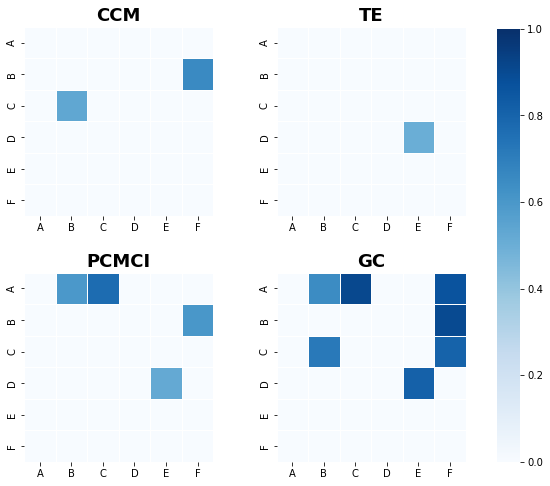

In [19]:
f, axes = plt.subplots(2, 2, figsize=(8,8))

f_1 = sns.heatmap(m_01, 
                  ax=axes[0][0], 
                  vmin=0, 
                  vmax=1, 
                  cmap='Blues', 
                  cbar=False, 
                  linewidths=.5, 
                  xticklabels=feature_names, 
                  yticklabels=feature_names, 
                  square=True)
f_1.set_title('CCM', fontsize=18, fontweight='bold')

f_2 = sns.heatmap(m_02, 
                  ax=axes[0][1], 
                  vmin=0, 
                  vmax=1, 
                  cmap='Blues', 
                  cbar=False, 
                  linewidths=.5, 
                  xticklabels=feature_names, 
                  yticklabels=feature_names, 
                  square=True)
f_2.set_title('TE', fontsize=18, fontweight='bold')

f_3 = sns.heatmap(m_03, 
                  ax=axes[1][0], 
                  vmin=0, 
                  vmax=1, 
                  cmap='Blues', 
                  cbar=False, 
                  linewidths=.5, 
                  xticklabels=feature_names, 
                  yticklabels=feature_names, 
                  square=True)
f_3.set_title('PCMCI', fontsize=18, fontweight='bold')

cbar_ax = f.add_axes([.95, .125, .04, 0.752])
f_4 = sns.heatmap(m_04, 
                  ax=axes[1][1], 
                  vmin=0, 
                  vmax=1, 
                  cmap='Blues', 
                  cbar_ax=cbar_ax, 
                  linewidths=.5, 
                  xticklabels=feature_names, 
                  yticklabels=feature_names, 
                  square=True)
f_4.set_title('GC', fontsize=18, fontweight='bold')

plt.subplots_adjust(wspace=0.3, hspace=0.3)

In [20]:
score = ce.evaluation()
print('Normalized_score:')
print(score)

Normalized_score:
0.8333333333333333


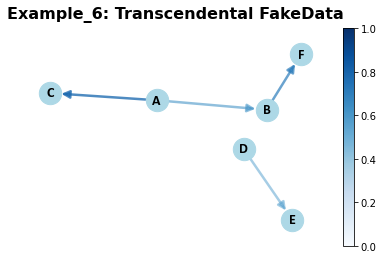

In [21]:
Graphic = causality_plotting(strength=strength_ensemble,
                             feature_names=feature_names, 
                             title='Example_6: Transcendental FakeData', 
                             node_color="lightblue", 
                             name_size='short',
                             title_size=16,
                             seed=0)
plt.savefig('C:/Users/zhipe/OneDrive/Desktop/Master thesis/codes/examples/results/Example_6.jpg',
            bbox_inches = 'tight',
            pad_inches=0.2,
            dpi=300)

Text(0.5, 1.0, 'Comprehensive Ensemble')

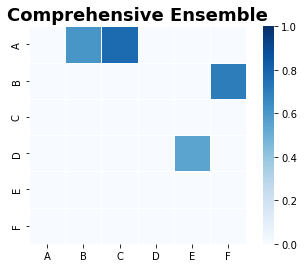

In [22]:
fig_0 = sns.heatmap(strength_ensemble, 
                    vmin=0, 
                    vmax=1, 
                    cmap='Blues', 
                    linewidths=.5, 
                    xticklabels=feature_names, 
                    yticklabels=feature_names, 
                    square=True)
fig_0.set_title('Comprehensive Ensemble', fontsize=18, fontweight='bold')